# Blackjack Notebook (bjnb)

[Hugues Hoppe](https://hhoppe.com/)
&nbsp;&nbsp;&mdash;&nbsp;
&nbsp; [**[Open in Colab]**](https://colab.research.google.com/github/hhoppe/blackjack/blob/main/blackjack.ipynb)
&nbsp; [**[in Kaggle]**](https://www.kaggle.com/notebooks/welcome?src=https://github.com/hhoppe/blackjack/blob/main/blackjack.ipynb)
&nbsp; [**[in MyBinder]**](https://mybinder.org/v2/gh/hhoppe/blackjack/main?filepath=blackjack.ipynb)
&nbsp; [**[in DeepNote]**](https://deepnote.com/launch?url=https%3A%2F%2Fgithub.com%2Fhhoppe%2Fblackjack%2Fblob%2Fmain%2Fblackjack.ipynb)
&nbsp; [**[GitHub source]**](https://github.com/hhoppe/blackjack)

Blackjack &mdash; _"the most widely played casino banking game in the world"_.

**Goals**:

- Solution methods for both:

  1. [Probabilistic analysis](#Probabilistic-analysis)
     of blackjack actions and outcomes under many strategies, and

  2. [Monte Carlo simulation](#Monte-Carlo-simulation)
     for cut-card effects and precise split-hand rewards.

- Support for many [rule variations](#Define-Rules)
  \(12 parameters including #decks, dealer hit soft17, cut-card, ...).

- Optimal [action tables](#Tables-for-basic-strategy) for
  [basic strategy](#Define-Action-and-Strategy)
  under any rules, reproducing
  [Wikipedia](https://en.wikipedia.org/wiki/Blackjack#Basic_strategy) and
  [WizardOfOdds](https://wizardofodds.com/games/blackjack/strategy/calculator/) results.

- Six [composition-dependent strategies](#Define-Action-and-Strategy)
  based on progressively greater levels of *attention*.
  <!--(initial cards, all hand cards, cards in *prior split hands*, ...).-->

- Computation of
  [house edge](#House-edge-results)
  under any rules, with either basic or composition-dependent strategies.

- Comparisons with results from online
  [hand calculators](#Hand-calculator-results) and
  [house edge calculators](#House-edge-results).

- Novel analysis and visualization of the
  [*cut-card effect*](#Effect-of-using-a-cut-card)
  and its [surprising oscillations](#cut-card-graph).

- Open-source Python, sped up with jitting (\~30x) and multiprocessing (\~10x),
  simulating ~$10^{8}$ hands/s.

**Versions**:
- 1.0 (March 2022): use probabilistic analysis for basic strategy tables and
  approximate house edge.
- 2.0 (July 2022): add Monte Carlo simulation, hand analysis,
  and cut-card analysis.

**Running this Jupyter notebook**:
- The notebook requires Python 3.10 or later.
- We recommend starting a Jupyter server on a local machine with a fast multi-core CPU. <br/>
  (The notebook can also be [executed on a Colab server](
   https://colab.research.google.com/github/hhoppe/blackjack/blob/main/blackjack.ipynb),
  but it runs ~20x slower due to the older, shared processor.)
- Configure a Linux environment (e.g.,
  [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/install)):

```bash
    sudo apt install python3-pip
    python3 -m pip install --upgrade pip
    pip install jupyterlab jupytext
    jupyter lab --no-browser
```

- Open the URL (output by `jupyter lab`) using a web browser (e.g., Google Chrome on Windows).
- Load the notebook (`blackjack.ipynb` file).
- Evaluate all cells in `Code library` and then selectively evaluate `Results`.
- Adjust the `EFFORT` global variable to trade off speed and accuracy.

In [1]:
# ** Future to-do?
# Try numba.njit(nogil=True) and multithreading; https://stackoverflow.com/a/45612308.
# Using prob or sim, compute house edge over many parameters and fit a function.
# Shared lru_cache: https://stackoverflow.com/a/55816091 and https://stackoverflow.com/a/13694262.

# Code library

## Imports

In [2]:
!pip install -q hhoppe-tools matplotlib more-itertools numba numpy tqdm

In [3]:
!if [ ! -f random32.py ]; then wget https://github.com/hhoppe/blackjack/raw/main/random32.py; fi

In [4]:
from __future__ import annotations

import collections
from collections.abc import Callable, Iterable, Iterator, Mapping
import contextlib
import dataclasses
import enum
import functools
import itertools
import logging
import math
import multiprocessing
import os
import pathlib
import pickle
import re
import subprocess
import sys
import textwrap
import time
import typing
from typing import Any, FrozenSet, Literal, Tuple, Union
import unittest.mock
import urllib.parse
import urllib.request
import warnings

import hhoppe_tools as hh
import matplotlib.pyplot as plt
import more_itertools
import numba
from numba import cuda
import numba.cuda.random
import numpy as np
import numpy.typing
import tqdm
import random32

In [5]:
def omit_cell_output() -> None:
  """Return None so that the cell does not output anything."""
  return None

In [6]:
# To archive the notebook, run with value 2.
EFFORT = typing.cast(Literal[0, 1, 2, 3, 4], hh.get_env_int('EFFORT', 2))
"""Controls the breadth and precision of the notebook experiments:
- 0: Fast subset of experiments, at lowest precision (~50 s).
- 1: Fast subset of experiments, at low precision (~100 s).
- 2: Most experiments, at normal precision (~16 minutes).
- 3: All experiments, at high precision (~?7 hours).
- 4: Run at even higher precision (>40 hours), likely on isolated experiments."""
assert 0 <= EFFORT <= 4

RECOMPUTE_CUT_CARD_ANALYSIS = False
"""If True, perform expensive recomputation of cut-card analysis for results graphs."""

omit_cell_output()

In [7]:
_F = typing.TypeVar('_F', bound=Callable[..., Any])
_T = typing.TypeVar('_T')

In [8]:
_NDArray = numpy.typing.NDArray[Any]
_CudaArray = Any  # cuda.cudadrv.devicearray.DeviceNDArray

In [9]:
check_eq = hh.check_eq
_ORIGINAL_GLOBALS = list(globals())  # Store current set of variable names.
_ = np.seterr(all='raise')  # Let all numpy warnings raise errors.
hh.start_timing_notebook_cells()

In [10]:
if not hh.in_notebook():
  # Disable graphics plot windows when running this notebook as a script.
  plt.show = lambda *args, **kwargs: None

In [11]:
Card = int
"""Card value satisfying 1 <= card <= 10, where ace is 1."""

Cards = Tuple[Card, ...]
"""Sequence of cards, sometimes sorted in ascending order."""

Hand = Tuple[Cards, Card]
"""Tuple `(player_cards, dealer1)` where `player_cards[:2]` and `player_cards[2:]` are sorted."""

State = Tuple[Cards, Card, Cards]  # (*hand, split_cards)
"""Drawn cards `(player_cards, dealer1, split_cards) = (*hand, split_cards)` involved in a hand:
- `player_cards = (card1, card2, *sorted_other_player_cards)`: with `card1 <= card2`.
- `dealer1`: is the dealer upcard.
- `split_cards = (a, ..., a, *sorted_other_split_cards)`: contains the cards drawn in earlier
  split hands, where `a` is the card value in the original card pair `(a, a)` that was split."""

CARD_VALUES = 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10  # (Ace has value 1 but can count as 11.)
NUM_SUITS = 4
DECK_SIZE = NUM_SUITS * len(CARD_VALUES)
UNIFORM_CARD_PROB = {card: CARD_VALUES.count(card) / len(CARD_VALUES) for card in CARD_VALUES}
DEFAULT_NUM_DECKS = 6
SHOE_SIZE_FOR_INFINITE_DECKS_CPU = 6 * DECK_SIZE
SHOE_SIZE_FOR_INFINITE_DECKS_CUDA = 2 * DECK_SIZE
SHOE_SIZE_FOR_SINGLE_HAND_INFINITE_DECKS = 20
SPLIT_SECOND_CARDS_SIZE = 12
PLUS_MINUS_CHAR = '\u00b1'  # Used to indicate precision in Monte Carlo simulation results.
PLUS_MINUS_STANDARD_DEVIATIONS = 2.0  # Results precision bracket; 95% probability within 2 sdv.
WARNING_STANDARD_DEVIATIONS = 3.0  # Warning '*' in results; 99.7% probability within 3 sdv.
AVERAGE_CARDS_PER_HAND = 5.42  # Determined empirically (for one player against dealer).
DISALLOWED = -1e10  # Large negative reward indicating an illegal action.

In [12]:
def numba_njit(*args: Any, **kwargs: Any) -> Callable[[_F], _F]:
  """Typed replacement for non-bare `@numba.njit()` decorator."""
  assert kwargs or not (len(args) == 1 and callable(args[0]))

  def decorator(func: _F) -> _F:
    jitted_func: _F = numba.njit(*args, **kwargs)(func)
    return jitted_func

  return decorator

In [13]:
def multiprocessing_is_available() -> bool:
  """Return True if multiprocessing may enable a performance improvement."""
  has_cpu_limit = os.environ.get('CPU_LIMIT') == '1.0'  # Kubernetes on mybinder.org
  return ('fork' in multiprocessing.get_all_start_methods() and multiprocessing.cpu_count() > 2 and
          not has_cpu_limit)

In [14]:
@contextlib.contextmanager
def temporary_effort(effort: int) -> Iterator[None]:
  """Temporarily set the global `EFFORT` to `effort` and clear all memoization caches."""
  assert 0 <= effort <= 4
  hh.clear_functools_caches(globals())
  try:
    with hh.temporary_assignment(globals(), EFFORT=effort):
      yield
  finally:
    hh.clear_functools_caches(globals())

In [15]:
def show_kernel_memory_resident_set_size() -> None:
  """Print the memory size of the IPython kernel."""
  if sys.platform != 'linux':
    warnings.warn('show_kernel_memory_resident_set_size is only implemented for linux.')
    return
  command = f'ps -p {os.getpid()} -o rss --no-headers'
  output = subprocess.run(command, shell=True, check=True, capture_output=True, text=True).stdout
  rss_kb = int(output)
  print(f'{rss_kb*1024/1e9:.1f} GiB')

In [16]:
def show_cuda_memory_usage() -> None:
  """Print the amount of GPU memory allocated by CUDA."""
  if cuda.is_available():
    free, total = cuda.current_context().get_memory_info()
    used = total - free
    print(f'CUDA memory usage {used / 1024**3:.1f} GiB  ({free / 1024**3:.1f} GiB free)')
  else:
    print('CUDA is not available')

In [17]:
def tqdm_stdout(*args: Any, **kwargs: Any) -> Any:
  """Progress bar customized to show a short ascii text line on stdout."""
  if not hh.in_notebook():
    kwargs['disable'] = True
  return tqdm.tqdm(*args, leave=False, file=sys.stdout, ascii=True, mininterval=0.2, smoothing=0.1,
                   bar_format='{desc}:{percentage:3.0f}% [{elapsed}<{remaining}]', **kwargs)
# Notes: tqdm uses '\r' and overwrites with spaces (annoying for copy-paste);
# jupyterlab does not correctly handle more than two backspaces ('\b');
# `tqdm.notebook.tqdm()`, which displays HTML, does not work with multiprocessing and does not
# erase completely; `progressbar2` is poorly documented; `rich` requires ipywidget.

omit_cell_output()

In [18]:
hh.adjust_jupyterlab_markdown_width()

## Define `Rules`
<a name="Define-Rules"></a>

The `Rules` class below captures the many
[variations in blackjack rules](https://en.wikipedia.org/wiki/Blackjack#Rule_variations_and_effects_on_house_edge).

The class fields default to values used in
the [Wikipedia page](https://en.wikipedia.org/wiki/Blackjack).

Another useful reference is a
[comparison of Las Vegas casinos](https://wizardofvegas.com/guides/blackjack-survey/)
which uses the base rules:
- BJ pays 3:2;
- one bet lost to a dealer's BJ;
- you may double down on any two cards but not after splitting;
- you may split any pair;
- you may resplit any pair except aces to make up to four hands;
- split aces receive one card each;
- insurance;
- no surrender.

For a 6-deck shoe, those base rules correspond to
`Rules.make(double_after_split=False, late_surrender=False)`.

Their table of casinos (171 rows) lists common rule variations:
- "ds": (`double_after_split=True`): 148 out of 171 (frequent).
- "ls": (`late_surrender=True`): 56 out of 171.
- "rsa": (`resplit_aces=True`): 50 out of 171.
- "s17": (`hit_soft17=False`): 28 out of 171 (opposite of "h17").

The casino listed with the lowest house edge is:
"Caesars Palace; 0.26%; 6 decks; s17,ds,ls,rsa". <br/>
This corresponds to `Rules.make(hit_soft17=False, resplit_aces=True)`.

In [19]:
# "In games involving a shoe, about 3/4 of the deck is used before the cut card is reached and
# the deck is shuffled."
# "In Pitch Blackjack (i.e., single deck or double deck), the cut card is inserted closer to the
# top of the deck, about 1/2 of the way down.  In most cases, the deck is shuffled after
# each hand of play."


def default_cut_card(num_decks: float) -> int:
  """Return the default number of cards in front of the cut-card for a shoe with `num_decks`."""
  match num_decks:
    case math.inf:
      return 0  # (The implementation plays a fixed number of hands per shoe.)
    case 1:
      return DECK_SIZE // 2  # The cut-card is at the middle of the deck.
    case 2:
      return 2 * DECK_SIZE - DECK_SIZE // 2  # The cut-card is 0.5 decks from the rear of the shoe.
    case _:
      assert num_decks > 2 and num_decks == int(num_decks)
      return int(num_decks) * DECK_SIZE - 78  # The cut-card is 1.5 decks from the rear.

In [20]:
@hh.terse_str
@dataclasses.dataclass(frozen=True)
class Rules:
  """Blackjack rules (many variations); create using `Rules.make(**kwargs)`."""

  _create_using_make: bool = dataclasses.field(hash=False, repr=False)
  """Dummy field introduced to enforce instance creation using Rules.make()."""

  num_decks: float = DEFAULT_NUM_DECKS
  """Number of decks in the shoe, e.g., 1, 2, 4, 6, 8, or math.inf."""

  blackjack_payout: float = 1.5
  """Payout for player ace-ten; 6/5 or 1 greatly increase the house edge."""

  hit_soft17: bool = True
  """Whether the dealer hits (rather than stands) on a soft total of 17 (denoted "s17"/"h17").
  False is favorable to the player."""

  obo: bool = True
  """On dealer blackjack, player loses Original Bet Only (i.e., not DOUBLE or SPLIT bets).
  If True, when the dealer's upcard is 10 or ace, the dealer first peeks at their hole card
  before any player action to detect a dealer bj, and if present, collects the bets from players
  who do not themselves have bj."""

  late_surrender: bool = True
  """Allow the player to SURRENDER, i.e. forfeit 50% of the bet if the dealer does not have
  blackjack (denoted "ls").  Should likely be False if obo=False."""

  double_min_total: Literal[0, 9, 10] = 0
  """If zero, the player may DOUBLE on any two cards.  Otherwise, the player must have a hard
  total of at least this value (either 9 or 10); value 9 is the "Reno rule"; value 10 is the
  "European rule".  Because the optimal strategy tables do not suggest "DOUBLE" for a hard
  total > 11, value 9 is also equivalent to the "DOUBLE on 9-11" rule."""

  double_after_split: bool = True
  """Allow DOUBLE as the first action of splitting a pair (denoted "ds")."""

  split_to_num_hands: float = 4
  """Total number of hands that can result from splitting pairs.  Can be 0 or any value >= 2.
  Common values include 0 (no splitting), 2 (single split), 4, or math.inf."""

  resplit_aces: bool = False
  """Whether aces can be split more than once (denoted "rsa")."""

  hit_split_aces: bool = False
  """Allow hitting after splitting aces.  If False (the default), a single card is added to each
  split ace and the player must stand (which is unfavorable to the player)."""

  double_split_aces: bool = False
  """Allow doubling after splitting aces.  Rare."""

  cut_card: int = default_cut_card(DEFAULT_NUM_DECKS)
  """Number of shoe cards in front of the cut-card.  The shoe is reshuffled after completion of
  the hand during which the cut-card is exposed.  The default is a positive value that depends
  on `num_decks`.  The minimum value is 0, in which case the shoe is reshuffled after every hand,
  as in a continuous shuffling machine; for improved efficiency, we simulate a fixed (>1) number
  of hands and this is still equivalent to continuous shuffling."""

  num_players: int = 1
  """The number of players affects how quickly the cut-card is reached.  Not yet implemented."""

  def __post_init__(self) -> None:
    """Check validity of constructed rules."""
    ndecks = self.num_decks
    assert ndecks == math.inf or (ndecks == int(ndecks) and ndecks >= 1)
    assert self.blackjack_payout >= 1.0
    assert self.double_min_total in (0, 9, 10)
    splitn = self.split_to_num_hands
    assert splitn in (0, math.inf) or (splitn == int(splitn) and splitn >= 2)
    assert 0 <= self.cut_card <= (0 if ndecks == math.inf else ndecks * DECK_SIZE)
    assert self.num_players == 1  # More than one player is not yet implemented.
    # Note that with split_to_num_hands == 0, we ignore resplit_aces, hit_split_aces,
    # and double_split_aces.  And with split_to_num_hands == 2, we ignore resplit_aces.

  @classmethod
  def make(cls: type, num_decks: float = DEFAULT_NUM_DECKS, *,
           cut_card: int | None = None, **kwargs: Any) -> Rules:
    """Create rules with default cut_card based on the number of decks."""
    cut_card = default_cut_card(num_decks) if cut_card is None else cut_card
    rules: Rules = cls(_create_using_make=True, num_decks=num_decks, cut_card=cut_card,
                       num_players=1, **kwargs)
    return rules

In [21]:
BEST_RULES = Rules.make(num_decks=1, split_to_num_hands=math.inf, resplit_aces=True,
                        hit_split_aces=True, double_split_aces=True, cut_card=0)
"""Combination of rules with the lowest house edge (which is in fact negative)."""

WORST_RULES = Rules.make(num_decks=math.inf, blackjack_payout=1, hit_soft17=False, obo=False,
                         late_surrender=False, double_min_total=10, double_after_split=False,
                         split_to_num_hands=2)
"""Combination of rules with the highest house edge."""

omit_cell_output()

# (Although the ingenious `Rules.make(num_decks=1, ..., cut_card=5)` has a low house edge,
# its edge is not as low as `Rules.make(num_decks=math.inf)`.)

In [22]:
# We do not distinguish between different cards with value 10, i.e., 10, jack, queen, and king.
# A possible issue of whether the player is allowed to split any two cards with value 10,
# e.g. (king, 10).  This is usually allowed.  If it were disallowed, it would affect the
# probability of occurrence of splits and resplits.  However, the basic strategy tables show that
# is always favorable to stand on (10, 10), so the issue is moot.

## Define `Action` and `Strategy`
<a name="Define-Action-and-Strategy"></a>

In [23]:
# pytype fails on hh.OrderedEnum; it is ok with enum.Enum but then max((reward, action)) may fail.
if typing.TYPE_CHECKING:
  OrderedEnum = enum.Enum
else:
  OrderedEnum = hh.OrderedEnum

In [24]:
class Action(OrderedEnum):
  """Player actions."""

  STAND = enum.auto()
  HIT = enum.auto()
  DOUBLE = enum.auto()
  SPLIT = enum.auto()
  SURRENDER = enum.auto()


Actions = FrozenSet[Action]
ACTIONS = frozenset(Action)
IMPOSSIBLE_ACTION_VALUE = 0  # (action.value are numbered starting at 1 as in enum.auto().)

# One-letter abbreviation used in strategy tables.
CODE_FOR_ACTION = {
    Action.STAND: 'S',
    Action.HIT: 'H',
    Action.DOUBLE: 'D',
    Action.SPLIT: 'P',
    Action.SURRENDER: 'U',
}

COLOR_FOR_CODE = {
    'S': (1.0, 0.0, 0.0),  # Red.
    'H': (0.0, 1.0, 0.0),  # Green.
    'D': (0.0, 1.0, 1.0),  # Cyan.
    'P': (1.0, 1.0, 0.0),  # Yellow.
    'U': (1.0, 1.0, 1.0),  # White.
}

In [25]:
def test_action() -> None:
  """Check string representations of Action."""
  check_eq(list(Action), [Action.STAND, Action.HIT, Action.DOUBLE, Action.SPLIT, Action.SURRENDER])
  action = Action.STAND
  check_eq(action.name, 'STAND')
  check_eq(action.value, 1)
  check_eq(action.name.lower(), 'stand')
  check_eq(str(action), 'Action.STAND')
  check_eq(repr(action), '<Action.STAND: 1>')
  check_eq(CODE_FOR_ACTION[action], 'S')


test_action()

In [26]:
class Attention(enum.Enum):
  """Aspects of the player and dealer cards that condition the optimal action."""
  # Other ideas for class name: Scope, Inspect, Feature, Heed, Observe, Mull, Track.

  TOTAL_OF_CARDS = enum.auto()
  """Consider `(card1, card1, dealer1)` for the first action on a paired hand,
  or else `(player_total, player_soft, dealer1)`, i.e., "total-dependent basic strategy"."""

  INITIAL_CARDS_OR_TOTAL = enum.auto()
  """Consider individual cards `(card1, card2)` for the first action, and then revert back to
  TOTAL_OF_CARDS for later actions.  It is a limited form of "composition-dependent" strategy."""

  INITIAL_CARDS_AND_TOTAL = enum.auto()
  """Consider both the first two cards and the card total.  It is a limited form of
  "composition-dependent" strategy."""

  HAND_CARDS_ONLY = enum.auto()
  """Consider all card values in the player's hand (and of course `dealer1`).  However,
  after splitting, keep no memory of cards in the prior split hands."""

  HAND_AND_NUM_PRIOR_SPLITS = enum.auto()
  """Like `HAND_CARDS_ONLY` but also consider the number of split hands that have resulted so far.
  For the third hand of the split hands `[(8, 4, 7), (8, 10), (8, 2, 1)]`, we know the current
  hand `(8, 2, 1)` and the fact that the card `8` appeared twice in the prior split hands.
  We use this as the default for `COMPOSITION_DEPENDENT_STRATEGY`."""

  HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS = enum.auto()
  """Like `HAND_AND_NUM_PRIOR_SPLITS` but also consider the initial two cards of all prior split
  hands.  For the third hand of the split hands `[(8, 4, 7), (8, 10), (8, 2, 1)]`, we know the
  current hand `(8, 2, 1)` and the cards `8, 8, 4, 10` which appeared as initial cards in the
  two prior split hands."""

  # HAND_AND_PRIOR_SPLIT_HANDS
  # Not implemented: it would greatly increase the probabilistic state to track.

  def __repr__(self) -> str:
    """Hide the integer `self.value` and show only the string name."""
    return f'{self.__class__.__name__}.{self.name}'

In [27]:
@dataclasses.dataclass(frozen=True)
class Strategy:
  """Player's strategy."""

  attention: Attention = Attention.TOTAL_OF_CARDS
  """Aspects of the player and dealer cards that contribute to deciding the best action.
  The default (total-dependent basic strategy) considers the dealer upcard, the player total, and
  whether this player total is hard or soft."""

  first_actions: Actions = ACTIONS
  """Subset of player first actions to consider; default is all actions.  The subsequent
  candidate actions are always {Action.STAND, Action.HIT}.  If set to `frozenset({Action.SPLIT})`,
  forces splitting of pairs but places no constraint on the first action of the resulting
  completed split hands."""

  def __post_init__(self) -> None:
    """Check validity of strategy."""
    assert self.first_actions, 'Strategy must have at least one first action.'

  def __str__(self) -> str:
    """Shorten the string description (omit "Attention.", "Action.", and "frozenset(...)")."""
    fields_s = []
    if self.attention is not Attention.TOTAL_OF_CARDS:
      fields_s.append(f'attention={self.attention}')
    if self.first_actions != ACTIONS:
      fields_s.append(f'first_actions={{{",".join(action.name for action in self.first_actions)}}}')
    return f'Strategy({", ".join(fields_s)})'

In [28]:
BASIC_STRATEGY = Strategy()  # (attention=Attention.TOTAL_OF_CARDS)
"""The basic (or "total-dependent") strategy considers the player's total rather than the
individual card values."""

INITIAL_DEPENDENT_STRATEGY = Strategy(attention=Attention.INITIAL_CARDS_AND_TOTAL)
"""This strategy considers not just the player's total but also the values of the player's two
initial cards."""

COMPOSITION_DEPENDENT_STRATEGY = Strategy(attention=Attention.HAND_AND_NUM_PRIOR_SPLITS)
"""The composition-dependent strategy considers all the cards in the current hand plus the number
of prior split hands.  It less powerful than HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS but only
very slightly."""

omit_cell_output()

In [29]:
BEST_STRATEGY = Strategy(attention=Attention.HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS)
"""Strategy that is most favorable to the player."""

WORST_STRATEGY = Strategy(first_actions=frozenset({Action.STAND, Action.HIT}))
"""Strategy that is least favorable to the player."""

omit_cell_output()

## Probabilistic analysis
<a name="Probabilistic-analysis"></a>

**Graph representation**

We form a graph where:
1) the nodes are hand states, and
2) the edges are player/dealer actions (`STAND`, `HIT`, `DOUBLE`, `SPLIT`, and `SURRENDER`).

Ideally, the hand $\text{state}$ captures the full sequence of player cards and dealer cards
and the set of all cards seen in prior hands.
(We use a few pruning heuristics (based on the global parameter `EFFORT`)
to put finite bounds on this combinatorial state.)

The probabilities $\text{ProbCard}(\text{state})$ of drawing card values from the shoe
is computed based on the card counts in the current hand $\text{state}$.
(As an example, for a 1-deck shoe, if the player cards contain three 2's and
the dealer upcard is a 2, the probability of drawing another 2 is zero.)

We express the expected reward for an action at a given graph node
as a weighted summation of expected rewards at other graph nodes.
For example, the reward for a `HIT` action is:

$$\text{reward}(\text{state}, \text{HIT}) =
  \sum_{(\text{prob}, \text{card}) \in \text{ProbCard}(\text{state})}
    \text{prob}\cdot \text{reward}\big(\text{combine}(\text{state}, \text{card})\big),$$

where $\text{combine}(\text{state}, \text{card})$ returns a new state with the added card.
The other actions have similar recurrence formulas based on the rewards of other states.

The reward for a hand $\text{state}$ is the reward for the optimal action at that state:

$$\text{reward}(\text{state}) = \max_{\text{action}}
    \text{reward}\big(\text{state}, \text{action}\big).$$

For an initial hand (i.e., a starting state),
the expected reward is evaluated by recursively traversing the graph,
computing the expected reward of each encountered hand state.
Because the graph is a [DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph)
rather than a tree, each hand state may be traversed more than once,
so it is beneficial to
[memoize](https://en.wikipedia.org/wiki/Memoization) the intermediate reward values.

**Player strategy/attention**

The optimal action defined above is based on maximizing the reward for the *specific hand state*.
This is a fully **composition-dependent strategy**.

However, it is impractical for a human player to memorize the best action
for every possible combination of player cards (including prior split hands).
Practical strategies restrict the player **attention** to specific aspects of the hand,
such as the player total and softness.
We identify [*6 levels of attention*](#Define-Action-and-Strategy).
The simplest one is `Attention.TOTAL_OF_CARDS`, which corresponds to
[*basic strategy*](https://en.wikipedia.org/wiki/Blackjack#Basic_strategy).

We generalize the prior formulas to include attention:

$$\text{reward}(\text{state}, \text{attention}, \text{HIT}) =
  \sum_{(\text{prob}, \text{card}) \in \text{ProbCard}(\text{state})}
    \text{prob}\cdot \text{reward}\big(
      \text{combine}(\text{state}, \text{card}), \text{attention}\big),$$

$$\text{reward}(\text{state}, \text{attention}) =
  \text{reward}\Big(\text{state}, \text{attention},
    \underset{\text{action}}{\operatorname{argmax}}
      \text{reward}\big(\text{Project}_{\text{attention}}(\text{state}),
        \text{attention}, \text{action}\big)
    \Big),$$

where $\text{state}' = \text{Project}_{\text{attention}}(\text{state})$ maps $\text{state}$
onto a canonical $\text{state}'$ which keeps only the attended aspects.

As an example, `Attention.HAND_CARDS_ONLY` ignores the card values in any prior split hands,
so if $\text{state}$=`(player_cards, dealer1, split_cards)`,
$\text{Project}_{\text{HAND\_CARDS\_ONLY}}(\text{state})$ = `(player_cards, dealer1, ())`.

Crucially, although we select the best action after projecting the state
to a simpler canonical state,
we then evaluate the reward for that best action using the original state.

**Card probabilities**

Before each card is drawn, we create a table of card counts from the original shoe,
then subtract all of cards in the current hand state (both the player and dealer cards),
and thus determine the probability of each card value.

A tricky aspect is that with `rules.obo` (Original Bets Only, which is True by default),
**when the dealer's upcard is 10 or ace**,
the dealer peeks at their hole card to check if they have blackjack before any player action.

Thereafter, the fact that the dealer does not have blackjack
**conditions the value of the dealer hole card**, and indirectly,
the probability of all subsequent cards drawn in the hand.

We model this accurately using fractional counts during the card probability computations.
For example, if the dealer's upcard is an ace, then it is known that the dealer hole card is
not a 10, and for each of the card values (1, 2, 3, 4, 5, 6, 7, 8, 9), we reduce
their count by the fraction $1/9$.
See function `card_probabilities_helper` for details.

Here is a summary of the ordering of the conditional card probabilities with `obo=True`:
- We select the dealer upcard `dealer1` with uniform distribution.
- We select player `card1` conditional on `[dealer1]`.
- We select player `card2` conditional on `[dealer1, card1]`.
- We determine `prob_dealer_bj` based on `[dealer1, card1, card2]`,
- We select all subsequent player cards conditional on `recent_cards` (which contains
   `dealer1, card1, card2, ...`) and on `dealer1` if it is 1 or 10 due to
   constraints on `dealer2` that dealer has no blackjack.
- We choose `dealer2` conditional on `recent_cards` and with a non-blackjack constraint.
- We select the subsequent dealer cards conditional on `recent_cards`.

**Evaluating reward for split hands**

For a given hand state, we consider a SPLIT action to perform as many resplits as are allowed.
(In other words, we do not try to identify states where a smaller (finite) number of splits
gives a greater reward; from experiments it seems that this never arises.)

For a SPLIT action on a pair, we initialize a list of two incomplete hands that need
further cards.
We probabilistically expand the drawing of successive cards (for a finite number of iterations);
when the drawn card allows a resplit, we push an incomplete hand onto the list,
else we add the card to an existing incomplete hand.
See function `reward_for_split` for details.

**Sources of error in the probabilistic results**:

- The current probabilistic analysis ignores any penetration in the shoe,
  so it **does not account for a [*cut-card effect*](#Effect-of-using-a-cut-card)**.
  This is valid if playing just the first hand of each shoe (i.e. "continuous reshuffling") or
  playing any *fixed number* of hands from each shoe.
  Hand calculators make this assumption.
  If computing the house edge for a shoe with a cut card,
  the probabilistic result underestimates the house edge;
  the difference is greater for smaller shoes,
  e.g. it is about 0.14% when the shoe has just one deck.

- The **state for a split hand is incomplete**.
  When splitting cards to form multiple hands,
  we compute the reward for split hand $i$ based on `split_cards` which includes
  the two initial cards `(card1, card2)` for split hands $1, \ldots, i-1$
  but does not include any subsequent drawn cards (by either the player or dealer) from
  those earlier split hands.

### Hands and totals

In [30]:
def check_hand(hand: Hand) -> None:
  """Check validity of hand."""
  player_cards, dealer1 = hand
  assert len(player_cards) >= 2 and all(1 <= card <= 10 for card in (*player_cards, dealer1)), hand
  assert player_cards[0] <= player_cards[1], hand
  assert player_cards[2:] == tuple(sorted(player_cards[2:])), hand

In [31]:
def generate_hands_totaling(total: int, rules: Rules, _prefix: Cards = ()) -> Iterator[Cards]:
  """Yield all possible (non-busted) hands with specified `total`, given `rules.num_decks`."""
  prefix_total = sum(_prefix)
  min_value = _prefix[-1] if _prefix else 2 if total < 12 else 1
  for card in range(min_value, min(11, total - prefix_total + 1)):
    if _prefix.count(card) < rules.num_decks * NUM_SUITS:
      sequence = *_prefix, card
      new_total = prefix_total + card
      total_is_correct = new_total == total or (new_total + 10 == total and 1 in sequence)
      if total_is_correct and len(sequence) >= 2:
        yield sequence
      if new_total < total:
        yield from generate_hands_totaling(total, rules, sequence)


def generate_all_hands(rules: Rules) -> Iterator[Cards]:
  """Yield all possible (non-busted) hands, given `rules.num_decks`."""
  for total in range(4, 22):
    yield from generate_hands_totaling(total, rules)


def number_of_unique_hands(rules: Rules) -> int:
  """Return the number of possible (non-busted) hands, given `rules.num_decks`."""
  return sum(1 for _ in generate_all_hands(rules))


def generate_all_initial_cards() -> Iterator[Cards]:
  """Yield all possible initial two cards (such that card1 <= card2)."""
  for card1 in range(1, 11):
    for card2 in range(card1, 11):
      yield card1, card2

In [32]:
check_eq(list(generate_hands_totaling(8, Rules.make(num_decks=1))),
         [(2, 2, 2, 2), (2, 2, 4), (2, 3, 3), (2, 6), (3, 5), (4, 4)])

check_eq(list(generate_hands_totaling(21, Rules.make(num_decks=1)))[:2],
         [(1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3), (1, 1, 1, 1, 2, 2, 2, 2, 3, 6)])

check_eq(list(generate_hands_totaling(21, Rules.make(num_decks=1)))[-7:],
         [(5, 5, 5, 6), (5, 6, 10), (5, 7, 9), (5, 8, 8), (6, 6, 9), (6, 7, 8), (7, 7, 7)])

check_eq(list(generate_hands_totaling(21, Rules.make(num_decks=8)))[:2], [(1,) * 11, (1,) * 21])

check_eq(sum(1 for _ in generate_hands_totaling(21, Rules.make(num_decks=1))), 416)

check_eq(list(generate_all_hands(Rules.make(num_decks=1)))[:20],
         [(2, 2), (2, 3), (2, 2, 2), (2, 4), (3, 3), (2, 2, 3), (2, 5), (3, 4), (2, 2, 2, 2),
          (2, 2, 4), (2, 3, 3), (2, 6), (3, 5), (4, 4), (2, 2, 2, 3), (2, 2, 5), (2, 3, 4),
          (2, 7), (3, 3, 3), (3, 6)])

check_eq(list(generate_all_hands(Rules.make(num_decks=1)))[-20:],
         [(3, 5, 5, 8), (3, 5, 6, 7), (3, 6, 6, 6), (3, 8, 10), (3, 9, 9), (4, 4, 4, 4, 5),
          (4, 4, 4, 9), (4, 4, 5, 8), (4, 4, 6, 7), (4, 5, 5, 7), (4, 5, 6, 6), (4, 7, 10),
          (4, 8, 9), (5, 5, 5, 6), (5, 6, 10), (5, 7, 9), (5, 8, 8), (6, 6, 9), (6, 7, 8),
          (7, 7, 7)])

In [33]:
# Surprisingly, there are few unique hands in blackjack: 2008 for 1 deck, and 3072 maximum.
check_eq({num_decks: number_of_unique_hands(Rules.make(num_decks=num_decks))
          for num_decks in [1, 2, 4, 6, 8, math.inf]},
         {1: 2008, 2: 2796, 4: 3060, 6: 3072, 8: 3072, math.inf: 3072})

# The C++ program at https://www.bjstrat.net/playerHands.html reports 3082 possible non-busted
# hands.  It includes single-card hands, which we do not.  Because there are 10 single-card hands,
# the numbers match exactly!

In [34]:
def order_cards(card1: Card, card2: Card) -> tuple[Card, Card]:
  """Return the two cards in non-descending order."""
  # assert 1 <= card1 <= 10 and 1 <= card2 <= 10
  return (card1, card2) if card1 <= card2 else (card2, card1)

In [35]:
def combine_two_cards(card1: Card, card2: Card) -> tuple[int, bool]:
  """Return `(total, soft)`; the total of the two cards and whether that total is soft."""
  # assert 1 <= card1 <= 10 and 1 <= card2 <= 10
  if card1 == 1 or card2 == 1:
    return card1 + card2 + 10, True
  return card1 + card2, False


numba_combine_two_cards = numba_njit(inline='always')(combine_two_cards)

In [36]:
def combine_cards(cards: Cards) -> tuple[int, bool]:
  """Return `(total, soft)`: the total of `cards` and whether that total is soft."""
  # assert len(cards) >= 2 and all(1 <= card <= 10 for card in cards)
  total = sum(cards)
  if total < 12 and 1 in cards:
    return total + 10, True
  return total, False


check_eq(combine_cards((2, 5)), (7, False))
check_eq(combine_cards((1, 2)), (13, True))
check_eq(combine_cards((1, 10)), (21, True))
check_eq(combine_cards((2, 1, 6)), (19, True))
check_eq(combine_cards((2, 1, 5, 2)), (20, True))
check_eq(combine_cards((2, 1, 5, 4)), (12, False))
check_eq(combine_cards((1, 1)), (12, True))
check_eq(combine_cards((1, 1, 10)), (12, False))

In [37]:
def add_card(total: int, soft: bool, card: Card) -> tuple[int, bool]:
  """Return new card total and softness given an additional card."""
  # assert 4 <= total <= 21 and 1 <= card <= 10
  total += card
  if total > 21:
    if soft:
      total, soft = total - 10, False
  elif total < 12 and card == 1:
    total, soft = total + 10, True
  return total, soft


numba_add_card = numba_njit(inline='always')(add_card)

In [38]:
def two_cards_reproducing_total(total: int, soft: bool, dealer1: Card) -> tuple[Card, Card]:
  """Return two cards to satisfy assertions (not used for probabilities)."""
  # assert (12 if soft else 4) <= total <= 21 and 1 <= dealer1 <= 10
  if total == 21 and not soft:
    soft = True

  if soft:
    card1, card2 = 1, total - 11

  elif total >= 12:
    # The mode of the distribution has at least one card being a 10.
    card1, card2 = total - 10, 10

  else:
    # The mode of the distribution has both cards being distinct from dealer's,
    # so we prefer finding such two cards.
    for card1 in range(2, (total + 1) // 2):
      card2 = total - card1
      if dealer1 not in (card1, card2):
        break
    else:
      card1, card2 = 2, total - 2  # None preferable, so pick any two.

  # assert card1 <= card2 and combine_two_cards(card1, card2) == (total, soft), (card1, card2)
  return card1, card2

In [39]:
@functools.cache
def get_canonical_hand_with_initial_cards_and_total(initial_cards: tuple[Card, Card],
                                                    total: int, soft: bool) -> Cards:
  """Return cards with specified initial two cards, total, and softness."""
  assert len(initial_cards) == 2
  total2, soft2 = combine_cards(initial_cards)
  remainder = total - total2
  if remainder < 1:
    assert soft2
    total2, soft2 = total2 - 10, False
    remainder += 10

  assert remainder >= 1
  cards = initial_cards + (
      (remainder, 10) if remainder <= 10 and soft2 and not soft else
      (remainder,) if remainder <= 10 else
      (1,) if remainder == 11 and soft else
      (1, remainder - 11) if soft else
      (remainder - 10, 10))

  if 0:
    assert all(1 <= card <= 10 for card in cards), (initial_cards, total, soft)
    assert combine_cards(cards) == (total, soft), (initial_cards, total, soft)

  return cards

In [40]:
@functools.cache
def get_canonical_hand_keeping_initial_cards_and_total(cards: Cards) -> Cards:
  """Return new cards with the same initial two cards and the same total and softness."""
  assert len(cards) > 3
  total, soft = combine_cards(cards)
  return get_canonical_hand_with_initial_cards_and_total(cards[:2], total, soft)


check_eq(get_canonical_hand_keeping_initial_cards_and_total((1, 2, 1, 10)), (1, 2, 1, 10))
check_eq(get_canonical_hand_keeping_initial_cards_and_total((2, 3, 2, 4)), (2, 3, 6))
check_eq(get_canonical_hand_keeping_initial_cards_and_total((2, 3, 3, 5, 5)), (2, 3, 3, 10))
check_eq(get_canonical_hand_keeping_initial_cards_and_total((2, 3, 2, 3, 4, 5)), (2, 3, 4, 10))

In [41]:
def state_hit_card(state: State, card: Card) -> State:
  """Add a new card to the player's hand."""
  player_cards, dealer1, split_cards = state
  MAX_NUM_PLAYER_CARDS_FOR_EFFORT = [3, 3, 5, 20, 20]

  if len(player_cards) >= MAX_NUM_PLAYER_CARDS_FOR_EFFORT[EFFORT]:
    player_cards = get_canonical_hand_keeping_initial_cards_and_total(player_cards + (card,))

  else:
    player_cards = *player_cards[:2], *sorted((*player_cards[2:], card))

  return player_cards, dealer1, split_cards

### Card probabilities

In [42]:
MAX_NUM_RECENT_CARDS_FOR_EFFORT = [4, 5, 9, 10, 14]
# No more differences above 14 for SPLIT on ((10, 10), 4) in analyze_hand_action_wrt_attention().
# EFFORT=2: value was 7; 9 is almost as fast; 10 increases memory from 10 GiB to 12 GiB.
"""Upper bound on the number of tracked cards in probabilistic analysis during dealer draw and
during SPLIT draw.  If set to a larger value (e.g., 11), there are many distinct calls to
reward_after_dealer_upcard(), resulting in increased run time and memory utilization
(memoization lru_cache); besides, results do not change much."""

RecentCards = Union[Cards, None]
"""Sorted tuple of card values (1-10), or None if not tracked."""


def make_recent(cards: Cards, rules: Rules) -> RecentCards:
  """Activate card tracking if the shoe has a finite number of decks."""
  enabled = rules.num_decks != math.inf
  max_num_recent_cards = MAX_NUM_RECENT_CARDS_FOR_EFFORT[EFFORT]
  return tuple(sorted(cards[:max_num_recent_cards])) if enabled else None


def make_recent_from_state(state: State, rules: Rules) -> RecentCards:
  """Activate card tracking if the shoe has a finite number of decks."""
  player_cards, dealer1, split_cards = state
  return make_recent((*player_cards, dealer1, *split_cards), rules)


def add_recent(recent_cards: RecentCards, new_card: Card) -> RecentCards:
  """Add a new card to the tuple of recent cards if tracking is active."""
  max_num_recent_cards = MAX_NUM_RECENT_CARDS_FOR_EFFORT[EFFORT]
  if recent_cards is None or len(recent_cards) >= max_num_recent_cards:
    return recent_cards
  return tuple(sorted(recent_cards + (new_card,)))

In [43]:
def card_probabilities(recent_cards: RecentCards, rules: Rules,
                       postpeek_dealer1: Card | None) -> Mapping[Card, float]:
  """Return a mapping from card values (1-10) to their probabilities given recently seen cards,
  e.g., (dealer1, card1, card2, ...).  For cards drawn in player action, set postpeek_dealer1;
  if in (1, 10) and rules.obo, we bias the probabilities using the knowledge that dealer does
  not have bj."""
  # Reduce memory usage by recognizing that num_decks and obo are the only fields used.
  # Use a dummy card value of 2 (not 1 or 10) if the dealer hole card does not matter.
  postpeek_dealer1_int: int = 2 if postpeek_dealer1 is None or not rules.obo else postpeek_dealer1
  return card_probabilities_helper(recent_cards, rules.num_decks, postpeek_dealer1_int)

In [44]:
@functools.lru_cache(maxsize=5_000_000)
def card_probabilities_helper(recent_cards: RecentCards, num_decks: float,
                              postpeek_dealer1_int: Card) -> Mapping[Card, float]:
  """Return a mapping from card values (1-10) to their probabilities.  We conventionally set
  `postpeek_dealer1_int=2` if the dealer hole card does not matter."""
  assert 1 <= postpeek_dealer1_int <= 10
  if num_decks == math.inf:
    assert recent_cards is None
    return UNIFORM_CARD_PROB

  assert recent_cards  # neither None nor ().

  count_of_card = {card: prob * DECK_SIZE * num_decks for card, prob in UNIFORM_CARD_PROB.items()}
  num_cards = num_decks * DECK_SIZE
  check_eq(num_cards, sum(count_of_card.values()))

  for card in recent_cards:
    count_of_card[card] -= 1.0
  num_cards -= len(recent_cards)

  if postpeek_dealer1_int in (1, 10):
    # When dealer1 shows 1 or 10, the dealer2 card has nonuniform probability due to the constraint
    # that the dealer has non-bj, and this affects the distribution of player-drawn cards.
    legal_dealer2 = {1: (2, 3, 4, 5, 6, 7, 8, 9, 1),
                     10: (2, 3, 4, 5, 6, 7, 8, 9, 10)}[postpeek_dealer1_int]
    count_of_legal = sum(count_of_card[card] for card in legal_dealer2)
    for card in legal_dealer2:
      count_of_card[card] -= count_of_card[card] / count_of_legal
    num_cards -= 1

  probs = {card: count / num_cards for card, count in count_of_card.items() if count != 0.0}
  if 0:
    # Probabilities can become negative due to get_canonical_hand_with_initial_cards_and_total()
    # introducing more cards of a given value than available in the shoe.
    assert all(prob > 0.0 for prob in probs.values()), (recent_cards, probs)
  if 0:
    assert abs(sum(probs.values()) - 1.0) < 1e-12
  return probs

In [45]:
def test_card_probabilities() -> None:
  """Check `card_probabilities` function."""
  check_eq(card_probabilities((3, 3, 3), Rules.make(num_decks=1), 3)[3], 1 / (DECK_SIZE - 3))
  assert 3 not in card_probabilities((3, 3, 3, 3), Rules.make(num_decks=1), 3)


test_card_probabilities()

In [46]:
def card_probabilities_for_state(state: State, rules: Rules) -> Mapping[Card, float]:
  """Return a mapping from card values (1-10) to their probabilities given recently seen cards."""
  player_cards, dealer1, split_cards = state
  recent_cards = (None if rules.num_decks == math.inf else
                  tuple(sorted((*player_cards, dealer1, *split_cards))))
  postpeek_dealer1 = 2 if not rules.obo else dealer1
  return card_probabilities_helper(recent_cards, rules.num_decks, postpeek_dealer1)

In [47]:
def test_card_probabilities_for_state() -> None:
  """Check `card_probabilities_for_state` function."""
  check_eq(card_probabilities_for_state(((3, 3), 3, ()), Rules.make(num_decks=1))[3],
           1 / (DECK_SIZE - 3))
  assert 3 not in card_probabilities_for_state(((3, 3, 3), 3, ()), Rules.make(num_decks=1))
  assert 3 not in card_probabilities_for_state(((3, 7), 3, (3, 3, 5, 8)), Rules.make(num_decks=1))


test_card_probabilities_for_state()

In [48]:
# Instead of hashing a sorted card tuple, an alternative is to store card
# counts; there is room in a 64-bit int to encode all card counts for 8 decks:
# print((8*4*4 + 1)**1 * (8*4 + 1)**9 / 2**64)  # 0.0003245

In [49]:
def probability_dealer_bj(state: State, rules: Rules) -> float:
  """Return the probability that the dealer holds an (ace, 10)."""
  player_cards, dealer1, () = state

  if rules.num_decks == math.inf:
    return 4 / 13 if dealer1 == 1 else 1 / 13 if dealer1 == 10 else 0.0

  if dealer1 not in (1, 10):
    return 0.0

  dealer2_for_bj = 11 - dealer1
  # assert dealer2_for_bj in (1, 10)
  recent_cards = make_recent((*player_cards, dealer1), rules)
  # We cannot use card_probabilities_for_state() because we must set postpeek_dealer1=None.
  return card_probabilities(recent_cards, rules, None)[dealer2_for_bj]

### Reward on dealer draw

In [50]:
def reward_after_dealer_upcard(state: State, rules: Rules) -> float:
  """Return the expected reward at the end of player action; assume the player does not have
  blackjack; handle dealer blackjack if not OBO else ignore it."""
  # We extract relevant fields to improve the lru_cache memoization efficiency.
  player_cards, dealer1, _ = state
  player_total, _ = combine_cards(player_cards)
  if player_total > 21:
    return -1.0  # Player busts and therefore loses.
  recent_cards = make_recent_from_state(state, rules)
  return reward_after_dealer_upcard_helper(
      player_total, dealer1, recent_cards, rules.num_decks, rules.hit_soft17, rules.obo)

In [51]:
@functools.lru_cache(maxsize=10_000_000)
def reward_after_dealer_upcard_helper(player_total: int, dealer1: Card, recent_cards: RecentCards,
                                      num_decks: float, hit_soft17: bool, obo: bool) -> float:
  """Return the expected reward at the end of player action; assume the player does not have
  blackjack; handle dealer blackjack if not OBO else ignore it."""
  # assert 4 <= player_total <= 21 and 1 <= dealer1 <= 10
  sum_reward = 0.0
  sum_prob = 0.0
  # We set postpeek_dealer1=2 to remove the obo-based peek bias; we test for dealer_bj here and
  # remove that outcome (renormalizing probabilities) if obo=True.
  for dealer2, prob in card_probabilities_helper(recent_cards, num_decks, 2).items():
    dealer_total, dealer_soft = combine_two_cards(dealer1, dealer2)
    dealer_bj = dealer_total == 21
    if dealer_bj:
      if obo:
        continue  # dealer_bj already accounted for in reward_for_initial_hand().
      reward = -1.0  # Dealer has blackjack and thus player loses.
    elif dealer_total < 17 or (dealer_total == 17 and dealer_soft and hit_soft17):  # Dealer hits.
      recent_cards2 = add_recent(recent_cards, dealer2)
      reward = reward_after_dealer_hits(
          player_total, dealer_total, dealer_soft, recent_cards2, num_decks, hit_soft17)
    else:  # Dealer stands.
      # Player wins, pushes, or loses.
      reward = 1.0 if player_total > dealer_total else 0.0 if player_total == dealer_total else -1.0
    sum_reward += prob * reward
    sum_prob += prob

  assert sum_prob > 0.0
  return sum_reward / sum_prob

In [52]:
@functools.lru_cache(maxsize=22_000_000)  # Larger than EFFORT=3 single Rules.
def reward_after_dealer_hits(player_total: int, dealer_total: int, dealer_soft: bool,
                             recent_cards: RecentCards, num_decks: float,
                             hit_soft17: bool) -> float:
  """Return the expected reward after dealer hits with specified total (given that neither
  player nor dealer has blackjack)."""
  # assert 4 <= player_total <= 21 and 4 <= dealer_total <= 21
  sum_reward = 0.0
  for card, prob in card_probabilities_helper(recent_cards, num_decks, 2).items():
    dealer_total2, dealer_soft2 = add_card(dealer_total, dealer_soft, card)
    if dealer_total2 > 21:
      reward = 1.0  # Dealer busts and thus player wins.
    elif dealer_total2 < 17 or (dealer_total2 == 17 and dealer_soft2 and hit_soft17):  # Hits.
      recent_cards2 = add_recent(recent_cards, card)
      reward = reward_after_dealer_hits(
          player_total, dealer_total2, dealer_soft2, recent_cards2, num_decks, hit_soft17)
    else:  # Dealer stands.
      # Player wins, pushes, or loses.
      reward = 1.0 if player_total > dealer_total2 else 0 if player_total == dealer_total2 else -1.0
    sum_reward += prob * reward

  return sum_reward

### Reward on player action

In [53]:
def reward_for_initial_hand(state: State, rules: Rules, strategy: Strategy,
                            action: Action) -> float:
  """Compute the expected reward for the first action.  Handle player blackjack, and if OBO, dealer
  blackjack as well.  (If not OBO, dealer bj is handled in reward_after_dealer_upcard().)"""
  (card1, card2), dealer1, _ = state
  assert 1 <= card1 <= card2 <= 10 and 1 <= dealer1 <= 10
  player_bj = card1 == 1 and card2 == 10
  prob_dealer_bj = probability_dealer_bj(state, rules)

  if player_bj and action is Action.STAND:
    reward = rules.blackjack_payout
    # Push (reward 0.0) if both player and dealer have blackjacks, else player bj wins.
    return 0.0 * prob_dealer_bj + reward * (1.0 - prob_dealer_bj)

  reward = reward_for_action(state, rules, strategy, action)

  if rules.obo:
    # Dealer blackjack beats any player hand, including 21, except player bj.
    # Player loses original bet only (obo) which has value 1.0.
    post_peek_reward = reward
    reward = -1.0 * prob_dealer_bj + post_peek_reward * (1.0 - prob_dealer_bj)

  return reward

In [54]:
def action_allowed(state: State, rules: Rules, action: Action) -> bool:
  """Return True if the action is allowed given all the parameters."""
  player_cards, _, _ = state
  is_first_action = len(player_cards) == 2
  player_total, player_soft = combine_cards(player_cards)

  match action:
    case Action.DOUBLE:
      if (not is_first_action or
          (rules.double_min_total > 0 and (player_soft or player_total < rules.double_min_total))):
        return False

    case Action.SPLIT:
      if not is_first_action or player_cards[0] != player_cards[1] or rules.split_to_num_hands == 0:
        return False

    case Action.SURRENDER:
      if not is_first_action or not rules.late_surrender:
        return False

    case _:
      pass

  return True

In [55]:
def reward_for_action(state: State, rules: Rules, strategy: Strategy, action: Action) -> float:
  """Return the expected reward for either:
  - the first action (i.e., if player_total is None) (using card1 and card2) or
  - subsequent actions (using player_total and player_soft).
  The reward does not account for player blackjack (and if rules.obo, dealer blackjack)."""
  player_cards, _, _ = state
  is_first_action = len(player_cards) == 2
  if (not action_allowed(state, rules, action) or
      (is_first_action and action not in strategy.first_actions)):
    return DISALLOWED

  match action:
    case Action.STAND:
      reward = reward_after_dealer_upcard(state, rules)

    case Action.HIT:
      player_total, player_soft = combine_cards(player_cards)
      reward = 0.0
      for card, prob in card_probabilities_for_state(state, rules).items():
        player_total2, _ = add_card(player_total, player_soft, card)
        if player_total2 > 21:
          reward_card = -1.0  # Player busts and loses.
        else:
          state2 = state_hit_card(state, card)
          reward_card = best_reward_and_action(state2, rules, strategy)[0]
        reward += prob * reward_card

    case Action.DOUBLE:
      reward = reward_for_double(state, rules)

    case Action.SPLIT:
      reward = reward_for_split(state, rules, strategy)

    case Action.SURRENDER:
      reward = -0.5  # Lose half the bet (unless dealer has bj).
      # if OBO, dealer_bj is already accounted for in reward_for_initial_hand().
      if not rules.obo:
        prob_dealer_bj = probability_dealer_bj(state, rules)
        reward = -1.0 * prob_dealer_bj + reward * (1.0 - prob_dealer_bj)

    case _:
      raise ValueError(action)

  return reward

In [56]:
def reward_for_double(state: State, rules: Rules) -> float:
  """Return the reward for DOUBLE."""
  reward = 0.0
  for card, prob in card_probabilities_for_state(state, rules).items():
    state2 = state_hit_card(state, card)
    # Player must STAND after DOUBLE.
    reward_card = reward_after_dealer_upcard(state2, rules)
    reward += prob * reward_card * 2.0
  return reward

In [57]:
# (lru_cache not useful because infrequent repeated calls)
def reward_for_split(state: State, rules: Rules, strategy: Strategy) -> float:
  """Return the reward for SPLIT on a pair.  It is assumed that any allowed resplits are
  also performed."""
  # See also https://possiblywrong.wordpress.com/2011/07/25/blackjack-and-pair-splitting/ .
  (card1, card2_redundant), dealer1, () = state
  assert card1 == card2_redundant
  resplits_allowed = card1 != 1 or rules.resplit_aces

  actions = strategy.first_actions
  if actions == {Action.SPLIT}:
    # We forced the splitting of paired hands; now we reset so as to not constrain the first
    # action on the completed split hands.
    actions = ACTIONS
  actions -= {Action.SPLIT, Action.SURRENDER}
  if card1 == 1 and not rules.hit_split_aces:
    actions -= {Action.HIT}
  if not rules.double_after_split or (card1 == 1 and not rules.double_split_aces):
    actions -= {Action.DOUBLE}
  strategy2 = dataclasses.replace(strategy, first_actions=frozenset(actions))
  del strategy  # No longer used.

  def add_split_card(split_cards: Cards, card: Card) -> Cards:
    """Return new split_cards merging the prior `split_cards` and the new `card`."""
    if card == card1:
      return card, *split_cards
    num_card1 = split_cards.count(card1)
    if 0:
      assert num_card1 > 0
      assert all((card == card1) == (i < num_card1) for i, card in enumerate(split_cards))
    return *split_cards[:num_card1], *sorted((*split_cards[num_card1:], card))

  reward = 0.0  # Sum of rewards for completed split hands.

  # The initial card pair contributes two incomplete hands.  Let `split_cards` record the
  # player cards that are unaccounted for in the incomplete hand that will be next considered.
  # Initially this is just the `card1` for the second incomplete hand.
  initial_split_cards = (card1,) if EFFORT >= 2 else ()

  # Split states are {(split_cards, num_complete, num_incomplete): prob}.
  split_states = {(initial_split_cards, 0, 2): 1.0}

  # Note that for num_decks=1 or split_to_num_hands=4, the loop terminates early; the value 10
  # aims for sufficient precision for num_decks >= 2 and split_to_num_hands == math.inf.
  num_split_loops = 10

  for _ in range(num_split_loops):
    new_split_states = collections.defaultdict[Any, float](lambda: 0.0)
    for (split_cards, num_complete, num_incomplete), prob1 in split_states.items():
      current_split_num_hands = num_complete + num_incomplete
      split_allowed = current_split_num_hands < rules.split_to_num_hands and resplits_allowed
      recent_cards = make_recent((card1, dealer1, *split_cards), rules)
      for card, prob_card in card_probabilities(recent_cards, rules, dealer1).items():
        prob2 = prob1 * prob_card
        if card == card1 and split_allowed:
          include_card = EFFORT >= 2
          split_cards2 = add_split_card(split_cards, card) if include_card else split_cards
          new_split_states[split_cards2, num_complete, num_incomplete + 1] += prob2
        else:
          state2 = order_cards(card1, card), dealer1, split_cards
          reward_for_card = best_reward_and_action(state2, rules, strategy2)[0]
          reward += prob2 * reward_for_card
          if num_incomplete > 1:
            # We could consider heuristics like "and (card == dealer1 or card in split_cards)".
            include_card = len(split_cards) < [0, 0, 0, 3, 8][EFFORT]
            split_cards2 = add_split_card(split_cards, card) if include_card else split_cards
            new_split_states[split_cards2, num_complete + 1, num_incomplete - 1] += prob2

    split_states = new_split_states
    # hh.show(reward, dict(split_states))
    if not split_states:
      break

  return reward

In [58]:
def best_reward_estimate_and_action(state: State, rules: Rules,
                                    strategy: Strategy) -> tuple[float, Action]:
  """Determine the action with the best expected reward under the restricted state of
  `strategy.attention`.  Return the action and the reward estimated using the restricted state.

  Note that best_reward_and_action() evaluates the action rewards using reward_for_action()
  rather than reward_for_initial_hand().  Therefore, the computed rewards ignore player bj
  (and dealer bj if OBO).  However, the ranking of the actions is unaffected, because the player
  bj (and dealer bj if OBO) are effectively handled before any user action."""
  player_cards, dealer1, split_cards = state
  is_first_action = len(player_cards) == 2
  actions = strategy.first_actions if is_first_action else {Action.STAND, Action.HIT}
  is_first_action_on_pair = is_first_action and player_cards[0] == player_cards[1]

  if strategy.attention is Attention.HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS:
    args = state, rules, strategy  # Use the full state.
    best_reward, best_action = max((reward_for_action(*args, action), action) for action in actions)

  elif strategy.attention is Attention.HAND_AND_NUM_PRIOR_SPLITS:
    if split_cards:
      num_card1 = split_cards.count(split_cards[0])
      split_cards = split_cards[:num_card1]  # Keep only the prefix of split `card1` cards.
      state = player_cards, dealer1, split_cards
    args = state, rules, strategy
    best_reward, best_action = max((reward_for_action(*args, action), action) for action in actions)

  elif (strategy.attention is Attention.HAND_CARDS_ONLY or
        is_first_action_on_pair or
        (strategy.attention is not Attention.TOTAL_OF_CARDS and is_first_action)):
    state = player_cards, dealer1, ()  # Discard all split_cards (cards from prior splits).
    args = state, rules, strategy
    best_reward, best_action = max((reward_for_action(*args, action), action) for action in actions)

  elif strategy.attention is Attention.INITIAL_CARDS_AND_TOTAL:
    # Challenging case: non-first action: we want to use player_total but keep only (card1, card2),
    # so we either use existing 3 cards or invent a card3 (and maybe card4) to match the total.
    assert not is_first_action
    if len(player_cards) > 3:
      player_cards = get_canonical_hand_keeping_initial_cards_and_total(player_cards)
    state = player_cards, dealer1, ()
    args = state, rules, strategy
    best_reward, best_action = max((reward_for_action(*args, action), action) for action in actions)

  elif (strategy.attention is Attention.INITIAL_CARDS_OR_TOTAL or
        not is_first_action):
    assert not is_first_action
    player_total, player_soft = combine_cards(player_cards)
    best_reward, best_action = best_reward_estimate_and_action_using_non_first_total(
        player_total, player_soft, dealer1, rules, strategy)

  elif strategy.attention is Attention.TOTAL_OF_CARDS:
    assert is_first_action and not is_first_action_on_pair
    best_reward, best_action = best_reward_estimate_and_action_using_total_of_cards(
      state, rules, strategy)

  else:
    raise ValueError(strategy.attention)

  assert best_reward != DISALLOWED
  return best_reward, best_action

In [59]:
@functools.cache
def best_reward_estimate_and_action_using_non_first_total(
    player_total: int, player_soft: bool, dealer1: Card,
    rules: Rules, strategy: Strategy) -> tuple[float, Action]:
  """We memoize this particular case of using Attention.INITIAL_CARDS_OR_TOTAL."""
  actions = {Action.STAND, Action.HIT}
  strategy2 = dataclasses.replace(strategy, first_actions=ACTIONS)
  args = player_total, player_soft, dealer1, rules, strategy2
  best_reward, best_action = max((reward_for_basic_strategy_total(*args, action), action)
                                 for action in actions)
  return best_reward, best_action

In [60]:
@functools.cache
def best_reward_estimate_and_action_using_total_of_cards(
    state: State, rules: Rules, strategy: Strategy) -> tuple[float, Action]:
  """We memoize this particular case of using Attention.TOTAL_OF_CARDS."""
  player_cards, dealer1, _ = state
  # We can assume: assert is_first_action and not is_first_action_on_pair
  actions = strategy.first_actions
  player_total, player_soft = combine_cards(player_cards)
  strategy2 = dataclasses.replace(strategy, first_actions=ACTIONS)
  args = player_total, player_soft, dealer1, rules, strategy2
  best_reward, best_action = max((reward_for_basic_strategy_total(*args, action), action)
                                 for action in actions if action_allowed(state, rules, action))
  return best_reward, best_action

In [61]:
@functools.lru_cache(maxsize=10_000_000)  # Larger than EFFORT=3 single Rules.
def best_reward_and_action(state: State, rules: Rules,
                           strategy: Strategy) -> tuple[float, Action]:
  """Determine the action with the best expected reward.  Return both the reward and the action.

  Note that best_reward_and_action() evaluates the action rewards using reward_for_action()
  rather than reward_for_initial_hand().  Therefore, the computed rewards ignore player bj
  (and dealer bj if OBO).  However, the ranking of the actions is unaffected, because the player
  bj (and dealer bj if OBO) are effectively handled before any user action."""
  # We first determine the best_action based on the possibly restricted state specified by
  # strategy.attention (e.g., Attention.TOTAL_OF_CARDS or Attention.INITIAL_CARDS_AND_TOTAL).
  best_reward, best_action = best_reward_estimate_and_action(state, rules, strategy)

  if strategy.attention is not Attention.HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS:
    # If the best_action was based on a restricted state, we recompute the expected reward for
    # that same action but using the full state.  (Note that in this reward computation, the
    # subsequent best actions are again determined using attention-specific restricted states.)
    best_reward = reward_for_action(state, rules, strategy, best_action)

  assert best_reward != DISALLOWED
  return best_reward, best_action

In [62]:
def get_best_action(state: State, rules: Rules, strategy: Strategy) -> Action:
  """Determine the action with the best expected reward."""
  return best_reward_estimate_and_action(state, rules, strategy)[1]

In [63]:
if 0:
  with temporary_effort(1):
    hh.print_time(lambda: reward_for_split(
        ((10, 10), 8, ()), Rules.make(num_decks=1), COMPOSITION_DEPENDENT_STRATEGY), max_repeat=1)
  # Times are * 100 for all possible splits (card1 and dealer1).
  # For 1 deck:
  # EFFORT=0: 170 µs.
  # EFFORT=1: 170 µs.
  # EFFORT=2: 44 ms.
  # EFFORT=3: 270 ms.
  # For 6 decks:
  # EFFORT=0: 170 µs.
  # EFFORT=1: 170 µs.
  # EFFORT=2: 45 ms.
  # EFFORT=3: 280 ms.

In [64]:
if 0:
  with temporary_effort(1):
    hh.prun(lambda: reward_for_split(
        ((2, 2), 8, ()), Rules.make(num_decks=1), COMPOSITION_DEPENDENT_STRATEGY), top=80)

### Basic strategy

In [65]:
@functools.cache
def reward_for_basic_strategy_total(player_total: int, player_soft: bool, dealer1: Card,
                                    rules: Rules, strategy: Strategy, action: Action) -> float:
  """Compute the per-action expected reward for each cell (player_total, dealer1) of the two
  basic-strategy tables (player_soft=[False,True])."""
  assert 1 <= dealer1 <= 10
  assert strategy.attention in (Attention.TOTAL_OF_CARDS, Attention.INITIAL_CARDS_OR_TOTAL)
  assert len(strategy.first_actions) > 1
  assert action is not Action.SPLIT
  if player_total == 21:
    player_soft = True  # To allow one card to be a 1 (ace).

  # We compute the expected reward over all possible (card1, card2) hands matching the specified
  # total.  We generally exclude pairs (card1 == card2) because these are handled in the separate
  # pairs-action table.  The reward for each (card1, card2) hand is evaluated using a
  # composition-dependent analysis to avoid infinite recursion.
  strategy2 = dataclasses.replace(strategy, attention=Attention.INITIAL_CARDS_AND_TOTAL)
  sum_reward = 0.0
  sum_prob = 0.0
  recent_cards = make_recent((dealer1,), rules)
  card1_candidates = (range(1, 2) if player_soft or player_total == 21 else
                      range(max(2, player_total - 10), min(10, player_total - 2) + 1))

  for card1 in card1_candidates:
    prob1 = card_probabilities(recent_cards, rules, None)[card1]
    card2 = player_total - card1 - (10 if player_soft else 0)
    if 0:
      assert 1 <= card1, card2 <= 10
      assert combine_two_cards(card1, card2) == (player_total, player_soft)
    # For probabilistic analysis, first action on pairs is considered elsewhere (in the
    # pairs-action table).  For simulation, create_tables() uses this function for first action
    # on pairs where either split_table[...] equals False or further pair splitting is disallowed;
    # therefore we must consider pairs of 1, 2, or 10 because these are the only way to
    # reproduce hard totals of 4 and 20 and a soft total of 12.
    if card1 == card2 and card1 not in (1, 2, 10):
      continue
    recent_cards2 = add_recent(recent_cards, card1)
    prob2 = card_probabilities(recent_cards2, rules, None)[card2]
    prob = prob1 * prob2
    state = (card1, card2), dealer1, ()
    reward = reward_for_action(state, rules, strategy2, action)
    sum_reward += prob * reward
    sum_prob += prob

  assert sum_prob > 0.0
  return sum_reward / sum_prob

In [66]:
@functools.cache
def basic_strategy_tables(rules: Rules, strategy: Strategy = Strategy()) -> dict[str, _NDArray]:
  """Return a dictionary of three 2D arrays (named 'hard', 'soft', 'pair') indexed by
  [hard_player_total | soft_player_total | pair_value, dealer1_index], whose cell values are the
  optimal action codes under the basic strategy."""
  assert strategy.attention is Attention.TOTAL_OF_CARDS
  tables: dict[str, _NDArray] = {}

  def code_from_actions(*actions: Action) -> str:
    """Return a short table cell label given an action and fallback actions."""
    string = CODE_FOR_ACTION[actions[0]]
    last_action = actions[0]
    for action in actions[1:]:
      if action is not last_action:
        string += CODE_FOR_ACTION[action].lower()
        last_action = action
    return string

  strategy_action2 = dataclasses.replace(
      strategy, first_actions=frozenset(strategy.first_actions & {Action.STAND, Action.HIT}))
  for player_soft in [False, True]:
    player_total_base = 13 if player_soft else 5
    shape = 22 - player_total_base, 10  # (5-21, 2-"11") or (13-21, 2-"11")

    table = np.empty(shape, object)
    for player_total in range(player_total_base, 22):
      for dealer1 in range(1, 11):
        card1, card2 = two_cards_reproducing_total(player_total, player_soft, dealer1)
        state = (card1, card2), dealer1, ()
        action1 = get_best_action(state, rules, strategy)
        action2 = get_best_action(state, rules, strategy_action2)
        dealer1_index = (11 if dealer1 == 1 else dealer1) - 2
        table[player_total - player_total_base, dealer1_index] = code_from_actions(action1, action2)
    total_type = 'soft' if player_soft else 'hard'
    tables[total_type] = table

  table = np.empty((10, 10), object)  # (2-"11", 2-"11")
  strategy_action2 = dataclasses.replace(
      strategy, first_actions=frozenset(strategy.first_actions & {Action.STAND, Action.HIT,
                                                                  Action.SPLIT}))
  strategy_action3 = dataclasses.replace(
      strategy, first_actions=frozenset(strategy.first_actions & {Action.STAND, Action.HIT}))
  for card in range(1, 11):
    for dealer1 in range(1, 11):
      state = (card, card), dealer1, ()
      action1 = get_best_action(state, rules, strategy)
      action2 = get_best_action(state, rules, strategy_action2)
      action3 = get_best_action(state, rules, strategy_action3)
      card_index = (11 if card == 1 else card) - 2
      dealer1_index = (11 if dealer1 == 1 else dealer1) - 2
      table[card_index, dealer1_index] = code_from_actions(action1, action2, action3)
  tables['pair'] = table

  return tables

In [67]:
if 0:
  with temporary_effort(2):
    hh.prun(lambda: basic_strategy_tables(Rules.make(num_decks=1), Strategy()))
# Prun: tottime   82.031 overall_cumtime
#        20.367   33.331 reward_after_dealer_hits (/tmp/ipykernel:1)
#         8.718   83.194 best_reward_estimate_and_action (/tmp/ipykernel:1)
#         6.750   83.168 reward_for_action (/tmp/ipykernel:1)
#         5.803    5.803 add_card (/tmp/ipykernel:1)
#         4.509    7.437 add_recent (/tmp/ipykernel:22)
#         3.573   38.980 reward_after_dealer_upcard_helper (/tmp/ipykernel:1)
#         1.813   43.453 reward_after_dealer_upcard (/tmp/ipykernel:1)
#         0.082    4.726 best_reward_estimate_and_action_using_total_of_cards (/tmp/ipykernel:1)
#         0.035    6.834 reward_for_double (/tmp/ipykernel:1)

In [68]:
def show_basic_strategy_tables(rules: Rules, strategy: Strategy = Strategy()) -> None:
  """Show 3 tables of optimal actions for the basic strategy."""
  print(rules)
  print('Legend: (S)stand, (H)hit, (D)double, (P)split, (U)surrender;'
        ' (Xy) means do X if allowed else Y.')
  tables = basic_strategy_tables(rules, strategy)
  gridspec = {'width_ratios': [1, 1, 1]}  # Same-width subplots.
  fig, axs = plt.subplots(1, 3, figsize=(12, 8), gridspec_kw=gridspec)

  def subplot(index: int, table: _NDArray, title: str, yticklabels: Iterable[Any]) -> None:
    """Draw one of the 3 tables."""
    ax = typing.cast(np.ndarray[Any, Any], axs)[index]
    action_color = [[COLOR_FOR_CODE[re.sub(r'[a-z]*', '', a)] for a in row] for row in table]
    ax.matshow(action_color)
    ny, nx = table.shape
    lines_kwargs = dict(color='gray', linewidth=0.5)
    ax.hlines(y=np.arange(ny) + 0.5, xmin=-0.5, xmax=nx - 0.5, **lines_kwargs)
    ax.vlines(x=np.arange(nx) + 0.5, ymin=-0.5, ymax=ny - 0.5, **lines_kwargs)

    for yx in np.ndindex(table.shape):
      code = table[yx]
      props = dict(alpha=0)  # See: matplotlib FancyBboxPatch.
      fontsize = 13 if len(code) <= 2 else 11
      ax.text(*yx[::-1], code, va='center', ha='center', fontsize=fontsize, bbox=props)

    ax.set(anchor='N')  # Align subplots at top (North).
    ax.set(ylim=ax.get_ylim()[::-1])  # Flip the vertical axis.
    ax.set_title(title, y=1.0, pad=40)
    ax.set(ylabel='Player total' if index == 0 else None)
    ax.set(xlabel='Dealer upcard')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set(yticks=range(table.shape[0]), xticks=range(table.shape[1]))
    ax.set(yticklabels=yticklabels)
    ax.set(xticklabels=[str(card) for card in range(2, 11)] + ['Ace'])

  # Subplot (1) "Player total is hard" and Subplot (2) "Player total is soft".
  for index, player_soft in enumerate([False, True]):
    total_type = 'soft' if player_soft else 'hard'
    title = f'Player total is {total_type}'
    player_total_base = 13 if player_soft else 5
    yticklabels: Iterable[Any] = range(player_total_base, 22)
    subplot(index, tables[total_type], title, yticklabels)

  # Subplot (3) "Player holds a pair".
  title = 'Player holds a pair'
  yticklabels = [f'{card},{card}' for card in range(2, 11)] + ['A,A']
  subplot(2, tables['pair'], title, yticklabels)

  fig.tight_layout()
  plt.show()

In [69]:
def verify_action_tables(rules: Rules, expected: Mapping[str, str]) -> None:
  """Test that the generated action tables reproduce the expected values."""
  tables = basic_strategy_tables(rules)
  for name, table in tables.items():
    code = np.array2string(table, formatter=dict(all=lambda x: f'{x:3}'))
    expect = expected[name]
    if code != expect:
      raise RuntimeError(f'Table {name}, expected:\n{expect}\nGot:\n{code}')

For testing, we define tables (`EXPECTED_BASIC_STRATEGY_ACTION_{6DECKS,1DECK}_{H17,S17}`)
of the expected optimal actions using the basic strategy with the
default rules:

In [70]:
EXPECTED_BASIC_STRATEGY_ACTION_6DECKS_H17 = {
    'hard': textwrap.dedent("""\
        [[H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   H   H   H   H   H   H   H  ]
         [H   Dh  Dh  Dh  Dh  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh ]
         [H   H   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   Uh  Uh ]
         [S   S   S   S   S   H   H   Uh  Uh  Uh ]
         [S   S   S   S   S   S   S   S   S   Us ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]]"""),
    'soft': textwrap.dedent("""\
        [[H   H   H   Dh  Dh  H   H   H   H   H  ]
         [H   H   H   Dh  Dh  H   H   H   H   H  ]
         [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [H   Dh  Dh  Dh  Dh  H   H   H   H   H  ]
         [Ds  Ds  Ds  Ds  Ds  S   S   H   H   H  ]
         [S   S   S   S   Ds  S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]]"""),
    'pair': textwrap.dedent("""\
        [[Ph  Ph  Ph  Ph  Ph  Ph  H   H   H   H  ]
         [Ph  Ph  Ph  Ph  Ph  Ph  H   H   H   H  ]
         [H   H   H   Ph  Ph  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
         [Ph  Ph  Ps  Ps  Ps  H   H   H   H   H  ]
         [Ps  Ps  Ps  Ps  Ps  Ph  H   H   H   H  ]
         [Ps  Ps  Ps  Ps  Ps  Ph  Ph  Ph  Ph  Uph]
         [Ps  Ps  Ps  Ps  Ps  S   Ps  Ps  S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph ]]"""),
}
"""Expected tables for "dealer hits on soft 17" with 6 decks."""

EXPECTED_BASIC_STRATEGY_ACTION_6DECKS_S17 = {
    'hard': textwrap.dedent("""\
        [[H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   H   H   H   H   H   H   H  ]
         [H   Dh  Dh  Dh  Dh  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H  ]
         [H   H   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   Uh  H  ]
         [S   S   S   S   S   H   H   Uh  Uh  Uh ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]]"""),
    'soft': textwrap.dedent("""\
        [[H   H   H   Dh  Dh  H   H   H   H   H  ]
         [H   H   H   Dh  Dh  H   H   H   H   H  ]
         [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [H   Dh  Dh  Dh  Dh  H   H   H   H   H  ]
         [S   Ds  Ds  Ds  Ds  S   S   H   H   H  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]]"""),
    'pair': textwrap.dedent("""\
        [[Ph  Ph  Ph  Ph  Ph  Ph  H   H   H   H  ]
         [Ph  Ph  Ph  Ph  Ph  Ph  H   H   H   H  ]
         [H   H   H   Ph  Ph  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
         [Ph  Ph  Ps  Ps  Ps  H   H   H   H   H  ]
         [Ps  Ps  Ps  Ps  Ps  Ph  H   H   H   H  ]
         [Ps  Ps  Ps  Ps  Ps  Ph  Ph  Ph  Ph  Ph ]
         [Ps  Ps  Ps  Ps  Ps  S   Ps  Ps  S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph ]]"""),
}
"""Expected tables for "dealer stands on soft 17" with 6 decks."""

omit_cell_output()

In [71]:
EXPECTED_BASIC_STRATEGY_ACTION_1DECK_H17 = {
    'hard': textwrap.dedent("""\
        [[H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   Dh  Dh  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh ]
         [H   H   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   H   Uh ]
         [S   S   S   S   S   H   H   H   Uh  Uh ]
         [S   S   S   S   S   S   S   S   S   Us ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]]"""),
    'soft': textwrap.dedent("""\
        [[H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  H   H   H   H   H  ]
         [S   Ds  Ds  Ds  Ds  S   S   H   H   H  ]
         [S   S   S   S   Ds  S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]]"""),
    'pair': textwrap.dedent("""\
        [[Ph  Ph  Ph  Ph  Ph  Ph  H   H   H   H  ]
         [Ph  Ph  Ph  Ph  Ph  Ph  Ph  H   H   H  ]
         [H   H   Ph  Ph  Ph  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
         [Ph  Ps  Ps  Ps  Ps  Ph  H   H   H   H  ]
         [Ps  Ps  Ps  Ps  Ps  Ph  Ph  H   Us  Uh ]
         [Ps  Ps  Ps  Ps  Ps  Ph  Ph  Ph  Ph  Ph ]
         [Ps  Ps  Ps  Ps  Ps  S   Ps  Ps  S   Ps ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph ]]"""),
}
"""Expected tables for "dealer hits on soft 17" with 1 deck."""

EXPECTED_BASIC_STRATEGY_ACTION_1DECK_S17 = {
    'hard': textwrap.dedent("""\
        [[H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   H   H   H   H   H   H   H  ]
         [H   H   H   Dh  Dh  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh ]
         [H   H   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   H   H  ]
         [S   S   S   S   S   H   H   H   Uh  Uh ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]]"""),
    'soft': textwrap.dedent("""\
        [[H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [H   H   Dh  Dh  Dh  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  H   H   H   H   H  ]
         [S   Ds  Ds  Ds  Ds  S   S   H   H   S  ]
         [S   S   S   S   Ds  S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]]"""),
    'pair': textwrap.dedent("""\
        [[Ph  Ph  Ph  Ph  Ph  Ph  H   H   H   H  ]
         [Ph  Ph  Ph  Ph  Ph  Ph  Ph  H   H   H  ]
         [H   H   Ph  Ph  Ph  H   H   H   H   H  ]
         [Dh  Dh  Dh  Dh  Dh  Dh  Dh  Dh  H   H  ]
         [Ph  Ps  Ps  Ps  Ps  Ph  H   H   H   H  ]
         [Ps  Ps  Ps  Ps  Ps  Ph  Ph  H   Us  H  ]
         [Ps  Ps  Ps  Ps  Ps  Ph  Ph  Ph  Ph  Ph ]
         [Ps  Ps  Ps  Ps  Ps  S   Ps  Ps  S   S  ]
         [S   S   S   S   S   S   S   S   S   S  ]
         [Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph  Ph ]]"""),
}
"""Expected tables for "dealer stands on soft 17" with 1 deck."""

omit_cell_output()

In [72]:
EXPECTED_COMPOSITION_DEPENDENT_DIFFERENCES = {
    6: [(((7, 8), 10), Action.SURRENDER, Action.HIT)],
    4: [(((7, 8), 10), Action.SURRENDER, Action.HIT)],
    2: [(((2, 10), 4), Action.STAND, Action.HIT),
        (((4, 8), 3), Action.HIT, Action.STAND),
        (((5, 7), 3), Action.HIT, Action.STAND),
        (((7, 8), 1), Action.SURRENDER, Action.HIT),
        (((7, 8), 10), Action.SURRENDER, Action.HIT)],
    1: [(((2, 6), 6), Action.DOUBLE, Action.HIT),
        (((2, 10), 4), Action.STAND, Action.HIT),
        (((4, 8), 3), Action.HIT, Action.STAND),
        (((5, 7), 3), Action.HIT, Action.STAND),
        (((5, 10), 10), Action.HIT, Action.SURRENDER),
        (((6, 9), 10), Action.HIT, Action.SURRENDER),
        (((7, 8), 1), Action.SURRENDER, Action.HIT),
        (((8, 9), 1), Action.SURRENDER, Action.STAND)],
}
"""Expected mapping from the per-shoe number of decks to a list of (card1, card2, dealer1,
bs_action, cd_action) tuples for which the optimal basic-strategy (bs) action differs from
the optimal composition-dependent (cd) action."""

omit_cell_output()

### Probabilistic house edge

In [73]:
def normalize_rules_for_probabilistic_analysis(rules: Rules) -> Rules:
  """Return rules where parameters without effect on the probabilistic computation are replaced
  by defaults, for more efficient memoization."""
  updated_rules = dataclasses.replace(rules, cut_card=default_cut_card(rules.num_decks))
  return updated_rules

In [74]:
def probabilistic_house_edge(rules: Rules, strategy: Strategy, quiet: bool = False) -> float:
  """Return the house edge computed using a probabilistic analysis."""
  rules = normalize_rules_for_probabilistic_analysis(rules)
  sum_reward = 0.0

  # Compute the expected reward over all possible 3 dealt cards.
  for dealer1, prob0 in tqdm_stdout(UNIFORM_CARD_PROB.items(), desc='prob', disable=quiet):
    recent_cards0 = make_recent((dealer1,), rules)
    for card1, prob1 in card_probabilities(recent_cards0, rules, None).items():
      recent_cards1 = add_recent(recent_cards0, card1)
      for card2, prob2 in card_probabilities(recent_cards1, rules, None).items():
        prob = prob0 * prob1 * prob2
        if card1 < card2:  # More efficiently handle redundant card2 < card1.
          prob *= 2
        elif card2 < card1:
          continue
        state = (card1, card2), dealer1, ()
        best_action = get_best_action(state, rules, strategy)
        reward = reward_for_initial_hand(state, rules, strategy, best_action)
        sum_reward += prob * reward

  return -sum_reward  # The house edge is the negative of the expected reward.

In [75]:
if 0:
  with temporary_effort(1):
    hh.print_time(lambda: probabilistic_house_edge(Rules.make(), Strategy(), quiet=True))
# EFFORT=0: 35 ms
# EFFORT=1: 35 ms
# EFFORT=2: 5.4 s
# EFFORT=3: 37 s

In [76]:
if 0:
  with temporary_effort(1):
    hh.print_time(lambda: probabilistic_house_edge(Rules.make(num_decks=1), Strategy(), quiet=True))
# EFFORT=0: 35 ms
# EFFORT=1: 35 ms
# EFFORT=2: 4.6 s
# EFFORT=3: 29 s

In [77]:
if 0:
  with temporary_effort(2):
    hh.prun(lambda: probabilistic_house_edge(Rules.make(), Strategy(), quiet=True))
# Prun: tottime   78.607 overall_cumtime
#        22.567   37.773 reward_after_dealer_hits (/tmp/ipykernel:1)
#         6.813   79.085 best_reward_estimate_and_action (/tmp/ipykernel:1)
#         6.557    6.557 add_card (/tmp/ipykernel:1)
#         6.485   79.417 reward_for_action (/tmp/ipykernel:1)
#         6.326    6.326 builtins.sorted (built-in)
#         5.269   10.289 add_recent (/tmp/ipykernel:22)
#         4.060   45.531 reward_after_dealer_upcard_helper (/tmp/ipykernel:1)
#         1.293   48.793 reward_after_dealer_upcard (/tmp/ipykernel:1)
#         0.039    7.306 reward_for_double (/tmp/ipykernel:1)
#         0.007    4.224 reward_for_basic_strategy_total (/tmp/ipykernel:1)

##  Monte Carlo simulation
<a name="Monte-Carlo-simulation"></a>

We generate many random shoes and simulate the playing of hand(s) from each shoe.
Accurate estimates of hand rewards or house edge requires the simulation of many millions
of hands.

For efficiency:
- We use `numpy` to create the random shoes.
- We use `numba` for jit-compilation of the hand simulation function.
- We use `multiprocessing` to process batches of shoes in parallel on different CPU cores.

**Analysis of cut-card effect**:

The approach is to consider many shoes, play all hands from each shoe
and update the number of hands played and sum of rewards at each possible cut-card location.
See [Simulate all cut-cards](#Simulate-all-cut-cards) for details.

**Sources of error in the simulation results**:

- In the current simulation algorithm, the fact that we implement the player strategy
  as a multidimensional array lookup (`action_table`)
  **constrains the attention** available to determine successive player actions.
  The best strategy supported by this table is `Attention.INITIAL_CARDS_AND_TOTAL`,
  a composition-dependent strategy that considers only
  the initial cards `(card1, card2, dealer1)` and the player's total and softness.
  In contrast, the probabilistic `best_reward_and_action()` supports
  `Attention.HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS`, a "full-composition" strategy
  that includes all cards in the current hand and the initial cards
  in any prior split hands.

- Like all Monte Carlo simulations, the result is only an **estimate**.
  Its standard deviation is inversely proportional to the square root of the
  number of played hands.

### Create random shoes

In [78]:
CreateShoes = Callable[[int, int], _NDArray]  # (num_shoes, seed) -> [shoe_index, card_index]

In [79]:
def default_shoes_creator(rules: Rules) -> CreateShoes:
  """Return a creator of random shoes based on `rules`."""
  # Strange: dtype != np.int64 slows down rng.permuted(); see timings below.
  dtype = np.int64
  if rules.num_decks != math.inf:
    unshuffled_shoe = np.array(CARD_VALUES, dtype).repeat(NUM_SUITS * int(rules.num_decks))

  def create_shoes(num_shoes: int, seed: int) -> _NDArray:
    """Return randomly shuffled shoes starting at specified seed."""
    rng = np.random.default_rng(seed)

    if rules.num_decks == math.inf:
      shoe_size = SHOE_SIZE_FOR_INFINITE_DECKS_CPU
      return rng.choice(np.array(CARD_VALUES, dtype), (num_shoes, shoe_size))

    # pylint: disable-next=possibly-used-before-assignment
    shoes = unshuffled_shoe[None].repeat(num_shoes, axis=0)
    return rng.permuted(shoes, axis=1, out=shoes)

  return create_shoes

In [80]:
def simulate_hand_shoes_creator(hand: Hand, rules: Rules) -> CreateShoes:
  """Return a creator of shoes to simulate a specific hand."""
  player_cards, dealer1 = hand
  # The order in which cards are dealt is: card1, dealer1, card2, dealer2, card3, ... cardn.
  # so we will need to rotate dealer2 in front of (card3, ... cardn).
  hand_cards = player_cards[0], dealer1, *player_cards[1:]
  dtype = np.int64
  if rules.num_decks == math.inf:
    shoe_size = SHOE_SIZE_FOR_SINGLE_HAND_INFINITE_DECKS
    card_values = np.array(CARD_VALUES, dtype)
  else:
    cards = list(CARD_VALUES) * (int(rules.num_decks) * NUM_SUITS)
    shoe_size = len(cards)
    for card in hand_cards:
      cards.remove(card)
    shoe_suffix = np.array(cards, dtype)

  def create_shoes(num_shoes: int, seed: int) -> _NDArray:
    """Return shoes whose prefix is a specific hand."""
    rng = np.random.default_rng(seed)
    # rng = np.random.Generator(np.random.PCG64(seed=0).jumped(seed))
    shoes = np.empty((num_shoes, shoe_size), dtype)
    beg_shoes = shoes[:, :len(hand_cards)]
    end_shoes = shoes[:, len(hand_cards):]
    beg_shoes[:] = hand_cards

    if rules.num_decks == math.inf:
      end_shoes[:] = rng.choice(card_values, (num_shoes, shoe_size - len(hand_cards)))

    else:
      # Try end_shoes[:] = rng.permutation(shoe_suffix, axis=1) with broadcast shoe_suffix ??
      end_shoes[:] = shoe_suffix
      rng.permuted(end_shoes, axis=1, out=end_shoes)

    if len(player_cards) > 2:  # Insert random dealer2 card in front of player_cards[2].
      subarray = shoes[:, 3:len(hand_cards) + 1]
      subarray[:] = np.roll(subarray, 1, axis=1)

    return shoes

  return create_shoes

In [81]:
if 0:
  print(default_shoes_creator(Rules.make(num_decks=1))(2, 0))

In [82]:
if 0:
  print(simulate_hand_shoes_creator(((2, 8), 9), Rules.make(num_decks=1))(10, 0))

In [83]:
if 0:
  print(simulate_hand_shoes_creator(((2, 3, 4), 9), Rules.make(num_decks=1))(10, 0))

In [84]:
if 0:
  hh.print_time(lambda: [default_shoes_creator(Rules.make())(1000, 0) for _ in range(100)])
# 257 ms for default int64; 378 for int32; 388 for int16; 344 for uint8.

In [85]:
if 0:
  hh.print_time(lambda: [simulate_hand_shoes_creator(
      ((2, 3), 4), Rules.make(num_decks=1))(1000, 0) for _ in range(100)])
# 38.8 ms for default int64; 59.5 for int32; 61.5 for int16; 55.4 for uint8.

### Create split/action tables

In [86]:
def generate_possible_action_table_indices(
    rules: Rules, strategy: Strategy) -> Iterator[
    tuple[tuple[int, ...], Card, Card, Card, bool, bool, int, bool]]:
  """Yield table coordinates that correspond to possible hands."""
  for index in np.ndindex(10, 10, 10, 2, 2, 18, 2):
    card1, card2, dealer1, have_split, is_first_action, player_total, player_soft = (
        index[0] + 1, index[1] + 1, index[2] + 1, bool(index[3]), bool(index[4]),
        index[5] + 4, bool(index[6]))
    # For have_split, we must keep the (card1, card2) order because card1 is used for split_aces.
    player_total2, player_soft2 = combine_two_cards(card1, card2)
    impossible = (
      ((not have_split and card1 > card2) or
       (have_split and (Action.SPLIT not in strategy.first_actions or
                        rules.split_to_num_hands == 0))) or
      (is_first_action and
       (player_total, player_soft) != (player_total2, player_soft2)) or
      (not is_first_action and
       (player_total2 - (10 if player_soft2 else 0) >= player_total or
        (player_total <= 12 and player_soft) or
        (not player_soft2 and player_soft and player_total < player_total2 + 11) or
        (player_soft2 and not player_soft and player_total < 12) or
        (player_soft2 and player_soft and player_total <= player_total2) or
        (not player_soft2 and not player_soft and player_total2 + 1 == player_total and
         player_total < 12))))
    if not impossible:
      yield index, card1, card2, dealer1, have_split, is_first_action, player_total, player_soft

In [87]:
@hh.selective_lru_cache(maxsize=None, ignore_kwargs=('quiet',))
def create_tables(rules: Rules, strategy: Strategy, *, quiet: bool) -> tuple[_NDArray, _NDArray]:
  """Return lookup tables to decide to split hand or what action to take."""
  assert strategy.attention in (Attention.TOTAL_OF_CARDS, Attention.INITIAL_CARDS_AND_TOTAL)

  split_table = np.empty((10, 10), bool)  # card1=[1..10] dealer1=[1..10].
  for index in np.ndindex(split_table.shape):
    card1, dealer1 = index[0] + 1, index[1] + 1
    state: State = ((card1, card1), dealer1, ())
    action = get_best_action(state, rules, strategy)
    split_table[index] = action is Action.SPLIT

  # Create the 7D array; ~17_950 out of 144_000 entries correspond to possible hands.
  possible_indexes = list(generate_possible_action_table_indices(rules, strategy))
  action_table = np.full((10, 10, 10, 2, 2, 18, 2), IMPOSSIBLE_ACTION_VALUE, np.uint8)
  for index, card1, card2, dealer1, have_split, is_first_action, player_total, player_soft in (
      tqdm_stdout(possible_indexes, desc='table', disable=quiet)):
    card1_was_ace = card1 == 1
    split_cards = (card1,) if have_split else ()  # Paired card that contributed to the split hand.
    card1, card2 = order_cards(card1, card2)

    if is_first_action:
      actions = strategy.first_actions
      if actions == {Action.SPLIT}:
        # We forced the splitting of paired hands; now reset so as to not constrain the first
        # action on the completed split hands.
        actions = frozenset(Action)
      actions -= {Action.SPLIT}  # Already handled in split_table.
      if have_split:
        actions -= {Action.SURRENDER}
        if card1_was_ace and not rules.hit_split_aces:
          actions -= {Action.HIT}
        if not rules.double_after_split or (card1_was_ace and not rules.double_split_aces):
          actions -= {Action.DOUBLE}
      strategy2 = dataclasses.replace(strategy, first_actions=frozenset(actions))
      state = (card1, card2), dealer1, split_cards
      action = get_best_action(state, rules, strategy2)

    else:
      strategy2 = dataclasses.replace(strategy, first_actions=ACTIONS)
      if strategy2.attention is Attention.INITIAL_CARDS_AND_TOTAL:
        player_cards = get_canonical_hand_with_initial_cards_and_total(
            (card1, card2), player_total, player_soft)
        assert len(player_cards) > 2
        state = player_cards, dealer1, split_cards
        action = get_best_action(state, rules, strategy2)
      else:
        assert strategy2.attention is Attention.TOTAL_OF_CARDS
        args = player_total, player_soft, dealer1, rules, strategy2
        actions = frozenset({Action.STAND, Action.HIT})
        action = max((reward_for_basic_strategy_total(*args, action), action)
                     for action in actions)[1]

    action_table[index] = action.value

  return split_table, action_table

# _ = create_tables(Rules.make(num_decks=1), INITIAL_DEPENDENT_STRATEGY, quiet=False)
# print(monte_carlo_house_edge(Rules.make(num_decks=1), INITIAL_DEPENDENT_STRATEGY, 200_000_000))

In [88]:
def test_create_tables(rules: Rules, strategy: Strategy) -> None:
  """Check that all hands have possible actions, and that all possible actions have hands."""
  action_table = create_tables(rules, strategy, quiet=False)[1]
  for unpermuted_cards in generate_all_hands(rules):
    for cards in more_itertools.distinct_permutations(unpermuted_cards):
      player_total, player_soft = combine_cards(cards)
      card1, card2, dealer1, have_split, is_first_action = *cards[:2], 10, False, False
      index: tuple[int, ...] = (card1 - 1, card2 - 1, dealer1 - 1, int(have_split),
                                int(is_first_action), player_total - 4, int(player_soft))
      if card1 <= card2 and len(cards) >= 3:
        assert action_table[index] > 0, (cards, player_total, player_soft)
      action_table[index] = 10

  for index in np.ndindex(action_table.shape):
    card1, card2, dealer1, have_split, is_first_action, player_total, player_soft = (
        index[0] + 1, index[1] + 1, index[2] + 1, bool(index[3]), bool(index[4]),
        index[5] + 4, bool(index[6]))
    if (dealer1, have_split, is_first_action) != (10, False, False):
      continue
    if action_table[index] not in (0, 10):
      hh.show(card1, card2, dealer1, have_split, is_first_action, player_total, player_soft)
      raise AssertionError


if 0:
  test_create_tables(Rules.make(num_decks=1), Strategy(attention=Attention.TOTAL_OF_CARDS))
  test_create_tables(Rules.make(num_decks=6), Strategy(attention=Attention.INITIAL_CARDS_AND_TOTAL))

In [89]:
if 0:
  with temporary_effort(1):
    hh.print_time(lambda: create_tables(Rules.make(num_decks=1), Strategy(), quiet=True))
# EFFORT=2: 4.7 s

In [90]:
if 0:
  with temporary_effort(1):
    hh.prun(lambda: create_tables(Rules.make(num_decks=1), Strategy(), quiet=True))
# Prun: tottime    9.190 overall_cumtime
#         3.361    5.484 reward_after_dealer_hits (/tmp/ipykernel:1)
#         1.068    1.068 add_card (/tmp/ipykernel:1)
#         0.687    1.038 add_recent (/tmp/ipykernel:23)
#         0.631    8.951 reward_for_action (/tmp/ipykernel:1)
#         0.343    6.057 reward_after_dealer_upcard_helper (/tmp/ipykernel:1)
#         0.122    6.360 reward_after_dealer_upcard (/tmp/ipykernel:1)
#         0.036    2.496 <genexpr> (/tmp/ipykernel:42)
#         0.014    7.104 reward_for_split (/tmp/ipykernel:2)
#         0.009    0.997 reward_for_double (/tmp/ipykernel:1)
#         0.007    2.761 reward_for_basic_strategy_total (/tmp/ipykernel:1)
#         0.002    2.388 <genexpr> (/tmp/ipykernel:9)
#         0.001    2.392 best_reward_estimate_and_action_using_non_first_total (/tmp/ipykernel:1)

In [91]:
if 0:
  _ = create_tables(Rules.make(), Strategy(), quiet=False)

In [92]:
@functools.cache
def create_tables_cuda(rules: Rules, strategy: Strategy) -> tuple[_CudaArray, _CudaArray]:
  """Create and memoize device versions of tables."""
  split_table, action_table = create_tables(rules, strategy, quiet=True)
  d_split = cuda.to_device(split_table)
  d_action = cuda.to_device(action_table)
  return d_split, d_action

### Simulate a hand

In [93]:
def get_int_split_to_num_hands(rules: Rules) -> int:
  """Return split_to_num_hands converted to an integer."""
  if rules.split_to_num_hands == math.inf:
    return 100  # Some large number.
  return int(rules.split_to_num_hands)

In [94]:
@numba_njit()
def end_of_shoe_reshuffle(index: int, shoe_index: int, hand_start_card_index: int) -> int:
  """Return a new card index resulting from mid-hand reshuffling past the end of the shoe.
  In the rare case that the shoe is exhausted (e.g., due to splits and many small cards), a casino
  would reshuffle the discard pile.  We emulate this by jumping to new locations within the shoe
  (minus the tail cards in the current hand) using pseudorandom offsets based on shoe_index."""
  uint32, uint64 = numba.uint32, numba.uint64
  random_offset = index * 907 + shoe_index * 997  # All relatively prime.
  index = uint32((index + random_offset) % uint64(hand_start_card_index))
  return index

In [95]:
# Forced inlining of simulate_hand() into simulate_shoes_helper() and
# simulate_shoes_all_cut_cards() provides a small 1.1x simulation speedup.
@numba_njit(inline=('always' if EFFORT >= 2 else 'never'))
def simulate_hand(
    shoe_index: int, shoe: _NDArray, card_index: int, split_table: _NDArray,
    action_table: _NDArray, min_num_player_cards: int, rules_blackjack_payout: float,
    rules_hit_soft17: bool, rules_obo: bool, rules_split_to_num_hands: int,
    rules_resplit_aces: bool, split_second_cards: _NDArray) -> tuple[numba.float32, int]:
  """Return `(reward, card_index)` after playing a hand from the shoe."""
  int32, uint32, float32 = numba.int32, numba.uint32, numba.float32
  card_index = uint32(card_index)
  hand_start_card_index = uint32(card_index)

  def get_card() -> Card:
    """Return a card value retrieved from the shoe."""
    nonlocal card_index
    index = uint32(card_index)
    card_index = uint32(card_index + 1)
    if index >= len(shoe):
      index = uint32(end_of_shoe_reshuffle(index, shoe_index, hand_start_card_index))
    card: Card = shoe[index]
    return card

  card1, dealer1 = int32(get_card()), int32(get_card())
  card2, dealer2 = int32(get_card()), int32(get_card())
  if card1 > card2:
    card1, card2 = card2, card1
  player_bj = card1 == 1 and card2 == 10
  dealer_bj = abs(int32(dealer1 - dealer2)) == 9
  # If player has blackjack, we allow player to consider (suboptimal) actions other than STAND.
  player_gets_bj = False
  if dealer_bj and rules_obo and not player_bj:
    return float32(-1.0), card_index

  have_split = (card1 == card2 and  # pylint: disable=chained-comparison
                rules_split_to_num_hands >= 2 and
                split_table[uint32(card1 - 1), uint32(dealer1 - 1)] and
                min_num_player_cards <= 2)

  def reward_after_dealer(player_total: int) -> numba.float32:
    """Return the reward after dealer acts."""
    if player_total > 21 or dealer_bj:
      return float32(-1.0)  # Player busts or dealer has blackjack.

    dealer_total, dealer_soft = numba_combine_two_cards(dealer1, dealer2)
    while (dealer_total < 17 or (dealer_total == 17 and dealer_soft and rules_hit_soft17)):
      card = get_card()
      dealer_total, dealer_soft = numba_add_card(dealer_total, dealer_soft, card)

    if dealer_total > 21:
      return float32(1.0)  # Dealer busts and thus player wins.

    # Player wins, pushes, or loses.
    return (float32(1.0) if player_total > dealer_total else
            float32(0.0) if player_total == dealer_total else float32(-1.0))

  def create_split_hands(card1: Card) -> numba.uint32:
    """Return series of second cards after iteratively splitting."""
    # (Numba: yield is not yet supported within closure; replacing List by np.array() not helpful.)
    num_incomplete_hands = uint32(2)  # Initially we have 2 matching cards.
    num_split_second_cards = uint32(0)
    while num_incomplete_hands > 0:
      card = get_card()
      num_split_hands = uint32(num_split_second_cards + num_incomplete_hands)
      split_allowed = (num_split_hands < rules_split_to_num_hands and
                       (card1 != 1 or rules_resplit_aces))
      if card == card1 and split_allowed:
        num_incomplete_hands += 1
      else:
        num_incomplete_hands -= 1
        assert num_split_second_cards < SPLIT_SECOND_CARDS_SIZE
        split_second_cards[num_split_second_cards] = card
        num_split_second_cards += 1
    return num_split_second_cards

  def simulate_potentially_split_hand() -> numba.float32:
    """Separately consider each hand after potential splitting."""
    nonlocal player_gets_bj
    action_table_slice = action_table[
        uint32(card1 - 1), uint32(card2 - 1), uint32(dealer1 - 1), uint32(have_split)
    ]
    is_first_action = True
    player_total, player_soft = numba_combine_two_cards(card1, card2)

    while True:
      force_hit = uint32(card_index - hand_start_card_index) < uint32(min_num_player_cards + 2)
      action_value = (
          Action.HIT.value if force_hit else
          action_table_slice[uint32(is_first_action), uint32(player_total - 4), uint32(player_soft)]
      )

      # Unfortunately, numba does not support match/case control structure.
      if action_value == Action.STAND.value:
        if is_first_action and player_bj:
          player_gets_bj = True
          return float32(rules_blackjack_payout) if not dealer_bj else float32(0.0)
        return float32(reward_after_dealer(player_total))

      if action_value == Action.HIT.value:
        card = get_card()
        player_total, player_soft = numba_add_card(player_total, player_soft, card)
        if player_total > 21:
          return float32(-1.0)
        is_first_action = False
        continue

      if action_value == Action.DOUBLE.value:
        card = get_card()
        player_total, player_soft = numba_add_card(player_total, player_soft, card)
        return float32(reward_after_dealer(player_total) * 2)

      if action_value == Action.SURRENDER.value:
        return float32(-1.0) if dealer_bj else float32(-0.5)

      raise AssertionError

  if have_split:
    reward = float32(0.0)
    num_split_second_cards = uint32(create_split_hands(card1))
    for card2 in split_second_cards[:num_split_second_cards]:
      reward += float32(simulate_potentially_split_hand())

  else:
    reward = float32(simulate_potentially_split_hand())

  if dealer_bj and rules_obo and not player_gets_bj:  # (If player fails to STAND on bj.)
    reward = float32(-1.0)

  return reward, card_index

In [96]:
# print('\n'.join(map(repr, simulate_hand.overloads.keys())))

### Simulation using CPU

In [97]:
@numba_njit()
def simulate_shoes_helper(
    start_shoe_index: int, shoes: _NDArray, split_table: _NDArray, action_table: _NDArray,
    min_num_player_cards: int, rules_blackjack_payout: float, rules_hit_soft17: bool,
    rules_obo: bool, rules_split_to_num_hands: int, rules_resplit_aces: bool,
    rules_cut_card: int, hands_per_shoe: int) -> tuple[int, float, float]:
  """Return `(played_hands, sum_rewards, sum_squared_rewards)` over all hands played from shoes."""
  assert shoes.ndim == 2 and split_table.ndim == 2 and action_table.ndim == 7
  split_second_cards = np.zeros(SPLIT_SECOND_CARDS_SIZE, np.int64)
  total_played_hands = 0
  sum_rewards = 0.0
  sum_squared_rewards = 0.0

  for index, shoe in enumerate(shoes):
    shoe_index = start_shoe_index + index
    card_index = 0
    shoe_played_hands = 0

    while True:
      reward, card_index = simulate_hand(
          shoe_index, shoe, card_index, split_table, action_table, min_num_player_cards,
          float(rules_blackjack_payout), rules_hit_soft17, rules_obo,
          rules_split_to_num_hands, rules_resplit_aces, split_second_cards)
      shoe_played_hands += 1
      sum_rewards += reward
      sum_squared_rewards += reward * reward
      if hands_per_shoe > 0:
        if shoe_played_hands >= hands_per_shoe:
          break
      elif card_index >= rules_cut_card:
        break

    total_played_hands += shoe_played_hands

  return total_played_hands, sum_rewards, sum_squared_rewards

In [98]:
if 0:
  print('\n'.join(map(repr, simulate_shoes_helper.overloads.keys())))  # (Run after notebook.)
# (int64, Array(int64, 2, 'C', False, aligned=True), Array(bool, 2, 'C', False, aligned=True), Array(uint8, 7, 'C', False, aligned=True), int64, float64, bool, bool, float64, bool, int64, int64)

In [99]:
def simulate_shoes(start_shoe_index: int, shoes: _NDArray, rules: Rules, strategy: Strategy,
                   min_num_player_cards: int, hands_per_shoe: int) -> tuple[int, float, float]:
  """Return `(played_hands, sum_rewards, sum_squared_rewards)` over all hands played from shoes."""
  assert start_shoe_index >= 0 and shoes.ndim == 2 and hands_per_shoe >= 0
  rules2 = normalize_rules_for_probabilistic_analysis(rules)
  split_table, action_table = create_tables(rules2, strategy, quiet=True)
  # Note that:
  # - rules.num_decks is already encoded in shoes.shape[1].
  # - hit_split_aces, double_split_aces are already encoded in `split_table`.
  # - double_min_total, double_after_split, late_surrender, strategy.first_actions,
  #   strategy.attention are already encoded in `action_table`.
  rules_split_to_num_hands = get_int_split_to_num_hands(rules)
  return simulate_shoes_helper(
      start_shoe_index, shoes, split_table, action_table, min_num_player_cards,
      float(rules.blackjack_payout), rules.hit_soft17, rules.obo, rules_split_to_num_hands,
      rules.resplit_aces, rules.cut_card, hands_per_shoe)

In [100]:
if 0:  # Inspect numba compilation diagnostics.
  print(simulate_hand.overloads.keys())
  print(simulate_shoes_helper.overloads.keys())
  print(list(simulate_shoes_helper.inspect_asm().values())[0])

In [101]:
def test_simulate_single_shoe() -> None:
  """Debug simulation on small shoe."""
  deck = np.array(CARD_VALUES).repeat(NUM_SUITS)
  np.random.default_rng(4).shuffle(deck)
  shoes = deck[None]
  print(shoes)
  min_num_player_cards = 0
  hands_per_shoe = 4
  # [[ 5  3 10 10 10 10 10  7  7  1 10 10  3  9  4  5  5 10 10  2  9  9  3 10
  #    7  6 10  6 10  8  1  9 10  8  7  4  3  6  2  8  6 10  5  8 10  1  2 10
  #    2  1  4  4]]
  # rewards=[1.0, 0.0, 1.5, -1.0]; sum=1.5; sum_squared=4.25
  check_eq(simulate_shoes(0, shoes, Rules.make(num_decks=1, cut_card=0), Strategy(),
                          min_num_player_cards, hands_per_shoe),
           (4, 1.5, 4.25))


if 1:
  test_simulate_single_shoe()  # ~6-12 s for jit compilation.

[[ 5  3 10 10 10 10 10  7  7  1 10 10  3  9  4  5  5 10 10  2  9  9  3 10
   7  6 10  6 10  8  1  9 10  8  7  4  3  6  2  8  6 10  5  8 10  1  2 10
   2  1  4  4]]


In [102]:
def get_shoes_per_seed(rules: Rules) -> int:
  """Return an efficient number of shoes to consider per batch."""
  return {1.0: 2_000, 2.0: 500}.get(rules.num_decks, 200)

In [103]:
# Workaround: a local function cannot be pickled; we use shared memory instead.
_global_create_shoes: CreateShoes

In [104]:
def simulate_many_shoes(rules: Rules, strategy: Strategy, min_num_player_cards: int,
                        hands_per_shoe: int, start_shoe_index: int, stop_shoe_index: int,
                        quiet: bool) -> tuple[int, float, float]:
  """Return `(played_hands, sum_rewards, sum_squared_rewards)` over many random shoes."""
  assert hands_per_shoe >= 0 and 0 <= start_shoe_index <= stop_shoe_index
  played_hands = 0
  sum_rewards = 0.0
  sum_squared_rewards = 0.0
  total = stop_shoe_index - start_shoe_index
  shoes_per_seed = get_shoes_per_seed(rules)

  with tqdm_stdout(total=total, desc='sim', disable=quiet) as progress_bar:
    start = start_shoe_index
    while start < stop_shoe_index:
      seed_index = start // shoes_per_seed * shoes_per_seed
      num_batch_shoes = min(stop_shoe_index - seed_index, shoes_per_seed)
      shoes = _global_create_shoes(num_batch_shoes, seed_index)
      shoes = shoes[start - seed_index:]
      shoe_played_hands, shoe_sum_rewards, shoe_sum_squared_rewards = simulate_shoes(
          start, shoes, rules, strategy, min_num_player_cards, hands_per_shoe)
      played_hands += shoe_played_hands
      sum_rewards += shoe_sum_rewards
      sum_squared_rewards += shoe_sum_squared_rewards
      progress_bar.update(len(shoes))
      start += len(shoes)

  return played_hands, sum_rewards, sum_squared_rewards

In [105]:
def get_hands_per_shoe(cut_card: int, shoe_size: int) -> int:
  """Return the desired number of hands to simulate per shoe, or zero if until end of shoe."""
  # If cut_card == 0, we should reshuffle the shoe after each hand.  For efficiency, we instead
  # consider a larger (but fixed) number of hands; this does not affect the computed reward.
  return int(  # Cast to unconfuse mypy.
      0 if cut_card > 0 else
      shoe_size // 12 if shoe_size < 80 else
      shoe_size // DECK_SIZE * 6
  )

In [106]:
def get_num_hands() -> int:
  """Return the desired number of simulated hands based on `EFFORT` setting."""
  n1 = 10_000_000 if multiprocessing_is_available() else 2_000_000
  return [n1 // 2, n1, 1_000_000_000, 10_000_000_000, 50_000_000_000][EFFORT]

In [107]:
def run_simulations(
    rules: Rules, strategy: Strategy, num_hands: int, create_shoes: CreateShoes,
    parallel: bool | None, quiet: bool, *,
    start_shoe_index: int = 0,
    min_num_player_cards: int = 0, hands_per_shoe: int = 0,
) -> tuple[float, int, float]:
  """Return `(reward_average, played_hands, reward_sdv)` computed over many random hands."""
  assert start_shoe_index >= 0 and num_hands > 0 and hands_per_shoe >= 0
  assert strategy.attention in (Attention.TOTAL_OF_CARDS, Attention.INITIAL_CARDS_AND_TOTAL)
  global _global_create_shoes  # pylint: disable=global-statement, invalid-name
  _global_create_shoes = create_shoes
  shoe_size = create_shoes(1, 0).shape[1]
  hands_per_shoe = hands_per_shoe or get_hands_per_shoe(rules.cut_card, shoe_size)

  # We estimate the number of shoes necessary to play out `num_hands`.
  approx_hands_per_shoe = (hands_per_shoe if hands_per_shoe != 0 else
                           math.ceil(rules.cut_card / AVERAGE_CARDS_PER_HAND))
  # Ideally, we need a better estimate when rules.cut_card is small (e.g. 16).
  num_shoes = math.ceil(num_hands / approx_hands_per_shoe)
  stop_shoe_index = start_shoe_index + num_shoes

  min_work_per_task = 800_000  # Found empirically.
  # The work of shuffling the shoe compares with that of playing a hand.
  estimated_work = num_hands + num_shoes
  if parallel is None:
    sufficient_work = estimated_work >= 2 * min_work_per_task
    parallel = multiprocessing_is_available() and sufficient_work
  if parallel and not multiprocessing_is_available():
    warnings.warn('Multiprocessing simulation is requested but unavailable.')
    parallel = False

  # Memoize the simulation tables now (with progress bar), prior to forking and chunking.
  rules2 = normalize_rules_for_probabilistic_analysis(rules)
  _ = create_tables(rules2, strategy, quiet=quiet)
  # Ensure numba code is jitted prior to forking.
  _ = simulate_many_shoes(rules, strategy, min_num_player_cards, hands_per_shoe, 0, 1, True)

  if parallel:
    num_tasks = max(estimated_work // min_work_per_task, 1)
    num_tasks = min(num_tasks, multiprocessing.cpu_count())
    if 0:
      print(f'{num_hands:_} {num_shoes:_} {estimated_work} '
            f'{estimated_work/min_work_per_task} {num_tasks}')
    shoes_per_task = math.ceil(num_shoes / num_tasks)
    with multiprocessing.get_context('fork').Pool(num_tasks) as pool:
      tasks_args = []
      start = start_shoe_index
      while start < stop_shoe_index:
        stop = min(start + shoes_per_task, stop_shoe_index)
        quiet2 = quiet or start > start_shoe_index
        tasks_args.append((rules, strategy, min_num_player_cards, hands_per_shoe,
                           start, stop, quiet2))
        start = stop
      outcomes = pool.starmap(simulate_many_shoes, tasks_args)
    played_hands, sum_rewards, sum_squared_rewards = (sum(e) for e in zip(*outcomes))
  else:
    played_hands, sum_rewards, sum_squared_rewards = simulate_many_shoes(
        rules, strategy, min_num_player_cards, hands_per_shoe,
        start_shoe_index, stop_shoe_index, quiet)

  reward_average = sum_rewards / played_hands
  reward_sdv = (math.nan if played_hands <= 1 else
                (max(sum_squared_rewards - sum_rewards**2 / played_hands, 0.0)
                 / (played_hands - 1))**0.5)
  return reward_average, played_hands, reward_sdv

In [108]:
def monte_carlo_house_edge(
    rules: Rules, strategy: Strategy, num_hands: int,
    parallel: bool | None = None, quiet: bool = False
) -> tuple[float, int, float]:
  """Return `(house_edge, played_hands, house_edge_sdv)` computed by simulation of `num_hands`."""
  assert num_hands > 0
  create_shoes = default_shoes_creator(rules)
  reward_average, played_hands, reward_sdv = run_simulations(
      rules, strategy, num_hands, create_shoes, parallel, quiet)
  house_edge = -reward_average
  return house_edge, played_hands, reward_sdv

In [109]:
def monte_carlo_hand(
    hand: Hand, rules: Rules, strategy: Strategy, num_hands: int,
    parallel: bool | None = None, quiet: bool = False
) -> tuple[float, float]:
  """Return `(reward_average, reward_sdv)` obtained by simulation of a particular hand."""
  check_hand(hand)
  player_cards, _ = hand
  create_shoes = simulate_hand_shoes_creator(hand, rules)
  min_num_player_cards = len(player_cards)
  reward_average, played_hands, reward_sdv = run_simulations(
      rules, strategy, num_hands, create_shoes, parallel, quiet,
      min_num_player_cards=min_num_player_cards, hands_per_shoe=1)
  check_eq(played_hands, num_hands)
  return reward_average, reward_sdv

In [110]:
if 0:
  print(monte_carlo_hand(((9, 9), 1), Rules.make(num_decks=1), Strategy(), 10_000_000))
# (-0.4512454, 1.3150263730846907)

In [111]:
if 0:
  # Jitted with EFFORT=3.
  hh.prun(lambda: monte_carlo_house_edge(
      Rules.make(num_decks=1), Strategy(), 10_000_000, quiet=True, parallel=False))
# Prun: tottime    1.096 overall_cumtime
#         0.684    0.687 numpy.random._generator.Generator.permuted
#         0.334    0.334 simulate_shoes_helper (/tmp/ipykernel:1)
#         0.005    0.359 simulate_shoes (/tmp/ipykernel:1)
#         0.002    0.733 create_shoes (/tmp/ipykernel:8)

In [112]:
if 0:
  print(monte_carlo_house_edge(Rules.make(num_decks=1), Strategy(), 200_000_000))
# (0.0013981278452611797, 206647769, 1.1426474817702177)

In [113]:
if 0:
  hh.print_time(lambda: monte_carlo_house_edge(
      Rules.make(), Strategy(), 10**9, quiet=True), max_time=25.0)
# For EFFORT=2 (run twice to cache probabilistic values) (inline='always'): ~7.0 s.

In [114]:
def experiment_shoes_per_seed(rules: Rules, num_hands: int, shoes_per_seed: int) -> None:
  """Report the simulation time for specified parameters."""
  assert num_hands > 0 and shoes_per_seed > 0

  def new_func(unused_rules: Rules) -> int:
    return shoes_per_seed

  with unittest.mock.patch(f'{__name__}.get_shoes_per_seed', new_func):
    elapsed = hh.get_time(lambda: monte_carlo_house_edge(rules, Strategy(), num_hands, quiet=True),
                          max_time=5.0)
    print(f'# num_decks={rules.num_decks}  {num_hands=:<13_}'
          f' {shoes_per_seed=:<6_} {elapsed:.03f} s')


def experiment_fastest_shoes_per_seed() -> None:
  """Run experiments to find fast settings for `get_shoes_per_seed`."""
  for num_decks in [6, 4, 2, 1]:
    for num_hands in [10_000_000, 100_000_000]:
      for shoes_per_seed in [5, 100, 200, 500, 1_000, 2_000]:
        rules = Rules.make(num_decks=num_decks)
        experiment_shoes_per_seed(rules, num_hands, shoes_per_seed)
      print()


if 0:
  experiment_fastest_shoes_per_seed()

In [115]:
# Using parallelism introduces a ~10x speedup (beyond the 30x speedup of numba jitting);
# timings are obtained on an AMD Ryzen 9 5900X 12-Core Processor, 3701 MHz.
if EFFORT >= 2:
  measure_parallelism_speedup = functools.partial(
      monte_carlo_house_edge, Rules.make(num_decks=1), Strategy(), 50_000_000, quiet=True)
  measure_parallelism_speedup(parallel=False)  # Initialize memoization.
  hh.print_time(lambda: measure_parallelism_speedup(parallel=False))
  hh.print_time(lambda: measure_parallelism_speedup(parallel=True))
# (Note: the last number often goes up by 1.5x until we restart the kernel.)
# ~5.5 s.
# ~550 ms.

5.34 s
604 ms


### Simulation using CUDA

In [116]:
# Make action_table.size=144000 fit into 64K constant memory??
# Encode shoe array using packed 4-bit cards??

In [117]:
# import importlib
# random32 = importlib.reload(random32)

In [118]:
@cuda.jit(fastmath=True)  # type: ignore[misc]
def create_and_simulate_shoes_cuda(
    rng_states: _CudaArray, shoes_per_thread: int, shoe_size: int, start_shoe_index: int,
    split_table: _CudaArray, action_table: _CudaArray, min_num_player_cards: int,
    rules_num_decks_inf: bool, rules_blackjack_payout: float, rules_hit_soft17: bool,
    rules_obo: bool, rules_split_to_num_hands: int, rules_resplit_aces: bool,
    rules_cut_card: int, hands_per_shoe: int, global_result: _CudaArray,
    progress: _CudaArray,
) -> None:
  """Compute `(played_hands, sum_rewards, sum_squared_rewards)` over all hands."""
  # pylint: disable=no-value-for-parameter, comparison-with-callable
  int32, uint32, float32 = numba.int32, numba.uint32, numba.float32
  assert split_table.ndim == 2 and action_table.ndim == 7
  assert split_table.itemsize == 1 and action_table.itemsize == 1
  shoe_size, min_num_player_cards = int32(shoe_size), int32(min_num_player_cards)
  rules_cut_card, hands_per_shoe = int32(rules_cut_card), int32(hands_per_shoe)
  # threads_per_block = cuda.blockDim.x
  thread_index = cuda.grid(1)
  if thread_index >= len(rng_states):
    return

  thread_id = cuda.threadIdx.x  # Index within block.
  block_shoe_dynamic = cuda.shared.array(0, np.int8)  # (threads_per_block, shoe_size).
  shoe = block_shoe_dynamic[thread_id * shoe_size : (thread_id + 1) * shoe_size]
  split_second_cards = cuda.local.array(SPLIT_SECOND_CARDS_SIZE, np.int8)

  num_played_hands = uint32(0)
  sum_rewards = float32(0)
  sum_squared_rewards = float32(0)

  if not rules_num_decks_inf:
    # Create the unshuffled shoe.
    num_of_each_card = int32(shoe_size // 13)
    card_index = uint32(0)
    for card_value in CARD_VALUES:
      for _ in range(num_of_each_card):
        shoe[card_index] = card_value
        card_index = uint32(card_index + 1)

  # Load the random-number generator state into registers.
  rng = rng_states[thread_index]
  s0, s1, s2, s3 = uint32(rng['s0']), uint32(rng['s1']), uint32(rng['s2']), uint32(rng['s3'])

  # Perform iterations of shuffling the shoe and simulating its played hands.
  for local_shoe_index in range(int32(shoes_per_thread)):
    shoe_index = start_shoe_index + thread_index * shoes_per_thread + local_shoe_index

    if rules_num_decks_inf:
      # for i in range(int32(shoe_size)):
      i = uint32(0)
      while i < shoe_size:
        random_uint32, s0, s1, s2, s3 = random32.xoshiro128p_next_raw(s0, s1, s2, s3)
        random_uint32 = uint32(random_uint32)
        s0, s1, s2, s3 = uint32(s0), uint32(s1), uint32(s2), uint32(s3)
        if 0:
          value_in_unit_interval = float32(random32.uint32_to_unit_float32(random_uint32))
          shoe[i] = min(int32(float32(value_in_unit_interval * 13)) + 1, 10)
        else:
          v = int32(float32(random_uint32) * float32((1.0 - 1e-7) * 13.0 / 2**32))
          shoe[i] = min(int32(v + 1), int32(10))
        i = uint32(i + 1)

    else:
      # Apply Fisher-Yates shuffle to the current shoe.
      # for i in range(int32(shoe_size - 1), int32(0), int32(-1)):
      i = uint32(shoe_size - 1)
      while i > 0:
        # Swap element at [i] with any element [0, ..., i].
        # random_uint32 = cuda.random.xoroshiro128p_next(rng_states, thread_index)
        random_uint32, s0, s1, s2, s3 = random32.xoshiro128p_next_raw(s0, s1, s2, s3)
        random_uint32 = uint32(random_uint32)
        s0, s1, s2, s3 = uint32(s0), uint32(s1), uint32(s2), uint32(s3)
        if 0:
          j = random_uint32 % uint32(i + 1)  # Remainder is somewhat expensive in CUDA.
        elif 0:
          # In `random_uint32`, the msb are more random than the lsb, so float32 mul is better.
          value_in_unit_interval = float32(random32.uint32_to_unit_float32(random_uint32))
          j = uint32(float32(value_in_unit_interval * float32(int32(i + 1))))
        else:
          j = uint32(float32(random_uint32) * float32((1.0 - 1e-7) / 2**32) * float32(int32(i + 1)))
        shoe[i], shoe[j] = shoe[j], shoe[i]
        i = uint32(i - 1)

    # Simulate playing hands on shoe.
    card_index = uint32(0)
    shoe_played_hands = uint32(0)

    while True:
      reward, card_index = simulate_hand(
          shoe_index, shoe, card_index, split_table, action_table, min_num_player_cards,
          rules_blackjack_payout, rules_hit_soft17, rules_obo, rules_split_to_num_hands,
          rules_resplit_aces, split_second_cards)
      reward, card_index = float32(reward), uint32(card_index)
      shoe_played_hands = uint32(shoe_played_hands + 1)
      sum_rewards += reward
      sum_squared_rewards += float32(reward * reward)
      if hands_per_shoe > 0:
        if shoe_played_hands >= hands_per_shoe:
          break
      elif card_index >= rules_cut_card:
        break

    num_played_hands = uint32(num_played_hands + shoe_played_hands)

  # First accumulate results per-block, then accumulate into the global results.
  NUM_RESULTS = 3  # (played_hands, sum_rewards, sum_squared_rewards)
  shared_result = cuda.shared.array(NUM_RESULTS, np.float64)  # Per-block intermediate result.
  if thread_id == 0:
    shared_result[:] = 0.0
  cuda.syncthreads()

  # Each thread adds its local results to shared memory.
  cuda.atomic.add(shared_result, 0, numba.float64(num_played_hands))
  cuda.atomic.add(shared_result, 1, sum_rewards)
  cuda.atomic.add(shared_result, 2, sum_squared_rewards)
  cuda.syncthreads()

  if thread_id == 0:
    for i, value in enumerate(shared_result):
      cuda.atomic.add(global_result, i, value)
    cuda.atomic.add(progress, 0, 1)

In [119]:
def get_shoe_size_cuda(num_decks: float) -> int:
  """Return the size of the shoe used to simulate hands given `num_decks`."""
  if num_decks == math.inf:
    return SHOE_SIZE_FOR_INFINITE_DECKS_CUDA
  return int(num_decks) * DECK_SIZE

In [120]:
def get_threads_per_block(shoe_size: int) -> int:
  """Return the number of threads per block to enable the cuda kernel to fit."""
  return (
      512 if shoe_size <= 52 else
      256 if shoe_size <= 2 * 52 else
      128 if shoe_size <= 4 * 52 else
      64 if shoe_size <= 8 * 52 else
      32
  )

In [121]:
def disable_numba_logging_cuda_error_not_ready() -> None:
  """Disable logging `event.query()` error messages, e.g. on Colab."""

  class CUDAEventQueryFilter(logging.Filter):
    """Filter to suppress CUDA event query 'not ready' messages."""

    def filter(self, record: logging.LogRecord) -> bool:
      """Return False to block messages containing this text."""
      return "Call to cuEventQuery results in CUDA_ERROR_NOT_READY" not in record.msg

  numba_logger = logging.getLogger('numba.cuda.cudadrv.driver')
  # numba_logger.setLevel(logging.CRITICAL)  # This will hide all messages below CRITICAL level.
  # numba_logger.setLevel(logging.WARNING)  # Restore.

  if not any(isinstance(f, CUDAEventQueryFilter) for f in numba_logger.filters):
    numba_logger.addFilter(CUDAEventQueryFilter())  # Filter only select messages.
  # numba_logger.filters = []  # This removes all filters.

In [122]:
# To determine the optimal threads_per_block:
# %timeit -n1 -r4 monte_carlo_house_edge_cuda(Rules.make(num_decks=1), Strategy(), 10**8)  # ~200 ms.

In [123]:
def simulate_shoes_cuda(
    num_shoes: int, start_shoe_index: int, rules: Rules, strategy: Strategy,
    min_num_player_cards: int, shoes_per_thread: int, hands_per_shoe: int,
    quiet: bool,
) -> tuple[int, float, float]:
  """Return `(played_hands, sum_rewards, sum_squared_rewards)` over all hands played from shoes."""
  assert num_shoes >= 0 and start_shoe_index >= 0 and hands_per_shoe >= 0
  rules_split_to_num_hands = get_int_split_to_num_hands(rules)
  shoe_size = get_shoe_size_cuda(rules.num_decks)
  threads_per_block = get_threads_per_block(shoe_size)

  rules2 = normalize_rules_for_probabilistic_analysis(rules)
  with hh.timing('create_tables_cuda', enabled=False):
    d_split_table, d_action_table = create_tables_cuda(rules2, strategy)
  # hh.show(d_split_table.dtype, d_action_table.dtype, d_split_table.size, d_action_table.size)
  # bool, uint8, 100, 144000.
  assert d_split_table.nbytes == d_split_table.size

  num_threads = math.ceil(num_shoes / shoes_per_thread)
  blocks = math.ceil(num_threads / threads_per_block)

  seed = start_shoe_index
  # d_rng_states = cuda.random.create_xoroshiro128p_states(num_threads, seed)
  d_rng_states = random32.create_xoshiro128p_states(num_threads, seed)

  d_result = cuda.to_device(np.zeros(3, np.float64))
  d_progress = cuda.mapped_array(1, dtype=np.int64)  # https://stackoverflow.com/a/78732662
  d_progress[0] = 0
  dynamic_shared_memory_size = threads_per_block * shoe_size
  event = cuda.event()

  # hh.show(num_threads, blocks, threads_per_block, dynamic_shared_memory_size)
  create_and_simulate_shoes_cuda[blocks, threads_per_block, 0, dynamic_shared_memory_size](
      d_rng_states, shoes_per_thread, shoe_size, start_shoe_index,
      d_split_table, d_action_table, min_num_player_cards, rules.num_decks == math.inf,
      rules.blackjack_payout, rules.hit_soft17, rules.obo, rules_split_to_num_hands,
      rules.resplit_aces, rules.cut_card, hands_per_shoe, d_result, d_progress)

  disable_numba_logging_cuda_error_not_ready()
  event.record()
  last_progress = 0
  with tqdm_stdout(total=blocks, desc='sim', disable=quiet) as progress_bar:
    while not event.query():
      progress = d_progress[0]
      progress_bar.update(progress - last_progress)
      last_progress = progress
      time.sleep(0.02)

  float_total_played_hands, sum_rewards, sum_squared_rewards = d_result.copy_to_host()
  return int(float_total_played_hands), sum_rewards, sum_squared_rewards

In [124]:
def test_simulate_shoes_cuda() -> None:
  """Check simulation of shoes on CUDA."""
  num_shoes = 10_000_000
  shoes_per_thread = 100
  hands_per_shoe = 0
  played_hands, sum_rewards, sum_squared_rewards = simulate_shoes_cuda(
      num_shoes, 0, Rules.make(num_decks=1, late_surrender=False), Strategy(),
      0, shoes_per_thread, hands_per_shoe, False)
  assert 4.5 < played_hands / num_shoes < 5.6
  expected_house_edge = 0.00170  # 0.170%.
  observed_house_edge = -sum_rewards / played_hands
  print(f'{played_hands=:,} {expected_house_edge=:.5f} {observed_house_edge=:.5f}')
  assert abs(observed_house_edge - expected_house_edge) <= 0.0005, observed_house_edge
  rms_reward = (sum_squared_rewards / played_hands) ** 0.5
  assert 1.0 < rms_reward < 1.3, rms_reward


if cuda.is_available():
  test_simulate_shoes_cuda()  # ~4-9s jit.

played_hands=51,313,981 expected_house_edge=0.00170 observed_house_edge=0.00164


In [125]:
def write_numba_assembly_code(function: Callable[..., Any], filename: str) -> None:
  """Write the asm or ptx code for a numba function to an output file."""
  (asm_or_ptx,) = function.inspect_asm().values()  # type: ignore[attr-defined]
  pathlib.Path(filename).write_text(asm_or_ptx, encoding='utf-8')

In [126]:
def report_cuda_kernel_properties(function: Callable[..., Any]) -> None:
  """Show memory attributes of a CUDA kernel function."""
  PROPERTIES = 'const_mem_size local_mem_per_thread max_threads_per_block regs_per_thread shared_mem_per_block'.split()
  for property_name in PROPERTIES:
    (value,) = getattr(function, 'get_' + property_name)().values()
    print(f'{property_name} = {value}')

In [127]:
if cuda.is_available():
  write_numba_assembly_code(create_and_simulate_shoes_cuda, 'create_and_simulate_shoes.ptx')
  report_cuda_kernel_properties(create_and_simulate_shoes_cuda)

const_mem_size = 0
local_mem_per_thread = 16
max_threads_per_block = 768
regs_per_thread = 74
shared_mem_per_block = 32


In [380]:
def monte_carlo_house_edge_cuda(
    rules: Rules, strategy: Strategy, num_hands: int,
    parallel: bool | None = None, quiet: bool = False,
) -> tuple[float, int, float]:
  """Return `(house_edge, played_hands, house_edge_sdv)` computed by simulation of `num_hands`."""
  del parallel
  assert num_hands > 0
  shoe_size = get_shoe_size_cuda(rules.num_decks)
  threads_per_block = get_threads_per_block(shoe_size)
  hands_per_shoe = get_hands_per_shoe(rules.cut_card, shoe_size)
  start_shoe_index = 0
  assert strategy.attention in (Attention.TOTAL_OF_CARDS, Attention.INITIAL_CARDS_AND_TOTAL)
  # We estimate the number of shoes necessary to play out `num_hands`.
  approx_hands_per_shoe = (hands_per_shoe if hands_per_shoe != 0 else
                           math.ceil(rules.cut_card / AVERAGE_CARDS_PER_HAND))
  # Ideally, we need a better estimate when rules.cut_card is small (e.g. 16).
  num_shoes = math.ceil(num_hands / approx_hands_per_shoe)

  device = cuda.get_current_device()
  # Target enough threads for about THREAD_PARALLELISM blocks per streaming multiprocessor (SM).
  THREAD_PARALLELISM = 4
  target_num_threads = device.MULTIPROCESSOR_COUNT * threads_per_block * THREAD_PARALLELISM
  shoes_per_thread = min(max(num_shoes // target_num_threads, 1), 2000)
  # print(f'{approx_hands_per_shoe=} {num_shoes=:_} {target_num_threads=:_} {shoes_per_thread=}')

  min_num_player_cards = 0
  played_hands, sum_rewards, sum_squared_rewards = simulate_shoes_cuda(
      num_shoes, start_shoe_index, rules, strategy, min_num_player_cards,
      shoes_per_thread, hands_per_shoe, quiet=quiet)

  reward_average = sum_rewards / played_hands
  reward_sdv = (math.nan if played_hands <= 1 else
                (max(sum_squared_rewards - sum_rewards**2 / played_hands, 0.0)
                 / (played_hands - 1))**0.5)

  house_edge = -reward_average
  return house_edge, played_hands, reward_sdv

In [381]:
def monte_carlo_house_edge_cuda_timing(num_decks: float) -> None:
  """Show timing for house edge computation."""
  monte_carlo_house_edge_cuda(Rules.make(num_decks=num_decks), Strategy(), 5 * 10**8, quiet=True)

In [382]:
if 1:
  if cuda.is_available():
    print('Timing:')
    # Why does the first item always take more time, even if reordered??
    %timeit -n1 -r2 monte_carlo_house_edge_cuda_timing(1)  # ~230 ms.
    %timeit -n1 -r2 monte_carlo_house_edge_cuda_timing(1)  # ~140 ms.
    %timeit -n1 -r2 monte_carlo_house_edge_cuda_timing(2)  # ~110 ms.
    %timeit -n1 -r2 monte_carlo_house_edge_cuda_timing(4)  # ~130 ms.
    %timeit -n1 -r2 monte_carlo_house_edge_cuda_timing(6)  # ~190 ms.
    %timeit -n1 -r2 monte_carlo_house_edge_cuda_timing(8)  # ~210 ms.
    %timeit -n1 -r2 monte_carlo_house_edge_cuda_timing(math.inf)  # ~110 ms.

Timing:
237 ms ± 102 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
134 ms ± 13.3 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)
110 ms ± 996 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)
136 ms ± 133 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)
211 ms ± 234 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)
210 ms ± 636 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)
111 ms ± 457 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)


In [383]:
def test_monte_carlo_house_edge_cuda(num_decks: float, expected_edge: float) -> None:
  """Verify that house edge results match the CPU implementation."""
  rules = Rules.make(num_decks=num_decks, late_surrender=False)
  num_hands = [10**8, 10**9, 10**10, 10**11, 10**12][EFFORT]
  # Both (1) ensure jit and (2) cache the action_table.
  _ = monte_carlo_house_edge_cuda(rules, Strategy(), num_hands // 20, quiet=True)
  start_time = time.perf_counter_ns()
  house_edge, played_hands, reward_sdv = monte_carlo_house_edge_cuda(rules, Strategy(), num_hands)
  del reward_sdv
  elapsed_time = (time.perf_counter_ns() - start_time) / 10**9
  hands_per_s = played_hands / elapsed_time
  print(f'# ndecks={num_decks:<3} house edge {house_edge * 100:.4f}%'
        f' {played_hands:16,} hands {hands_per_s:14,.0f} hands/s')
  assert abs(house_edge - expected_edge) < 5.0 / num_hands**0.5, (house_edge, expected_edge)

In [385]:
if cuda.is_available():
  print(f'# With {EFFORT=}:')
  test_monte_carlo_house_edge_cuda(num_decks=1, expected_edge=0.001703)
  test_monte_carlo_house_edge_cuda(num_decks=2, expected_edge=0.004575)
  test_monte_carlo_house_edge_cuda(num_decks=4, expected_edge=0.005951)
  test_monte_carlo_house_edge_cuda(num_decks=math.inf, expected_edge=0.007314)

# With EFFORT=2:
# ndecks=1   house edge 0.1700%   10,262,862,308 hands  6,290,969,254 hands/s
# ndecks=2   house edge 0.4586%    9,699,695,563 hands  8,376,264,422 hands/s
# ndecks=4   house edge 0.5951%    9,972,388,247 hands  5,994,997,145 hands/s
# ndecks=inf house edge 0.7311%   10,000,008,000 hands  8,161,363,443 hands/s


In [133]:
# With EFFORT=2:
# ndecks=1   house edge 0.1700%   10,262,862,308 hands  6,285,113,553 hands/s
# ndecks=2   house edge 0.4586%    9,699,695,563 hands  8,349,619,279 hands/s
# ndecks=4   house edge 0.5951%    9,972,388,247 hands  6,058,195,383 hands/s
# ndecks=inf house edge 0.7311%   10,000,008,000 hands  8,155,135,475 hands/s
#
# Colab:
# With EFFORT=2:
# house_edge = 0.1700%  played_hands =  10,262,862,308  hands_per_s = 2,093,744,386
# house_edge = 0.4586%  played_hands =   9,699,695,563  hands_per_s = 2,311,991,436
# house_edge = 0.5951%  played_hands =   9,972,388,247  hands_per_s = 1,650,981,161
# house_edge = 0.7311%  played_hands =  10,000,008,000  hands_per_s = 2,454,392,267
#
# analyze_number_of_decks(Rules.make(late_surrender=False))
# Rules(late_surrender=False) EFFORT=3
# ndecks=1   prob~ 0.044% (10s)  sim: 0.168% ±0.002%(81s)   wiz: 0.159%* wiki: 0.170%
# ndecks=2   prob~ 0.392% (37s)  sim: 0.459% ±0.002%(63s)   wiz: 0.457%  wiki: 0.460%
# ndecks=4   prob~ 0.562% (47s)  sim: 0.591% ±0.002%(75s)   wiz: 0.597%* wiki: 0.600%+
# ndecks=inf prob: 0.731% (33s)  sim: 0.727% ±0.002%(63s)

In [134]:
# define monte_carlo_hand_cuda() as well ??
# and run_simulations_all_cut_cards_cuda() ??

In [135]:
if cuda.is_available():
  # Replace CPU computation by CUDA computation.
  monte_carlo_house_edge = monte_carlo_house_edge_cuda

### Simulate all cut-cards
<a name="Simulate-all-cut-cards"></a>

The approach is to consider many shoes, play all hands from each shoe
(including the last hand which requires a mid-hand reshuffle of the pre-hand cards),
and update the number of hands played and sum of rewards at each possible cut-card location.

Thus we maintain two arrays, `played_hands` and `rewards`, that are indexed by the
cut-card position.
For efficiency, rather than directly storing at each position the number of played hands
and rewards, we store their *deltas* (with respect to cut-card position)
and then perform a cumulative sum of the array values as a postprocess.

In [136]:
def simulate_shoes_all_cut_cards_nonjit(
    start_shoe_index: int, shoes: _NDArray, split_table: _NDArray, action_table: _NDArray,
    rules_blackjack_payout: float, rules_hit_soft17: bool, rules_obo: bool,
    rules_split_to_num_hands: int, rules_resplit_aces: bool,
    output_played_hands: _NDArray, output_rewards: _NDArray) -> None:
  """Play hands from all shoes, updating arrays played_hands and rewards."""
  assert start_shoe_index >= 0 and shoes.ndim == 2
  assert shoes.ndim == 2 and split_table.ndim == 2 and action_table.ndim == 7
  assert output_played_hands.shape == output_rewards.shape == (shoes.shape[1],)
  split_second_cards = np.zeros(SPLIT_SECOND_CARDS_SIZE, np.int64)
  min_num_player_cards = 0
  for index, shoe in enumerate(shoes):
    shoe_index = start_shoe_index + index
    card_index = 0
    while card_index < len(shoe):
      reward, card_index2 = simulate_hand(
          shoe_index, shoe, card_index, split_table, action_table, min_num_player_cards,
          float(rules_blackjack_payout), rules_hit_soft17, rules_obo,
          rules_split_to_num_hands, rules_resplit_aces, split_second_cards)
      output_played_hands[card_index] += 1
      output_rewards[card_index] += reward
      card_index = card_index2


if RECOMPUTE_CUT_CARD_ANALYSIS:
  simulate_shoes_all_cut_cards = numba_njit()(simulate_shoes_all_cut_cards_nonjit)
else:
  simulate_shoes_all_cut_cards = simulate_shoes_all_cut_cards_nonjit

In [137]:
def simulate_many_shoes_all_cut_cards(
    rules: Rules, strategy: Strategy, start_shoe_index: int,
    stop_shoe_index: int, quiet: bool = False) -> tuple[_NDArray, _NDArray]:
  """Return played_hands and rewards simulating all cut-card positions."""
  assert 0 <= start_shoe_index <= stop_shoe_index
  rules = normalize_rules_for_probabilistic_analysis(rules)
  rules_split_to_num_hands = get_int_split_to_num_hands(rules)
  split_table, action_table = create_tables(rules, strategy, quiet=True)
  shoe_size = int(rules.num_decks) * DECK_SIZE
  played_hands = np.zeros(shoe_size, np.int64)  # [0] is cut_card == 1
  rewards = np.zeros(shoe_size, np.float64)
  total = stop_shoe_index - start_shoe_index
  shoes_per_seed = get_shoes_per_seed(rules)
  create_shoes = default_shoes_creator(rules)

  with tqdm_stdout(total=total, desc='sim_cut', disable=quiet, leave=True) as progress_bar:
    start = start_shoe_index
    while start < stop_shoe_index:
      seed_index = start // shoes_per_seed * shoes_per_seed
      num_batch_shoes = min(stop_shoe_index - seed_index, shoes_per_seed)
      shoes = create_shoes(num_batch_shoes, seed_index)
      shoes = shoes[start - seed_index:]
      rules_args = (rules.blackjack_payout, rules.hit_soft17, rules.obo,
                    rules_split_to_num_hands, rules.resplit_aces)
      simulate_shoes_all_cut_cards(
          start, shoes, split_table, action_table, *rules_args, played_hands, rewards)
      progress_bar.update(len(shoes))
      start += len(shoes)

  return played_hands, rewards

In [138]:
@dataclasses.dataclass
class CutCardAnalysisResult:
  """Data generated by analysis of cut-card placement."""
  rules: Rules
  strategy: Strategy
  num_shoes: int
  house_edge_from_cut_card: dict[int, float]

In [139]:
def run_simulations_all_cut_cards(
    rules: Rules, strategy: Strategy, num_shoes: int, *, parallel: bool = True,
    start_shoe_index: int = 0, quiet: bool = False) -> CutCardAnalysisResult:
  """Compute house_edge_from_cut_card over many random shoes."""
  assert rules.num_decks != math.inf and num_shoes > 0 and start_shoe_index >= 0
  rules = normalize_rules_for_probabilistic_analysis(rules)
  stop_shoe_index = start_shoe_index + num_shoes
  if parallel and not multiprocessing_is_available():
    warnings.warn('Multiprocessing simulation is requested but unavailable.')
    parallel = False

  # Memoize the simulation tables now (with progress bar), prior to forking and chunking.
  _ = create_tables(rules, strategy, quiet=quiet)
  # Ensure numba code is jitted prior to forking.
  _ = simulate_many_shoes_all_cut_cards(rules, strategy, 0, 1, True)

  if parallel:
    shoes_per_task = math.ceil(num_shoes / multiprocessing.cpu_count())
    with multiprocessing.get_context('fork').Pool() as pool:
      tasks_args = []
      start = start_shoe_index
      while start < stop_shoe_index:
        stop = min(start + shoes_per_task, stop_shoe_index)
        quiet2 = quiet or start > start_shoe_index
        tasks_args.append((rules, strategy, start, stop, quiet2))
        start = stop
      outcomes = pool.starmap(simulate_many_shoes_all_cut_cards, tasks_args)
    played_hands = np.sum([outcome[0] for outcome in outcomes], axis=0)
    rewards = np.sum([outcome[1] for outcome in outcomes], axis=0)

  else:
    played_hands, rewards = simulate_many_shoes_all_cut_cards(
        rules, strategy, start_shoe_index, stop_shoe_index, quiet)

  played_hands = np.cumsum(played_hands)
  rewards = np.cumsum(rewards)
  # house_edge = -rewards / np.maximum(played_hands, 1)
  house_edge = -rewards / played_hands
  house_edge_from_cut_card = dict(enumerate(house_edge, 1))
  return CutCardAnalysisResult(rules, strategy, num_shoes, house_edge_from_cut_card)

In [140]:
if 0:
  print(run_simulations_all_cut_cards(
      Rules.make(num_decks=1), Strategy(), 10_000_000, parallel=True))

In [141]:
if 0:
  # Jitted with EFFORT=3.
  hh.prun(lambda: run_simulations_all_cut_cards(
      Rules.make(num_decks=1), Strategy(), 2_000_000, quiet=True, parallel=False))
# Prun: tottime    1.380 overall_cumtime
#         0.686    0.689 numpy.random._generator.Generator.permuted
#         0.637    0.637 simulate_shoes_all_cut_cards (/tmp/ipykernel:1)
#         0.002    0.734 create_shoes (/tmp/ipykernel:8)

## Hand calculators
<a name="Hand-calculators"></a>

**References**:
- https://wizardofodds.com/games/blackjack/hand-calculator/
  &mdash; 6-digit accuracy, but seems incorrect on SPLIT actions.
- https://www.bjstrat.net/cgi-bin/cdca.cgi
  &mdash; 4-digit accuracy, with good SPLIT computations.

We analyze the rewards for actions on specific hands (using a composition-dependent strategy)
and compare with the
[WizardOfOdds hand calculator](https://wizardofodds.com/games/blackjack/hand-calculator/)
and the
[bjstrat.net hand calculator](http://www.bjstrat.net/cgi-bin/cdca.cgi).

In [142]:
class HandCalculator:
  """Provider of expected reward for actions on particular hands."""
  Downloaded = dict[tuple[Hand, Action], float]

  def __init__(self, name: str) -> None:
    self.name = name
    self.read_downloaded = functools.cache(self._uncached_read_downloaded)

  def __call__(self, hand: Hand, action: Action, rules: Rules) -> float | None:
    """Return the (maybe cached) expected `hand` reward for `action` under `rules` (if known)."""
    check_hand(hand)
    player_cards, dealer1 = hand
    hand = tuple(sorted(player_cards)), dealer1
    rules = normalize_rules_for_probabilistic_analysis(rules)
    downloaded = self.read_downloaded(rules)
    if downloaded and (hand, action) in downloaded:
      return downloaded[hand, action]
    return self._get_reward(hand, action, rules)

  def _get_reward(self, hand: Hand, action: Action, rules: Rules) -> float | None:
    """Return the expected `hand` reward for `action` under `rules (if known); override this."""

  def is_available(self) -> bool:
    """Return True if the hand calculator is available."""
    return self(((9, 9), 1), Action.STAND, Rules.make(num_decks=1)) is not None

  def is_downloaded(self, rules: Rules) -> bool:
    """Return True if all the hand rewards for `rules` are downloaded locally."""
    return bool(self.read_downloaded(normalize_rules_for_probabilistic_analysis(rules)))

  def downloaded_path(self, rules: Rules) -> pathlib.Path:
    """Return a path to the dictionary of downloaded hand calculator rewards for `rules`."""
    return pathlib.Path(f'data/{self.name}_hand_calc_{rules}.pickle')

  def download(self, rules: Rules, only_initial_cards: bool = True) -> None:
    """Download to a file a dictionary of hand rewards under `rules`."""
    rules = normalize_rules_for_probabilistic_analysis(rules)
    downloaded = {}
    generate_hands = (generate_all_initial_cards() if only_initial_cards else
                      generate_all_hands(rules))
    for player_cards in tqdm_stdout(list(generate_hands), desc='download', leave=True):
      for dealer1 in range(1, 11):
        if player_cards.count(dealer1) < rules.num_decks * NUM_SUITS:
          for action in Action:
            hand = player_cards, dealer1
            reward = self(hand, action, rules)
            assert reward is not None, (self.name, rules, hand, action)
            downloaded[hand, action] = reward
    self.downloaded_path(rules).write_bytes(pickle.dumps(downloaded))

  def _uncached_read_downloaded(self, rules: Rules) -> Downloaded:
    """Read downloaded hand rewards under `rules`."""
    path = self.downloaded_path(rules)
    result: HandCalculator.Downloaded = pickle.loads(path.read_bytes()) if path.is_file() else {}
    return result

  def test(self) -> None:
    """Run self-tests."""

In [143]:
class WizardHandCalculator(HandCalculator):
  """Hand analysis from https://wizardofodds.com/games/blackjack/hand-calculator/."""

  def __init__(self) -> None:
    super().__init__('wiz')
    self.query = functools.cache(self._uncached_query)

  def _uncached_query(self, hand: Hand, rules: Rules) -> str:
    """Return response from https://wizardofodds.com/games/blackjack/hand-calculator/."""
    player_cards, dealer1 = hand
    if rules.blackjack_payout not in (1.5, 1.4, 1.2, 1):
      return ''

    def encode(card: Card) -> str:
      return 'A23456789T'[card - 1]

    try:
      n = int(rules.num_decks)
      split_aces_to_num_hands = min(int(rules.split_to_num_hands), 4 if rules.resplit_aces else 2)
      args: list[Any] = [n * 4] * 8 + [n * 16] + [n * 4]  # Shoe composition.
      args += [
          0, rules.blackjack_payout, int(rules.obo), int(rules.hit_soft17),
          {0: 0, 9: 1, 10: 2}[rules.double_min_total],
          {0: 0, 2: 1, 3: 2, 4: 3}[int(rules.split_to_num_hands)],
          {0: 0, 2: 1, 3: 2, 4: 3}[split_aces_to_num_hands],
          int(rules.hit_split_aces), int(rules.double_after_split),
          int(rules.late_surrender), encode(dealer1),
          ''.join(encode(card) for card in player_cards)]
      url = 'https://wizardofodds.com/calculators-js/blackjack/calculate/?' + '&'.join(
          f'{chr(ord("a") + i)}={arg}' for i, arg in enumerate(args))
      with urllib.request.urlopen(urllib.request.Request(
          url, headers={'User-Agent': 'Chrome'})) as response:
        text: str = response.read().decode()
      return text

    except (OverflowError, KeyError, urllib.error.URLError):
      return ''

  def _get_reward(self, hand: Hand, action: Action, rules: Rules) -> float | None:
    """Return the expected `hand` reward for `action` under `rules (if known)."""
    text = self.query(hand, rules)
    if not text:
      return None

    match = re.search(f'"Has{action.name.capitalize()}":([a-z]+)', text)
    if not (match and match[1] in ('false', 'true')):
      raise RuntimeError(f'Cannot parse {text}')
    if match[1] == 'false':
      return DISALLOWED

    match = re.search(rf'"{action.name.capitalize()}":([-\d.eE]+)', text)
    if not match:
      raise RuntimeError(f'Cannot parse {text}')
    return float(match[1])

  def test(self) -> None:
    """Run self-tests."""
    check_eq(self(((9, 9), 1), Action.STAND, Rules.make(num_decks=1)), -0.18613048871481852)
    # check_eq(self(((9, 9), 1), Action.STAND, Rules.make(num_decks=2)), -0.20661260118138675)

In [144]:
class BjstratHandCalculator(HandCalculator):
  """Hand analysis from https://www.bjstrat.net/cgi-bin/cdca.cgi ."""

  def __init__(self) -> None:
    super().__init__('bjstrat')
    self.query = functools.cache(self._uncached_query)

  def _uncached_query(self, player_cards: Cards, rules: Rules) -> str:
    """Return response from https://www.bjstrat.net/cgi-bin/cdca.cgi ."""
    total, soft = combine_cards(player_cards)
    n = NUM_SUITS * int(rules.num_decks)
    softness = 'soft' if soft else 'hard'
    url = 'https://www.bjstrat.net/cgi-bin/cdca.cgi'

    try:
      split_aces_to_num_hands = min(int(rules.split_to_num_hands), 4 if rules.resplit_aces else 2)
      data_dict = dict[str, Any](
          txtDecks=int(rules.num_decks),
          bjOdds={1.0: 0, 1.2: 1, 1.5: 2, 2.0: 3}[rules.blackjack_payout],
          **(dict(chkS17='on') if not rules.hit_soft17 else {}),
          **(dict(chkENHC='on') if not rules.obo else {}),
          chkCondEV='on', computeMode='bestStrat',
          AutoWin='AW_None', dblCards='DO2',
          dblRestrict={0: 'None', 9: 'H9_11', 10: 'H10_11'}[rules.double_min_total],
          maxSpA={0: 0, 2: 1, 3: 2, 4: 3}[split_aces_to_num_hands],
          maxSp2_10={0: 0, 2: 1, 3: 2, 4: 3}[int(rules.split_to_num_hands)],
          **(dict(chkDAS='on') if rules.double_after_split else {}),
          **(dict(chkHSA='on') if rules.hit_split_aces else {}),
          **(dict(chkS2_9='on') if rules.late_surrender else {}),
          S_10='LS_10' if rules.late_surrender else 'NS_10',
          S_A='LS_A' if rules.late_surrender else 'NS_A',
          txt2=n, txt3=n, txt4=n, txt5=n, txt6=n,
          txtTotCards=rules.num_decks * DECK_SIZE,
          txt7=n, txt8=n, txt9=n, txt10=n*4, txt1=n,
          txtHand=''.join(f'{card} ' for card in player_cards),
          txtHandVal=f'Total = {softness} {total}: num cards = {len(player_cards)}',
          bCompute='Compute')
      data = urllib.parse.urlencode(data_dict).encode()
      request = urllib.request.Request(url, data=data)  # Generates POST.
      with urllib.request.urlopen(request) as response:
        text: str = response.read().decode()
      return text

    except (OverflowError, KeyError, urllib.error.URLError):
      return ''

  def _get_reward(self, hand: Hand, action: Action, rules: Rules) -> float | None:
    """Return the expected `hand` reward for `action` under `rules (if known)."""
    player_cards, dealer1 = hand
    text = self.query(player_cards, rules)
    if not text:
      return None

    lines = text.splitlines()
    labels = {Action.STAND: ('Stand',), Action.HIT: ('Hit',), Action.DOUBLE: ('Double',),
              Action.SPLIT: ('SPL3', 'SPL2', 'SPL1'), Action.SURRENDER: ('Surr',)}[action]
    for label in labels:
      action_s = f'class="vertLabel">{label}</label>'
      (index0,) = (n for n, line in enumerate(lines) if action_s in line)
      dealer1_index = 11 if dealer1 == 1 else dealer1
      line = lines[index0 + dealer1_index - 1]
      if '<label class="blankLabel">&nbsp;</label>' not in line:
        break
    else:
      return DISALLOWED

    match = re.search(r'<label class="(?:pos|neg)EVLabel">(.+)</label>', line)
    if not match:
      raise RuntimeError(f'Cannot parse {text} for {(hand, action, line)}')
    return float(match[1]) / 100

  def test(self) -> None:
    """Run self-tests."""
    check_eq(self(((9, 9), 1), Action.STAND, Rules.make(num_decks=1)), -0.1861)
    # check_eq(self(((9, 9), 1), Action.STAND, Rules.make(num_decks=2)), -0.2066)

In [145]:
HAND_CALCULATORS = {
    hand_calc.name: hand_calc
    for hand_calc in [WizardHandCalculator(), BjstratHandCalculator()]
    if hand_calc.is_available()
}
print(list(HAND_CALCULATORS))

['wiz', 'bjstrat']


In [146]:
if 0:
  check_eq(HAND_CALCULATORS['bjstrat'].read_downloaded(Rules.make(num_decks=1))[
      ((9, 9), 1), Action.STAND], -0.1861)

In [147]:
for _hand_calc in HAND_CALCULATORS.values():
  _hand_calc.test()

In [148]:
if 0:
  if 'wiz' in HAND_CALCULATORS and 'bjstrat' in HAND_CALCULATORS:
    check_eq({name: hand_calc(((2, 3, 5), 7), Action.HIT, Rules.make(num_decks=1))
              for name, hand_calc in HAND_CALCULATORS.items()},
             {'wiz': 0.29369908629477176, 'bjstrat': 0.2937})

In [149]:
def download_hand_calc_results() -> None:
  """Cache online calculator results to files to reduce requests."""
  calcs = HAND_CALCULATORS
  # calcs['wiz'].download(Rules.make(num_decks=1))
  # calcs['wiz'].download(Rules.make(num_decks=1, hit_soft17=False))
  # calcs['wiz'].download(Rules.make(num_decks=2))
  # calcs['wiz'].download(Rules.make(num_decks=1, obo=False, late_surrender=False))
  # calcs['bjstrat'].download(Rules.make(num_decks=1))
  # calcs['bjstrat'].download(Rules.make(num_decks=1, hit_soft17=False))
  # calcs['bjstrat'].download(Rules.make(num_decks=2))
  # calcs['bjstrat'].download(Rules.make(num_decks=1, obo=False, late_surrender=False))
  # For BjstratHouseEdgeCalculator:
  # calcs['bjstrat'].download(Rules.make(late_surrender=False))
  # calcs['bjstrat'].download(Rules.make(num_decks=6))
  # calcs['bjstrat'].download(Rules.make(num_decks=1, double_after_split=False))
  # calcs['bjstrat'].download(Rules.make(num_decks=1, double_min_total=10))
  # calcs['bjstrat'].download(Rules.make(num_decks=1, split_to_num_hands=2))
  # calcs['bjstrat'].download(Rules.make(num_decks=1, resplit_aces=True))
  # calcs['bjstrat'].download(Rules.make(num_decks=1, hit_split_aces=True))
  # calcs['bjstrat'].download(Rules.make(num_decks=1, late_surrender=False))
  # calcs['bjstrat'].download(Rules.make(num_decks=1, blackjack_payout=1.2))
  # calcs['bjstrat'].download(Rules.make(num_decks=8))
  # calcs['bjstrat'].download(Rules.make(num_decks=8, hit_split_aces=True))
  del calcs


if 0:
  download_hand_calc_results()

In [150]:
if 0:
  check_eq(HAND_CALCULATORS['bjstrat'](((1, 10), 1), Action.STAND, Rules.make(num_decks=8)), 1.5)

### Our hand calculator
<a name="Our-hand-calculator"></a>

In [151]:
class ProbHandCalculator(HandCalculator):
  """Hand analysis using probabilistic approach."""

  def __init__(self) -> None:
    super().__init__('prob')

  def _get_reward(self, hand: Hand, action: Action, rules: Rules) -> float | None:
    """Return the expected `hand` reward for `action` under `rules (if known)."""
    state = hand[0], hand[1], ()
    return reward_for_action(state, rules, COMPOSITION_DEPENDENT_STRATEGY, action)

  def test(self) -> None:
    """Run self-tests."""
    value = self(((9, 9), 1), Action.STAND, Rules.make(num_decks=1))
    assert value is not None and -0.1866 < value < -0.1854, value

In [152]:
ProbHandCalculator().test()

In [153]:
def best_action_for_hand(hand: Hand, rules: Rules, hand_calc: HandCalculator) -> Action:
  """Return the best action for the hand according to the calculator."""
  return max((hh.assert_not_none(hand_calc(hand, action, rules)), action) for action in Action)[1]

In [154]:
def post_peek_from_initial_reward_and_sdv(
    initial_reward: float, initial_reward_sdv: float, hand: Hand,
    action: Action, rules: Rules) -> tuple[float, float]:
  """Return the post-peek expected reward and reward_sdv, removing dealer bj if OBO."""
  state = hand[0], hand[1], ()
  prob_dealer_bj = probability_dealer_bj(state, rules) if rules.obo else 0.0
  player_cards, _ = hand
  player_bj = sorted(player_cards) == [1, 10] and action is Action.STAND
  player_reward_if_dealer_bj = 0.0 if player_bj else -1.0
  post_peek_reward = (initial_reward - player_reward_if_dealer_bj * prob_dealer_bj) / (
      1.0 - prob_dealer_bj)
  post_peek_reward_sdv = initial_reward_sdv / (1.0 - prob_dealer_bj)
  return post_peek_reward, post_peek_reward_sdv

In [155]:
def post_peek_reward_from_initial_reward(initial_reward: float, hand: Hand,
                                         action: Action, rules: Rules) -> float:
  """Return the post-peek expected reward, removing dealer bj if OBO."""
  return post_peek_from_initial_reward_and_sdv(initial_reward, 0.0, hand, action, rules)[0]

In [156]:
def post_peek_reward_for_action(state: State, rules: Rules, strategy: Strategy,
                                action: Action) -> float:
  """Return the post-peek expected reward, removing dealer bj if OBO."""
  hand = state[:2]
  player_cards, _ = hand
  is_initial_hand = len(player_cards) == 2
  if is_initial_hand:
    initial_reward = reward_for_initial_hand(state, rules, strategy, action)
    reward = post_peek_reward_from_initial_reward(initial_reward, hand, action, rules)
  else:
    reward = reward_for_action(state, rules, strategy, action)
  return reward

In [157]:
def initial_reward_from_post_peek_reward(post_peek_reward: float, hand: Hand,
                                         action: Action, rules: Rules) -> float:
  """Return the initial expected reward, adding dealer bj if OBO."""
  state = hand[0], hand[1], ()
  prob_dealer_bj = probability_dealer_bj(state, rules) if rules.obo else 0.0
  (card1, card2), _ = hand
  assert card1 <= card2
  player_bj = (card1, card2) == (1, 10) and action is Action.STAND
  player_reward_if_dealer_bj = 0.0 if player_bj else -1.0
  initial_reward = (post_peek_reward * (1.0 - prob_dealer_bj) +
                    player_reward_if_dealer_bj * prob_dealer_bj)
  return initial_reward

In [158]:
def analyze_hand(hand: Hand, rules: Rules, *,
                 actions: Iterable[Action] = (), prefix: str = '') -> None:
  """Compare action reward values for a specific hand.  If OBO, assumes post-peek and dealer does
  not have blackjack.

  We report: `bs`: basic strategy, `id`: initial-card-dependent strategy,
  `cd`: composition-dependent strategy, `wiz`: WizardOfOdds, `bjstrat`: bjstrat.net."""
  check_hand(hand)
  state = hand[0], hand[1], ()
  player_cards, _, _ = state
  is_initial_hand = len(player_cards) == 2
  # Skip SURRENDER if OBO because the reward is always -0.5.
  default_actions = tuple(action for action in Action
                          if not (rules.obo and action is Action.SURRENDER))
  actions = tuple(actions) or default_actions
  n1 = 10_000_000 if multiprocessing_is_available() else 2_000_000
  num_hands = [n1 // 2, n1, 100_000_000, 1_000_000_000, 10_000_000_000][EFFORT]
  if not prefix:
    print(f'# {hand=}  {EFFORT=}')

  if len(actions) > 1:
    bs_best_action = get_best_action(state, rules, BASIC_STRATEGY)
    id_best_action = get_best_action(state, rules, INITIAL_DEPENDENT_STRATEGY)
    cd_best_action = get_best_action(state, rules, COMPOSITION_DEPENDENT_STRATEGY)
    s = ' '.join(f'{name}={best_action_for_hand(hand, rules, hand_calc).name}'
                 for name, hand_calc in HAND_CALCULATORS.items())
    print(f'# Best_actions: bs={bs_best_action.name} id={id_best_action.name}'
          f' cd={cd_best_action.name} {s}')

  for action in actions:
    # bs_reward = post_peek_reward_for_action(state, rules, BASIC_STRATEGY, action)
    id_reward = post_peek_reward_for_action(state, rules, INITIAL_DEPENDENT_STRATEGY, action)
    if id_reward == DISALLOWED:
      continue
    cd_reward = post_peek_reward_for_action(state, rules, COMPOSITION_DEPENDENT_STRATEGY, action)

    if is_initial_hand or action is id_best_action:
      sim_strategy = Strategy(attention=Attention.INITIAL_CARDS_AND_TOTAL,
                              first_actions=frozenset({action}))
      # Ideally, we would compute only the subset of the action_table that corresponds to the set
      # of possible hands simulated here.  However, that would make memoization difficult.
      sim_reward, sim_reward_sdv = monte_carlo_hand(hand, rules, sim_strategy, num_hands)
      sim_reward, sim_reward_sdv = post_peek_from_initial_reward_and_sdv(
          sim_reward, sim_reward_sdv, hand, action, rules)
      sim_sdv_of_average = sim_reward_sdv / num_hands**0.5
      sim_plus_minus = sim_sdv_of_average * PLUS_MINUS_STANDARD_DEVIATIONS
      sim_precision_s = f'{PLUS_MINUS_CHAR}{sim_plus_minus:.6f}'
      sim_warning = sim_sdv_of_average * WARNING_STANDARD_DEVIATIONS
      sim_is_close = abs(sim_reward - id_reward) <= sim_warning
      sim_warning_s = ' ' if sim_is_close else '*'
      sim_s = f' sim={sim_reward: .6f}{sim_precision_s}{sim_warning_s}'
    else:
      sim_s = ''

    online_s = ''
    for name, hand_calc in HAND_CALCULATORS.items():
      reward = hand_calc(hand, action, rules)
      if reward is None:
        continue
      # Because there is no cut-card effect, cd_reward is accurate; however, for a SPLIT action,
      # other calculators may be considering a different Attention setting.
      cd_threshold = {'wiz': 1e-6 if EFFORT >= 3 else 1e-4,
                      'bjstrat': 1e-4 if abs(reward) < 1 else 1e-3}[name]
      cd_is_close = abs(cd_reward - reward) <= cd_threshold
      s_warning = ' ' if cd_is_close else '*'
      online_s += f' {name}:{reward: .6f}{s_warning}'

    prefix_s = prefix or f' {action.name:<7.7}'
    print(f'# {prefix_s} id={id_reward: .6f}{sim_s}  cd={cd_reward: .6f} {online_s}'.rstrip())

In [159]:
if 0:
  # In `analyze_hand()`, it is not that interesting to report a (basic strategy) `bs_reward`
  # because it tends to be almost identical to `id_reward`.  Also, it is confusing that the
  # action recommended by basic strategy is not the action with highest `bs_reward` because
  # `bs_reward` measures the reward using the particular card composition of the hand.
  analyze_hand(((5, 10), 10), Rules.make(num_decks=1))
  analyze_hand(((7, 9), 1), Rules.make(num_decks=1, hit_soft17=False))

# hand=((5, 10), 10)  EFFORT=3
# Best_actions: bs=HIT id=SURRENDER cd=SURRENDER wiz=SURRENDER bjstrat=SURRENDER
#  STAND   bs=-0.538433 id=-0.538433 sim=-0.538440±0.000056   cd=-0.538433  wiz:-0.538433  bjstrat:-0.538400
#  HIT     bs=-0.502225 id=-0.501091 sim=-0.501146±0.000056   cd=-0.501091  wiz:-0.501091  bjstrat:-0.501100
#  DOUBLE  bs=-1.002183 id=-1.002183 sim=-1.002312±0.000110   cd=-1.002183  wiz:-1.002183  bjstrat:-1.002000
#
# hand=((7, 9), 1)  EFFORT=3
# Best_actions: bs=SURRENDER id=HIT cd=HIT wiz=HIT bjstrat=HIT
#  STAND   bs=-0.643247 id=-0.643247 sim=-0.643260±0.000061   cd=-0.643247  wiz:-0.643247  bjstrat:-0.643200
#  HIT     bs=-0.495493 id=-0.495493 sim=-0.495524±0.000068   cd=-0.495493  wiz:-0.495493  bjstrat:-0.495500
#  DOUBLE  bs=-0.990987 id=-0.990987 sim=-0.991046±0.000128   cd=-0.990987  wiz:-0.990987  bjstrat:-0.991000
# [keep line for pylint]

In [160]:
def look_for_hands_with_differences_in_calculated_optimal_actions(
    rules: Rules, *, expected_differences: list[Hand] | None = None) -> None:
  """Look for differences in optimal actions across hand calculators on all initial hands."""
  for name, hand_calc in HAND_CALCULATORS.items():
    if not hand_calc.is_downloaded(rules):
      print(f'(Skipping {name} which is not downloaded.)')

  cd_hand_calc = ProbHandCalculator()
  differences: list[Hand] = []
  for card1, card2 in generate_all_initial_cards():
    for dealer1 in range(1, 11):
      hand = (card1, card2), dealer1
      cd_reward_actions = sorted(
          ((cd_hand_calc(hand, action, rules), action) for action in Action),
          key=lambda t: (t[0], t[1].value), reverse=True)
      cd_best_action = cd_reward_actions[0][1]

      all_reward_actions = {}
      found_unexpected = False
      for name, hand_calc in HAND_CALCULATORS.items():
        if not hand_calc.is_downloaded(rules):
          continue
        all_reward_actions[name] = reward_actions = sorted(
            ((hh.assert_not_none(hand_calc(hand, action, rules)), action) for action in Action),
            key=lambda t: (t[0], t[1].value), reverse=True)
        best_action = reward_actions[0][1]
        # (Bjstrat has a reward tie for ((2, 6), 5) on Rules.make(num_decks=1, hit_soft17=False).)
        if not (best_action is cd_best_action or
                (len(reward_actions) > 1 and reward_actions[1][0] == reward_actions[0][0] and
                 reward_actions[1][1] is cd_best_action)):
          found_unexpected = True

      if found_unexpected:
        if differences:
          print()
        print(f'# {hand=}  {EFFORT=}')
        text = ' '.join(f'{action.name}:{reward: .6f}' for reward, action in cd_reward_actions
                        if reward != DISALLOWED)
        print(f'#  {"cd":7}: {text}'.rstrip())
        for name, reward_actions in all_reward_actions.items():
          text = ' '.join(f'{action.name}:{reward: .6f}' for reward, action in reward_actions
                          if reward != DISALLOWED)
          print(f'#  {name:7}: {text}'.rstrip())
        differences.append(hand)

  if expected_differences is not None and differences != expected_differences:
    print(f'{differences} != {expected_differences}', file=sys.stderr)

In [161]:
if 0:
  look_for_hands_with_differences_in_calculated_optimal_actions(Rules.make(num_decks=1))

## House edge calculators
<a name="House-edge-calculators"></a>

**References**:
- https://wizardofodds.com/games/blackjack/calculator/ &mdash; 9D table for CD strategy;
  1D offsets for basic strategy and use of cut-card; nice.
- https://members.blackjackapprenticeship.com/wp-content/BJA_apps/BJACALC/ &mdash; less precise.
- https://blackjackdoc.com/edge-calculator.htm &mdash; results closely match BJA.
- [https://www.beatingbonuses.com/houseedge.htm](https://www.beatingbonuses.com/bjstrategy.php?decks2=1&h17=stand&doubleon2=any2cards&das2=on&peek2=on&surrender2=late&charlie2=no&resplits2=4&bj=3to2&opt2=1&btn2=Generate+Strategy)
  &mdash; same house edge % as WizardOfOdds including `hit_split_aces=True`.
- https://www.blackjackinfo.com/blackjack-basic-strategy-engine/
  &mdash; basic strategy table and shows house edge %.
- https://thepogg.com/guides/blackjack/
  &mdash; sum of 1D tables; identical to the "Basic Calc" of
  [beatingbonuses.com](https://www.beatingbonuses.com/houseedge.htm).
- https://www.blackjackgala.com/blackjack-calculator.html
  &mdash; successive branched sums; overly simple.
- https://easymoneyblackjack.com/blackjack-house-edge-calculator/
  &mdash; successive branched sums; overly simple.

In [162]:
class HouseEdgeCalculator:
  """Provider of expected house edge for specified rules and player strategy."""

  def __init__(self, name: str) -> None:
    self.name = name

  def __call__(self, rules: Rules, strategy: Strategy) -> float | None:
    """Return the house edge, or None if unknown."""

  def is_available(self) -> bool:
    """Return True if the house edge calculator is available."""
    return True

  def test(self) -> None:
    """Run self-tests."""

In [163]:
class WizardHouseEdgeCalculator(HouseEdgeCalculator):
  """Results of https://wizardofodds.com/games/blackjack/calculator/.
  "Last updated: April 16, 2015.  Written by: Michael Shackleford."

  The *WizardOfOdds* results do not specify the cut-card placement.
  - For 1 deck, the values most closely align with our `cut_card=24` results (i.e., two cards
    closer to the front of the shoe than the halfway point).
  - For 2 decks, the values also align with our `cut_card=24` results; however, this seems too
    close to the shoe front.
  """

  def __init__(self) -> None:
    super().__init__('wiz')
    # Table (9-dim) of house edge percent for composition-dependent strategy
    # with continuous shuffler and assuming blackjack payout of 1.5.
    self.table = self._read_table()
    self.axes: list[tuple[str, tuple[Any, Any]]] = [
        # ('rules_field_name', (value_high_edge, value_low_edge))
        ('num_decks', (8, 1)),
        ('hit_soft17', (True, False)),
        ('double_after_split', (False, True)),
        ('double_min_total', (10, 0)),
        ('split_to_num_hands', (2, 4)),
        ('resplit_aces', (False, True)),
        ('hit_split_aces', (False, True)),
        ('obo', (False, True)),
        ('late_surrender', (False, True)),
        ('blackjack_payout', (6/5, 1.5))]
    self.percent_offset_if_blackjack_payout65 = {
        1: 1.394773, 2: 1.373499, 4: 1.363115, 5: 1.361057, 6: 1.359690, 8: 1.357984}  # [ndecks].
    # Offset for basic strategy and use of cut_card (at unspecified position).
    self.percent_offset_if_bs_and_cut_card = {
        1: 0.1517, 2: 0.0770, 4: 0.0395, 5: 0.0320, 6: 0.0231, 8: 0.0159}
    # Offset to basic strategy edge if not using a cut-card.
    self.percent_offset_if_continuous_shuffler = {
        1: -0.113, 2: -0.063, 4: -0.034, 5: -0.028, 6: -0.020, 8: -0.014}

  @staticmethod
  def _read_table() -> _NDArray:
    """Return the table of house edges."""
    path = pathlib.Path('data/Blackjack House Edge - Wizard of Odds.html')
    if path.is_file():
      text = path.read_text(encoding='utf-8')
    else:
      try:
        url = 'https://wizardofodds.com/games/blackjack/calculator/'
        with urllib.request.urlopen(urllib.request.Request(
            url, headers={'User-Agent': 'Chrome'})) as response:
          text = response.read().decode()
      except urllib.error.URLError:
        table = np.full((), math.inf)
        return table

    table = np.full((6, 2, 2, 3, 3, 2, 2, 2, 2), math.inf)
    regex = re.compile(r'^edgeTable' + r'\[(\d)\]' * 9 + r'=([-\d.eE]+);$')
    for line in text.splitlines():
      if match := regex.match(line):
        table[tuple(map(int, match.groups()[:9]))] = match.groups()[-1]
    assert np.all(table != math.inf)
    return table

  def __call__(self, rules: Rules, strategy: Strategy) -> float | None:
    """Return the house edge, or None if unknown from tables."""
    unsupported = (strategy not in (BASIC_STRATEGY, COMPOSITION_DEPENDENT_STRATEGY) or
                   (strategy == COMPOSITION_DEPENDENT_STRATEGY and rules.cut_card != 0) or
                   rules.double_split_aces or self.table.ndim == 0)
    if unsupported:
      return None

    try:
      num_decks = int(rules.num_decks)  # (OverflowError if it equals math.inf)
      edge_percent: float = self.table[
        {1: 0, 2: 1, 4: 2, 5: 3, 6: 4, 8: 5}[num_decks],
        int(rules.hit_soft17),
        int(rules.double_after_split),
        {0: 0, 9: 1, 10: 2}[rules.double_min_total],
        {2.0: 0, 3.0: 1, 4.0: 2}[rules.split_to_num_hands],
        int(rules.resplit_aces),
        int(rules.hit_split_aces),
        int(rules.obo),
        int(rules.late_surrender)]
      edge_percent += {
          1.5: 0.0,
          6/5: self.percent_offset_if_blackjack_payout65[num_decks]}[rules.blackjack_payout]
    except (OverflowError, KeyError):
      return None

    if strategy.attention is Attention.TOTAL_OF_CARDS:
      edge_percent += self.percent_offset_if_bs_and_cut_card[num_decks]
      if rules.cut_card == 0:
        edge_percent += self.percent_offset_if_continuous_shuffler[num_decks]

    return edge_percent / 100

  def is_available(self) -> bool:
    """Return True if the house edge calculator is available."""
    return self(Rules.make(late_surrender=False), Strategy()) is not None

  def test(self) -> None:
    """Run self-tests."""
    cd_strategy = COMPOSITION_DEPENDENT_STRATEGY
    assert self(Rules.make(), Strategy()) is not None
    assert self(Rules.make(num_decks=6), Strategy()) is not None
    assert self(Rules.make(num_decks=6, cut_card=0), Strategy()) is not None
    assert self(Rules.make(num_decks=6, cut_card=0), cd_strategy) is not None
    assert self(Rules.make(num_decks=6), cd_strategy) is None
    assert self(Rules.make(num_decks=7), Strategy()) is None
    assert self(Rules.make(split_to_num_hands=math.inf), Strategy()) is None
    assert self(Rules.make(blackjack_payout=1), Strategy()) is None

    # Validate that the expected rules are extrema in the table.
    table_axes = [axis for axis in self.axes if axis[0] != 'blackjack_payout']
    rules_max = Rules.make(**{name: h for name, (h, l) in table_axes}, cut_card=0)
    rules_min = Rules.make(**{name: l for name, (h, l) in table_axes}, cut_card=0)
    check_eq(hh.assert_not_none(self(rules_max, cd_strategy)) * 100, self.table.max())
    check_eq(hh.assert_not_none(self(rules_min, cd_strategy)) * 100, self.table.min())

    # Check a few data points.
    rules = Rules.make(num_decks=6, hit_soft17=False, resplit_aces=True)
    rules_with_shuffler = dataclasses.replace(rules, cut_card=0)
    check_eq(self(rules_with_shuffler, cd_strategy), 0.26197 / 100)
    check_eq(self(rules, Strategy()), 0.28507 / 100)
    check_eq(self(rules_with_shuffler, Strategy()), 0.26507 / 100)

In [164]:
wizard_edge_calc = WizardHouseEdgeCalculator()

In [165]:
class HouseEdgeFromHandCalculator(HouseEdgeCalculator):
  """Compute house edge by evaluating a hand calculator over all possible initial cards."""

  def __init__(self, hand_calc: HandCalculator, name: str) -> None:
    super().__init__(name)
    self.hand_calc = hand_calc

  def __call__(self, rules: Rules, strategy: Strategy) -> float | None:
    """Return the house edge, or None if unknown."""
    if rules.cut_card != 0 or strategy != COMPOSITION_DEPENDENT_STRATEGY:
      return None
    rules = normalize_rules_for_probabilistic_analysis(rules)
    if not self.hand_calc.read_downloaded(rules):  # Only operate if data is downloaded.
      return None

    def get_initial_reward(hand: Hand, action: Action) -> float:
      """Return the initial reward given the hand-calculator post-peek reward."""
      post_peek_reward = hh.assert_not_none(self.hand_calc(hand, action, rules))
      return initial_reward_from_post_peek_reward(post_peek_reward, hand, action, rules)

    # Compute the expected reward over all possible 3 dealt cards.
    sum_reward = 0.0
    for dealer1, prob0 in UNIFORM_CARD_PROB.items():
      recent_cards0 = make_recent((dealer1,), rules)
      for card1, prob1 in card_probabilities(recent_cards0, rules, None).items():
        recent_cards1 = add_recent(recent_cards0, card1)
        for card2, prob2 in card_probabilities(recent_cards1, rules, None).items():
          prob = prob0 * prob1 * prob2
          hand = order_cards(card1, card2), dealer1
          hand_reward = max(get_initial_reward(hand, action) for action in Action)
          sum_reward += prob * hand_reward

    return -sum_reward  # The house edge is the negative of the expected reward.

In [166]:
class BjstratHouseEdgeCalculator(HouseEdgeFromHandCalculator):
  """Use the BjstratHandCalculator to compute house edge."""

  def __init__(self) -> None:
    super().__init__(HAND_CALCULATORS['bjstrat'], 'bjstrat')

  def test(self) -> None:
    """Run self-tests."""
    # Required data may not yet have been downloaded.

In [167]:
class BjaHouseEdgeCalculator(HouseEdgeCalculator):
  """House edge from https://www.blackjackapprenticeship.com/blackjack-calculator/.
  The resulting values suggest that they are for continuous reshuffling (cut_card == 0) and are
  computed using a probabilistic analysis."""

  def __init__(self) -> None:
    super().__init__('bja')
    self._cached_call = functools.cache(self._uncached_call)

  def _uncached_call(self, rules: Rules, strategy: Strategy) -> float | None:
    """Return the house edge (or None if unknown)."""
    unsupported = (rules.num_decks not in (1, 2, 4, 6, 8) or rules.blackjack_payout != 1.5 or
                   rules.double_min_total not in (0, 9, 10) or
                   rules.split_to_num_hands not in (2, 3, 4) or rules.hit_split_aces or
                   rules.double_split_aces or rules.cut_card != 0 or
                   strategy != BASIC_STRATEGY)
    if unsupported:
      return None

    if rules.split_to_num_hands == 2 and rules.resplit_aces:
      return None  # Response would contain "HE":"".

    double = {0: 'DA2', 9: 'D9-11', 10: 'D10-11'}[rules.double_min_total]
    url = ('https://members.blackjackapprenticeship.com/wp-content/BJA_apps/BJACALC/app/api.php'
           f'?decks={rules.num_decks}'
           f'&SH17={"H17" if rules.hit_soft17 else "S17"}'
           f'&DAS={"Yes" if rules.double_after_split else "No"}'
           f'&DBL={double}&S_P={rules.split_to_num_hands}'
           f'&S_A={"Yes" if rules.resplit_aces else "No"}'
           f'&OB={"Yes" if rules.obo else "No"}'
           f'&SUR={"Yes" if rules.late_surrender else "No"}')
    try:
      with urllib.request.urlopen(urllib.request.Request(
          url, headers={'User-Agent': 'Chrome'})) as response:
        text = response.read().decode()  # {"decks":"6","HE":"0.529"}
    except urllib.error.URLError:
      return None

    match = re.search(r'"HE":"([-\d.eE]+)"', text)
    if not match:
      raise RuntimeError(f'Cannot parse {text} from {url}')
    edge_percent = float(match[1])
    return edge_percent / 100

  def __call__(self, rules: Rules, strategy: Strategy) -> float | None:
    """Return the house edge (or None if unknown)."""
    return self._cached_call(rules, strategy)

  def is_available(self) -> bool:
    """Return True if the house edge calculator is available."""
    return self(Rules.make(cut_card=0), Strategy()) is not None

  def test(self) -> None:
    """Run self-tests."""
    check_eq(self(Rules.make(cut_card=0), Strategy()), 0.529 / 100)

In [168]:
class WikipediaHouseEdgeCalculator(HouseEdgeCalculator):
  """House edge (None if unknown) from those listed in https://en.wikipedia.org/wiki/Blackjack/."""

  def __init__(self) -> None:
    super().__init__('wiki')

  def __call__(self, rules: Rules, strategy: Strategy) -> float | None:
    """Return the house edge, or None if unknown."""
    known_rules = [Rules.make(num_decks=num_decks, late_surrender=False)
                   for num_decks in (1, 2, 4, 6, 8)]
    if rules not in known_rules or strategy != Strategy():
      return None
    num_decks = int(rules.num_decks)
    return {1: 0.17, 2: 0.46, 4: 0.60, 6: 0.64, 8: 0.66}[num_decks] / 100

  def test(self) -> None:
    """Run self-tests."""
    check_eq(self(Rules.make(late_surrender=False), Strategy()), 0.64 / 100)

In [169]:
EDGE_CALCULATORS = {
    edge_calc.name: edge_calc
    for edge_calc in [wizard_edge_calc, BjstratHouseEdgeCalculator(),
                      BjaHouseEdgeCalculator(), WikipediaHouseEdgeCalculator()]
    if edge_calc.is_available()
}
print(list(EDGE_CALCULATORS))

['wiz', 'bjstrat', 'bja', 'wiki']


In [170]:
for _edge_calc in EDGE_CALCULATORS.values():
  _edge_calc.test()

### Our house edge calculator
<a name="Our-house-edge-calculator"></a>

In [171]:
def configuration_text(rules: Rules, strategy: Strategy, verbose: bool = False) -> str:
  """Return a multiline summary of rules and strategy."""
  text = (f'# {rules!r} {strategy}' if verbose else f'# {rules} {strategy}') + f' {EFFORT=}:'
  return '\n'.join(textwrap.wrap(text, 100, subsequent_indent='#   '))

In [172]:
def report_edge(rules: Rules, strategy: Strategy = Strategy(), *,
                prefix: str | None = None) -> None:
  """Print comparison of different computed house edges.

  We report: `prob`: probabilistic analysis, `sim`: Monte Carlo simulation, `wiz`: WizardOfOdds,
  `bjstrat`: bjstrat.net, `bja`: blackjackapprenticeship.com, `wiki`: wikipedia.org."""
  if prefix is None:
    print(configuration_text(rules, strategy))
    prefix = '#  house edge: '

  prob_is_accurate = rules.cut_card == 0  # Otherwise we fail to account for cut-card effect.
  start_time = time.monotonic()
  prob_house_edge = probabilistic_house_edge(rules, strategy)
  prob_elapsed = time.monotonic() - start_time
  prob_accuracy_s = ':' if prob_is_accurate else '~'
  prob_s = f'prob{prob_accuracy_s}{prob_house_edge*100:6.3f}% ({prob_elapsed:.0f}s)'
  prob_tolerance = 0.001 / 100 if prob_is_accurate else math.inf

  sim_is_accurate = strategy.attention in (
      Attention.TOTAL_OF_CARDS, Attention.INITIAL_CARDS_AND_TOTAL)
  start_time = time.monotonic()
  strategy2 = (strategy if sim_is_accurate else
               dataclasses.replace(strategy, attention=Attention.INITIAL_CARDS_AND_TOTAL))
  sim_house_edge, played_hands, sim_house_edge_sdv = monte_carlo_house_edge(
      rules, strategy2, get_num_hands())
  sim_elapsed = time.monotonic() - start_time
  sdv_of_average = sim_house_edge_sdv / played_hands**0.5
  sim_plus_minus = sdv_of_average * PLUS_MINUS_STANDARD_DEVIATIONS
  sim_precision_s = f'{PLUS_MINUS_CHAR}{sim_plus_minus*100:.3f}%'
  sim_accuracy_s = ':' if sim_is_accurate else '~'
  sim_s = f'sim{sim_accuracy_s}{sim_house_edge*100:6.3f}% {sim_precision_s}({sim_elapsed:.0f}s)'
  sim_tolerance = sdv_of_average * WARNING_STANDARD_DEVIATIONS if sim_is_accurate else math.inf

  ref_s = ''
  for name, edge_calc in EDGE_CALCULATORS.items():
    house_edge = edge_calc(rules, strategy)
    if house_edge is None:
      continue
    is_close = (abs(house_edge - prob_house_edge) <= prob_tolerance and
                abs(house_edge - sim_house_edge) <= sim_tolerance)
    warning_s = ' ' if is_close else '*' if name in ('wiz', 'bjstrat') else '+'
    ref_s += f' {name}:{house_edge*100:6.3f}%{warning_s}'

  print(f'{prefix}{prob_s:<19} {sim_s:<26}{ref_s}'.rstrip())

In [173]:
def analyze_number_of_decks(rules: Rules, strategy: Strategy = Strategy()) -> None:
  """Tabulate the house edge as a function of the number of decks."""
  print(f'# {rules} {EFFORT=}')
  for num_decks in ([1, 2, 4, 6, 8, 20, math.inf] if EFFORT > 0 else [1, 6]):
    cut_card = 0 if rules.cut_card == 0 else default_cut_card(num_decks)
    modified_rules = dataclasses.replace(rules, num_decks=num_decks, cut_card=cut_card)
    report_edge(modified_rules, strategy, prefix=f'# ndecks={num_decks:<3} ')

In [174]:
def explore_rule_variations(rules: Rules, strategy: Strategy = Strategy()) -> None:
  """Given base rules, report house edge change as each parameter is varied from the base rules."""
  if 0:
    print(configuration_text(rules, strategy, verbose=True))
  report_edge(rules, strategy, prefix=f'{"# original":26}: ')

  for name, (high, low) in wizard_edge_calc.axes:
    current_value: Any = getattr(rules, name)
    if name == 'num_decks':
      continue
    for new_value in [high, low]:
      if new_value == current_value:
        continue
      text = f'# {name}={new_value}'
      variation = {name: new_value}
      if variation == {'obo': False}:
        variation.update(late_surrender=False)
        text += ', ls=False'
      if name == 'num_decks' and rules.cut_card != 0:
        variation.update(cut_card=default_cut_card(new_value))
      new_rules = dataclasses.replace(rules, **variation)
      report_edge(new_rules, strategy, prefix=f'{text:26.26}: ')

In [175]:
if 0:  # Quick check on accuracy of probabilistic analysis and simulation.
  with temporary_effort(1):
    report_edge(Rules.make())
    # report_edge(Rules.make(num_decks=math.inf))

# Rules() Strategy() EFFORT=1:
#  house edge: prob: 0.545% (0s)   sim: 0.538% ±0.072%(0s)    wiz: 0.551%
# Rules() Strategy() EFFORT=2:
#  house edge: prob~ 0.530% (6s)   sim: 0.561% ±0.007%(8s)    wiz: 0.551%
# Rules() Strategy() EFFORT=3:
#  house edge: prob~ 0.530% (53s)  sim: 0.556% ±0.002%(73s)   wiz: 0.551%*

In [176]:
if 0:
  check_eq(EDGE_CALCULATORS['bjstrat'](Rules.make(num_decks=8, cut_card=0),
                                       COMPOSITION_DEPENDENT_STRATEGY) * 100,
           0.5530080610784475)

# Results

## Tables for basic strategy
<a name="Tables-for-basic-strategy"></a>

In blackjack, **basic strategy** refers to using some optimal-action tables based on
the dealer's upcard,
the total of the player cards, and whether the player total is hard or soft.
The basic strategy does not consider the particular card values that contribute
to the player total.

**References**:
- https://en.wikipedia.org/wiki/Blackjack#Basic_strategy
- https://wizardofodds.com/games/blackjack/strategy/calculator/
- https://www.vegas-aces.com/charts/blackjack-strategy-guides/
- https://www.blackjackinfo.com/blackjack-basic-strategy-engine
- https://www.beatingbonuses.com/bjstrategy.php
- https://blackjackdoc.com/blackjack-basic-strategy.htm
- https://www.blackjackreview.com/wp/encyclopedia/single-deck/
- https://blog.mbitcasino.com/tips-to-win-multi-hand-blackjack/

### 4 or more decks

- Dealer hits on soft 17

When the dealer has a soft total of 17,
the usual rule is to HIT (rather than STAND) &mdash; this is unfavorable to the player.

The basic strategy varies with the number of decks in the shoe,
because the probability of drawing 10s or Aces changes slightly after the 3 dealt cards.

Here we use the default of 6 decks:

Rules()
Legend: (S)stand, (H)hit, (D)double, (P)split, (U)surrender; (Xy) means do X if allowed else Y.


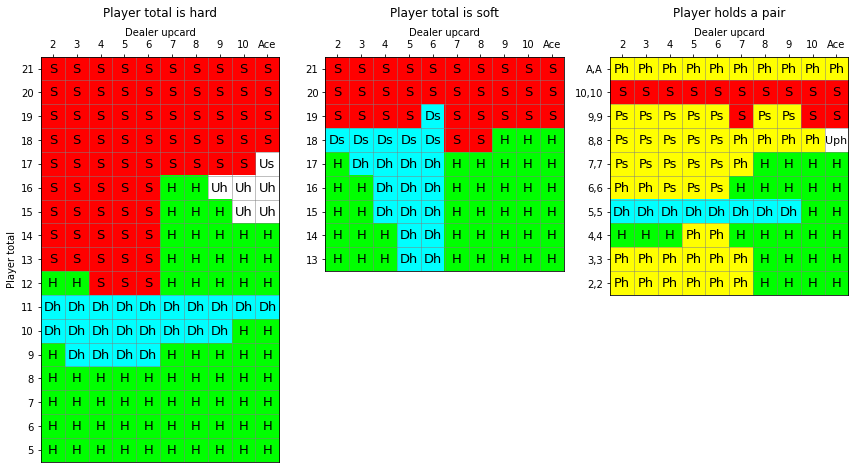

In [177]:
show_basic_strategy_tables(Rules.make())
verify_action_tables(Rules.make(), expected=EXPECTED_BASIC_STRATEGY_ACTION_6DECKS_H17)

The optimal actions exactly match those in the *basic strategy* tables shown in
[Wikipedia](https://en.wikipedia.org/wiki/Blackjack#Basic_strategy),
[WizardOfOdds](https://wizardofodds.com/games/blackjack/strategy/calculator/),
[VegasAces](https://www.vegas-aces.com/charts/blackjack-strategy-guides/), and
[BlackjackInfo](https://www.blackjackinfo.com/blackjack-basic-strategy-engine/?numdecks=6&soft17=h17&dbl=all&das=yes&surr=ls&peek=yes).

- Dealer stands on soft 17

We now consider the case where the dealer must **STAND on a soft 17** (which is favorable to
the player), still with the default of 6 decks.

Rules(hit_soft17=False)
Legend: (S)stand, (H)hit, (D)double, (P)split, (U)surrender; (Xy) means do X if allowed else Y.


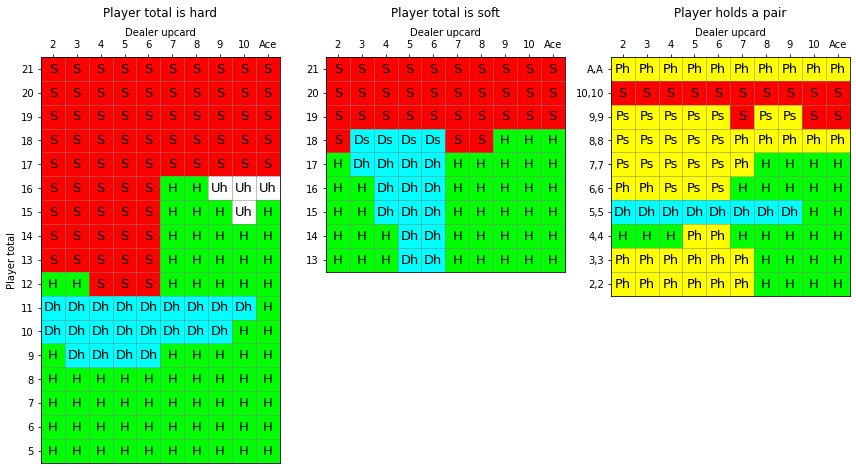

In [178]:
show_basic_strategy_tables(Rules.make(hit_soft17=False))
verify_action_tables(Rules.make(hit_soft17=False),
                     expected=EXPECTED_BASIC_STRATEGY_ACTION_6DECKS_S17)

The optimal actions exactly match those shown in
[WizardOfOdds](https://wizardofodds.com/games/blackjack/strategy/calculator/),
[VegasAces](https://www.vegas-aces.com/charts/blackjack-strategy-guides/), and
[BlackjackInfo](https://www.blackjackinfo.com/blackjack-basic-strategy-engine/?numdecks=6&soft17=s17&dbl=all&das=yes&surr=ls&peek=yes).

Compared to the "hit soft 17" case, the optimal actions for "stand soft 17" change in
exactly *6 cells*, in agreement with the
[Wikipedia](https://en.wikipedia.org/wiki/Blackjack#Basic_strategy)
description: "only 6 cells are changed: hit on 11 vs. A, hit on 15 vs. A, stand on 17 vs. A,
stand on A,7 vs. 2, stand on A,8 vs. 6, and split on 8,8 vs. A".

In [179]:
def table_difference_locations(tables1: Mapping[str, _NDArray],
                               tables2: Mapping[str, _NDArray]) -> dict[str, list[tuple[int, int]]]:
  """Identify the locations of any differing entries in table sets."""
  differences = {}
  for (name1, table1), (name2, table2) in zip(tables1.items(), tables2.items(), strict=True):
    check_eq(name1, name2)
    differences[name1] = np.argwhere(table1 != table2).tolist()
  return differences

In [180]:
check_eq(table_difference_locations(basic_strategy_tables(Rules.make()),
                                    basic_strategy_tables(Rules.make(hit_soft17=False))),
         {'hard': [[6, 9], [10, 9], [12, 9]], 'soft': [[5, 0], [6, 4]], 'pair': [[6, 9]]})

- The same actions computed above for 6 decks are also optimal for 4 decks and 8 decks,
as documented in Wikipedia:

In [181]:
if EFFORT >= 2:
  verify_action_tables(Rules.make(num_decks=4), expected=EXPECTED_BASIC_STRATEGY_ACTION_6DECKS_H17)
  verify_action_tables(Rules.make(num_decks=8), expected=EXPECTED_BASIC_STRATEGY_ACTION_6DECKS_H17)

- Interestingly, when moving to an infinite shoe, a single cell changes:
'soft 13 vs 5' changes from DOUBLE-OR-HIT `Dh` to HIT `H`.
(We are not aware of online house edge calculators that analyze the "infinite-shoe" case.)

In [182]:
if 0:
  show_basic_strategy_tables(Rules.make(num_decks=math.inf))


def verify_strategy_table_for_infinite_decks() -> None:
  """Check that the infinite-deck action table has a single differing entry."""
  tables_6 = basic_strategy_tables(Rules.make(num_decks=6))
  tables_inf = basic_strategy_tables(Rules.make(num_decks=math.inf))
  check_eq(table_difference_locations(tables_6, tables_inf),
           {'hard': [], 'soft': [[0, 3]], 'pair': []})
  check_eq(tables_6['soft'][0, 3], 'Dh')
  check_eq(tables_inf['soft'][0, 3], 'H')


verify_strategy_table_for_infinite_decks()

### Single deck

If using a single deck, many optimal actions change compared to the 6-deck setting.

- For the case **Dealer hits on soft 17**, 18 (5 + 4 + 9) table cells differ:

Rules(num_decks=1, cut_card=26)
Legend: (S)stand, (H)hit, (D)double, (P)split, (U)surrender; (Xy) means do X if allowed else Y.


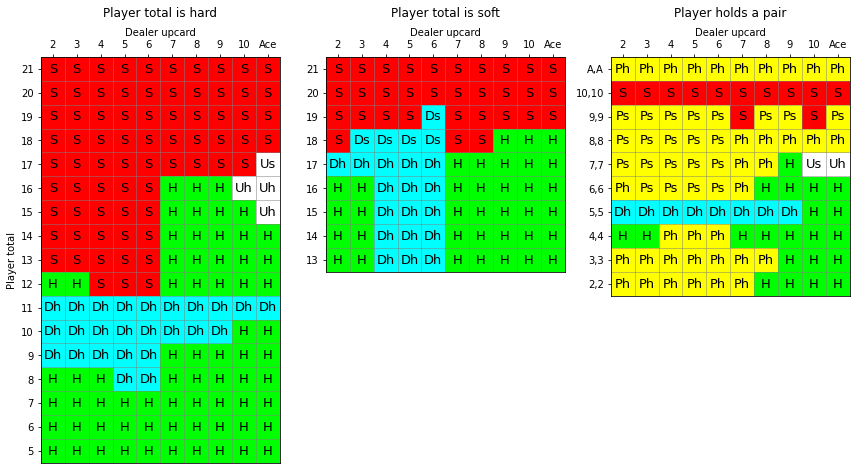

In [183]:
if EFFORT >= 2:
  show_basic_strategy_tables(Rules.make(num_decks=1))
  verify_action_tables(Rules.make(num_decks=1), expected=EXPECTED_BASIC_STRATEGY_ACTION_1DECK_H17)

The results are identical to those reported in
[WizardOfOdds](https://wizardofodds.com/games/blackjack/strategy/calculator/)
\(also [here](https://wizardofodds.com/games/blackjack/strategy/1-deck/)),
as well as
[BlackjackInfo](https://www.blackjackinfo.com/blackjack-basic-strategy-engine/?numdecks=1&soft17=h17&dbl=all&das=yes&surr=ls&peek=yes),
[BlackjackDoc](https://blackjackdoc.com/blackjack-basic-strategy.htm),
and [BlackjackReview](https://www.blackjackreview.com/wp/encyclopedia/single-deck/).

The table in
[mBitCasino](https://blog.mbitcasino.com/tips-to-win-multi-hand-blackjack/)
has a few obvious typos (some `Dh` should be `Ds`) and otherwise differs in only one cell:
- For 9-9 vs A, we have `SPLIT` (`P`) and they have `STAND` (`S`).

Let us take a closer look at this particular hand:

In [184]:
analyze_hand(((9, 9), 1), Rules.make(num_decks=1))

# hand=((9, 9), 1)  EFFORT=3
# Best_actions: bs=SPLIT id=SPLIT cd=SPLIT wiz=STAND bjstrat=SPLIT
#  STAND   id=-0.186130 sim=-0.186104±0.000076   cd=-0.186130  wiz:-0.186130  bjstrat:-0.186100
#  HIT     id=-0.637010 sim=-0.636997±0.000060   cd=-0.637010  wiz:-0.637010  bjstrat:-0.637000
#  DOUBLE  id=-1.274020 sim=-1.273988±0.000116   cd=-1.274020  wiz:-1.274020  bjstrat:-1.274000
#  SPLIT   id=-0.183912 sim=-0.183876±0.000124   cd=-0.183912  wiz:-0.189759* bjstrat:-0.183900

# We find SPLIT to be optimal when using basic strategy.  The rewards computed using the
# initial-dependent probabilistic analysis (id) and Monte Carlo simulation (sim) are close to each
# other and also to Bjstrat's hand calculator &mdash; all showing SPLIT as optimal (by a small
# margin).

# We exactly match the Bjstrat SPLIT result.

# The Wizard strategy table has SPLIT as the optimal basic-strategy action, whereas its hand
# calculator has STAND as the optimal composition-dependent action, mostly because the computed
# SPLIT reward differs significantly.

# hand=((9, 9), 1)  EFFORT=2
# Best_actions: bs=SPLIT id=SPLIT cd=SPLIT wiz=STAND bjstrat=SPLIT
#  STAND   id=-0.186130 sim=-0.186059±0.000239   cd=-0.186130  wiz:-0.186130  bjstrat:-0.186100
#  HIT     id=-0.637010 sim=-0.636836±0.000189   cd=-0.637010  wiz:-0.637010  bjstrat:-0.637000
#  DOUBLE  id=-1.274020 sim=-1.273704±0.000367   cd=-1.274020  wiz:-1.274020  bjstrat:-1.274000
#  SPLIT   id=-0.183028 sim=-0.183867±0.000391*  cd=-0.183028  wiz:-0.189759* bjstrat:-0.183900*


In [185]:
if 0:
  with temporary_effort(3):
    analyze_hand(((9, 9), 1), Rules.make(num_decks=1), actions=[Action.SPLIT])
# hand=((9, 9), 1)  EFFORT=4
#  SPLIT   id=-0.183940 sim=-0.183914±0.000039   cd=-0.183940  wiz:-0.189759* bjstrat:-0.183900

In [186]:
# Verify the 18 table cell differences with respect to the 6-deck strategy.
if EFFORT >= 2:
  check_eq(table_difference_locations(basic_strategy_tables(Rules.make(num_decks=6)),
                                      basic_strategy_tables(Rules.make(num_decks=1))),
           {'hard': [[3, 3], [3, 4], [4, 0], [10, 8], [11, 7]],
            'soft': [[0, 2], [1, 2], [4, 0], [5, 0]],
            'pair': [[1, 6], [2, 2], [4, 1], [4, 5], [5, 6], [5, 8], [5, 9], [6, 9], [7, 9]]})

- For the case **dealer stands on soft 17**:

Rules(num_decks=1, hit_soft17=False, cut_card=26)
Legend: (S)stand, (H)hit, (D)double, (P)split, (U)surrender; (Xy) means do X if allowed else Y.


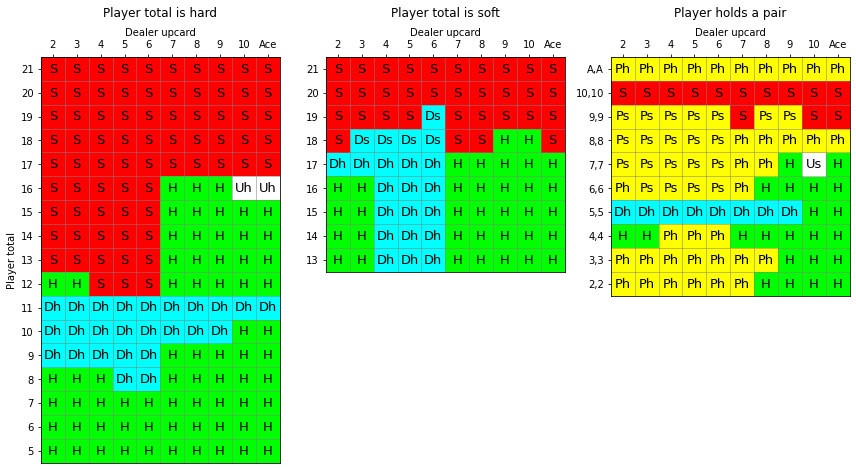

In [187]:
if EFFORT >= 2:
  show_basic_strategy_tables(Rules.make(num_decks=1, hit_soft17=False))
  verify_action_tables(Rules.make(num_decks=1, hit_soft17=False),
                       expected=EXPECTED_BASIC_STRATEGY_ACTION_1DECK_S17)

These results are identical to those reported in
[WizardOfOdds](https://wizardofodds.com/games/blackjack/strategy/calculator/)
\(also [here](https://wizardofodds.com/games/blackjack/strategy/1-deck/)),
[BlackjackInfo](https://www.blackjackinfo.com/blackjack-basic-strategy-engine/?numdecks=1&soft17=s17&dbl=all&das=yes&surr=ls&peek=yes), and
[BlackjackReview](https://www.blackjackreview.com/wp/encyclopedia/single-deck/).

Compared to
[BeatingBonuses](https://www.beatingbonuses.com/bjstrategy.php?decks2=1&h17=stand&doubleon2=any2cards&das2=on&peek2=on&surrender2=late&charlie2=no&resplits2=4&bj=3to2&opt2=1&btn2=Generate+Strategy),
there is just one differences:
- For hard 16 vs 10, we have `Uh` and they have `Us`.

The table in
[mBitCasino](https://blog.mbitcasino.com/tips-to-win-multi-hand-blackjack/)
has a few obvious typos (some `Dh` should be `Ds`) and otherwise differs in only one cell:
- For 7-7 vs 10, we have `Us` and they have `Uh`.

In [188]:
if EFFORT >= 1:
  analyze_hand(((6, 10), 10), Rules.make(num_decks=1, hit_soft17=False))
# As a fallback action (if SURRENDER is unavailable),  BeatingBonuses suggests STAND, which seems
# incorrect because HIT has a much higher reward than STAND according to all calculators.

# hand=((6, 10), 10)  EFFORT=3
# Best_actions: bs=SURRENDER id=SURRENDER cd=SURRENDER wiz=SURRENDER bjstrat=SURRENDER
#  STAND   id=-0.542952 sim=-0.542952±0.000056   cd=-0.542952  wiz:-0.542952  bjstrat:-0.543000
#  HIT     id=-0.506929 sim=-0.506970±0.000055   cd=-0.506929  wiz:-0.506929  bjstrat:-0.506900
#  DOUBLE  id=-1.013858 sim=-1.013959±0.000109   cd=-1.013858  wiz:-1.013858  bjstrat:-1.014000

# hand=((6, 10), 10)  EFFORT=2
# Best_actions: bs=SURRENDER id=SURRENDER cd=SURRENDER wiz=SURRENDER bjstrat=SURRENDER
#  STAND   id=-0.542952 sim=-0.542980±0.000177   cd=-0.542952  wiz:-0.542952  bjstrat:-0.543000
#  HIT     id=-0.506929 sim=-0.506734±0.000175   cd=-0.506929  wiz:-0.506929  bjstrat:-0.506900
#  DOUBLE  id=-1.013858 sim=-1.013519±0.000344   cd=-1.013858  wiz:-1.013858  bjstrat:-1.014000


In [189]:
if EFFORT >= 1:
  analyze_hand(((7, 7), 10), Rules.make(num_decks=1, hit_soft17=False))
# As a fallback action (if SURRENDER is unavailable),  mBitCasino suggests HIT, which seems
# incorrect because STAND has a higher reward than HIT according to all calculators.

# hand=((7, 7), 10)  EFFORT=3
# Best_actions: bs=SURRENDER id=SURRENDER cd=SURRENDER wiz=SURRENDER bjstrat=SURRENDER
#  STAND   id=-0.509739 sim=-0.509714±0.000058   cd=-0.509739  wiz:-0.509739  bjstrat:-0.509700
#  HIT     id=-0.514818 sim=-0.514789±0.000055   cd=-0.514818  wiz:-0.514818  bjstrat:-0.514800
#  DOUBLE  id=-1.034724 sim=-1.034703±0.000108   cd=-1.034724  wiz:-1.034724  bjstrat:-1.035000
#  SPLIT   id=-0.622662 sim=-0.622647±0.000107   cd=-0.619716  wiz:-0.620390* bjstrat:-0.619800

# hand=((7, 7), 10)  EFFORT=2
# Best_actions: bs=SURRENDER id=SURRENDER cd=SURRENDER wiz=SURRENDER bjstrat=SURRENDER
#  STAND   id=-0.509739 sim=-0.509784±0.000182   cd=-0.509739  wiz:-0.509739  bjstrat:-0.509700
#  HIT     id=-0.514818 sim=-0.514782±0.000173   cd=-0.514818  wiz:-0.514818  bjstrat:-0.514800
#  DOUBLE  id=-1.034724 sim=-1.034569±0.000342   cd=-1.034724  wiz:-1.034724  bjstrat:-1.035000
#  SPLIT   id=-0.622546 sim=-0.622374±0.000337   cd=-0.619444  wiz:-0.620390* bjstrat:-0.619800*


### No dealer peek for bj

(I.e. `obo=False` &mdash; the player loss is not limited to "original bet only".)

From [WizardOfOdds](https://wizardofodds.com/play/blackjack/),
"the only time you should put more money out on the table against a
potential dealer blackjack is to split two aces against a dealer 10."

This
[calculator](https://wizardofodds.com/games/blackjack/strategy/calculator/)
shows that one should often surrender when the dealer upcard is 1 (ace)
unless surrender is constrained to be "Surrender against 2 to 10".
This
[site](https://www.blackjackclassroom.com/blackjack-games/european-blackjack)
explains that for European Blackjack (where `obo=False`),
"Players cannot usually surrender if the dealer's face card is an Ace".

Our implementation assumes a "late surrender" whereby a dealer bj still wins
over a player surrender.  This could be incorrect for European blackjack if the
dealer hole card is never dealt after the player surrenders;
the situation is unclear.

Rules(obo=False)
Legend: (S)stand, (H)hit, (D)double, (P)split, (U)surrender; (Xy) means do X if allowed else Y.


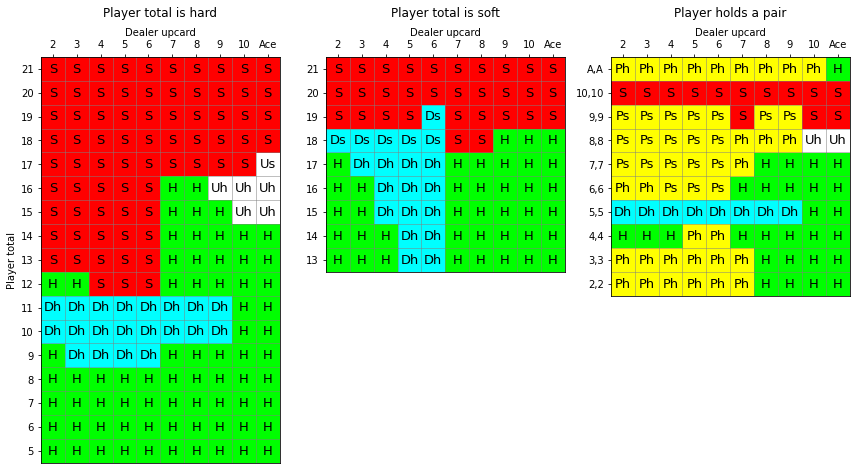

In [190]:
def show_and_check_obo_false() -> None:
  """Show strategy when player loses added bets (SPLIT/DOUBLE) to dealer bj."""
  rules = Rules.make(num_decks=6, obo=False)
  show_basic_strategy_tables(rules)
  for name, table in basic_strategy_tables(rules).items():
    code = np.array2string(table[:, -2:]).lower()
    # Verify that there is no DOUBLE action against dealer1 1 or 10.
    assert 'd' not in code
    # There is only one SPLIT action (two aces against dealer 10):
    check_eq(code.count('p'), {'hard': 0, 'soft': 0, 'pair': 1}[name])


if EFFORT >= 2:
  show_and_check_obo_false()

## Composition-dependent strategy

When determining the best action, it is slightly beneficial to consider
the individual card values `(card1, card2)` rather than just `(player_total, player_soft)`
as in basic strategy, particularly when the number of decks is small.

From Wikipedia: "For example, players should ordinarily STAND when holding 12 against a dealer 4.
But in a single deck game, players should HIT if their 12 consists of a 10 and a 2."

In [191]:
def analyze_differences_using_composition_dependent_strategy(
    rules: Rules, verbose: bool = True) -> None:
  """Find any hands where a composition-dependent strategy has optimal actions that differ from
  those in the basic strategy, for various numbers of decks."""
  for index, num_decks in enumerate([6, 4, 2, 1]):
    if EFFORT <= 1 and num_decks == 1:
      continue
    modified_rules = dataclasses.replace(
        rules, num_decks=num_decks, cut_card=default_cut_card(num_decks))
    if verbose:
      if index:
        print()
      print(f'# For {num_decks=}:')
      print('#   card1  card2  dealer_up  basic_strategy  composition_dependent')
    differences = []

    for card1, card2 in generate_all_initial_cards():
      for dealer1 in range(1, 11):
        hand = (card1, card2), dealer1
        state = hand[0], hand[1], ()
        bs_action = get_best_action(state, modified_rules, BASIC_STRATEGY)
        cd_action = get_best_action(state, modified_rules, COMPOSITION_DEPENDENT_STRATEGY)
        if bs_action is cd_action:
          continue
        if verbose:
          print(f'#    {card1:2} {card2:6} {dealer1:8}'
                f'        {bs_action.name:^9}         {cd_action.name:^9}'.rstrip())
        differences.append((hand, bs_action, cd_action))

    if EFFORT >= 1:
      expected = EXPECTED_COMPOSITION_DEPENDENT_DIFFERENCES[num_decks]
      if differences != expected:
        print(f'{differences} != {expected}', file=sys.stderr)


analyze_differences_using_composition_dependent_strategy(Rules.make())
# For num_decks=6:
#   card1  card2  dealer_up  basic_strategy  composition_dependent
#     7      8       10        SURRENDER            HIT

# For num_decks=4:
#   card1  card2  dealer_up  basic_strategy  composition_dependent
#     7      8       10        SURRENDER            HIT

# For num_decks=2:
#   card1  card2  dealer_up  basic_strategy  composition_dependent
#     2     10        4          STAND              HIT
#     4      8        3           HIT              STAND
#     5      7        3           HIT              STAND
#     7      8        1        SURRENDER            HIT
#     7      8       10        SURRENDER            HIT

# For num_decks=1:
#   card1  card2  dealer_up  basic_strategy  composition_dependent
#     2      6        6         DOUBLE              HIT
#     2     10        4          STAND              HIT
#     4      8        3           HIT              STAND
#     5      7        3           HIT              STAND
#     5     10       10           HIT            SURRENDER
#     6      9       10           HIT            SURRENDER
#     7      8        1        SURRENDER            HIT
#     8      9        1        SURRENDER           STAND

# For num_decks=6:
#   card1  card2  dealer_up  basic_strategy  composition_dependent
#     7      8       10        SURRENDER            HIT

# For num_decks=4:
#   card1  card2  dealer_up  basic_strategy  composition_dependent
#     7      8       10        SURRENDER            HIT

# For num_decks=2:
#   card1  card2  dealer_up  basic_strategy  composition_dependent
#     2     10        4          STAND              HIT
#     4      8        3           HIT              STAND
#     5      7        3           HIT              STAND
#     7      8        1        SURRENDER            HIT
#     7      8       10        SURRENDER            HIT

# For num_decks=1:
#   card1  card2  dealer_up  basic_strategy  composition_dependent
#     2      6        6         DOUBLE              HIT
#     2     10        4          STAND              HIT
#     4      8        3           HIT              STAND
#     5      7        3           HIT              STAND
#     5     10       10          

- We take a closer look at three of these hands:

Here, `bs` is basic strategy, `id` is initial-card-dependent strategy,
`cd` is composition-dependent strategy, `wiz` is WizardOfOdds, and `bjstrat` is bjstrat.net.

In [192]:
if EFFORT >= 2:
  analyze_hand(((7, 8), 10), Rules.make(num_decks=6))
# For this hand, the basic strategy (total-dependent) optimal action is SURRENDER, whereas the
# initial-dependent and composition-dependent strategies show the optimal action to be HIT.

# hand=((7, 8), 10)  EFFORT=3
# Best_actions: bs=SURRENDER id=HIT cd=HIT wiz=HIT bjstrat=HIT
#  STAND   id=-0.536220 sim=-0.536267±0.000056   cd=-0.536220  wiz:-0.536220  bjstrat:-0.536200
#  HIT     id=-0.499763 sim=-0.499757±0.000055   cd=-0.499763  wiz:-0.499763  bjstrat:-0.499800
#  DOUBLE  id=-0.999525 sim=-0.999494±0.000109   cd=-0.999525  wiz:-0.999525  bjstrat:-0.999500

# hand=((7, 8), 10)  EFFORT=2
# Best_actions: bs=SURRENDER id=HIT cd=HIT wiz=HIT bjstrat=HIT
#  STAND   id=-0.536220 sim=-0.536226±0.000178   cd=-0.536220  wiz:-0.536220  bjstrat:-0.536200
#  HIT     id=-0.499763 sim=-0.499734±0.000175   cd=-0.499763  wiz:-0.499763  bjstrat:-0.499800
#  DOUBLE  id=-0.999525 sim=-0.999411±0.000346   cd=-0.999525  wiz:-0.999525  bjstrat:-0.999500


In [193]:
if EFFORT >= 2:
  analyze_hand(((2, 10), 4), Rules.make(num_decks=2))
# For this hand, the basic strategy (total-dependent) optimal action is STAND, whereas the
# initial-dependent and composition-dependent strategies show the optimal action to be HIT.

# hand=((2, 10), 4)  EFFORT=3
# Best_actions: bs=STAND id=HIT cd=HIT wiz=HIT bjstrat=HIT
#  STAND   id=-0.206125 sim=-0.206140±0.000062   cd=-0.206125  wiz:-0.206125  bjstrat:-0.206100
#  HIT     id=-0.204205 sim=-0.204185±0.000060   cd=-0.204205  wiz:-0.204205  bjstrat:-0.204200
#  DOUBLE  id=-0.408411 sim=-0.408371±0.000121   cd=-0.408411  wiz:-0.408411  bjstrat:-0.408400

# hand=((2, 10), 4)  EFFORT=2
# Best_actions: bs=STAND id=HIT cd=HIT wiz=HIT bjstrat=HIT
#  STAND   id=-0.206125 sim=-0.206185±0.000196   cd=-0.206125  wiz:-0.206125  bjstrat:-0.206100
#  HIT     id=-0.204205 sim=-0.204120±0.000191   cd=-0.204205  wiz:-0.204205  bjstrat:-0.204200
#  DOUBLE  id=-0.408411 sim=-0.408240±0.000382   cd=-0.408411  wiz:-0.408411  bjstrat:-0.408400


In [194]:
if EFFORT >= 2:
  analyze_hand(((2, 6), 6), Rules.make(num_decks=1))
# For this hand, the basic strategy (total-dependent) optimal action is DOUBLE, whereas the
# initial-dependent and composition-dependent strategies show the optimal action to be HIT.

# hand=((2, 6), 6)  EFFORT=3
# Best_actions: bs=DOUBLE id=HIT cd=HIT wiz=HIT bjstrat=HIT
#  STAND   id=-0.108450 sim=-0.108444±0.000063   cd=-0.108450  wiz:-0.108450  bjstrat:-0.108500
#  HIT     id= 0.119677 sim= 0.119727±0.000061   cd= 0.119677  wiz: 0.119677  bjstrat: 0.119700
#  DOUBLE  id= 0.111237 sim= 0.111310±0.000123   cd= 0.111237  wiz: 0.111237  bjstrat: 0.111200

# hand=((2, 6), 6)  EFFORT=2
# Best_actions: bs=DOUBLE id=HIT cd=HIT wiz=HIT bjstrat=HIT
#  STAND   id=-0.108450 sim=-0.108509±0.000199   cd=-0.108450  wiz:-0.108450  bjstrat:-0.108500
#  HIT     id= 0.119677 sim= 0.119710±0.000192   cd= 0.119677  wiz: 0.119677  bjstrat: 0.119700
#  DOUBLE  id= 0.111237 sim= 0.111299±0.000388   cd= 0.111237  wiz: 0.111237  bjstrat: 0.111200


In [195]:
# Quick sanity check on Monte Carlo simulation.
_value, _value_sdv = monte_carlo_hand(((2, 6), 6), Rules.make(num_decks=1), Strategy(), 10_000_000)
print(_value, _value_sdv)  # 0.11065 1.9423796114003709  EFFORT=0,1,2,3
assert 0.10 < _value < 0.12
assert 1.94 < _value_sdv < 1.95

0.11065 1.9423796114003709


## Hand calculator results
<a name="Hand-calculator-results"></a>

In [196]:
def find_significant_reward_differences_across_hand_calculators(rules: Rules) -> None:
  """Look for differences across hand calculators on all initial hands."""
  strategy = COMPOSITION_DEPENDENT_STRATEGY
  num_differences = 0
  for action, (card1, card2), dealer1 in itertools.product(
      Action, generate_all_initial_cards(), range(1, 11)):
    hand = (card1, card2), dealer1
    state = hand[0], hand[1], ()
    cd_reward = post_peek_reward_for_action(state, rules, strategy, action)
    for name, hand_calc in HAND_CALCULATORS.items():
      reward = hh.assert_not_none(hand_calc(hand, action, rules))
      # The Bjstrat results report exactly 4 digits.
      # The Wizard results report 16 digits, and seem precise up to 6 digits.
      # The SPLIT rewards have large differences, so we increase their tolerance.
      tolerance = ({'bjstrat': 0.0003, 'wiz': 0.004}[name] if action is Action.SPLIT else
                   {'bjstrat': (0.00056 if abs(reward) > 1.0 else 0.000056), 'wiz': 0.6e-6}[name])
      difference = reward - cd_reward
      if abs(difference) > tolerance:
        if num_differences < 40:
          print(f'# For {hand!s:<14} {action.name:<9}: cd={cd_reward: .6f}'
                f' {name:>7}={reward: .6f}  diff={difference: .6f}')
        num_differences += 1
  print(f'# Found {num_differences=}')

In [197]:
if EFFORT >= 3:
  with temporary_effort(3):  # ~300 s  (EFFORT=3 ~42 s)
    find_significant_reward_differences_across_hand_calculators(Rules.make(num_decks=1))

# Great &mdash; for all actions except SPLIT, we exactly reproduce the rewards of Wizard
# with 6 digits of precision,
# and we reproduce the rewards of Bjstrat (with their 4 digits of precision)!

# For the SPLIT actions, there are differences.
# Setting our strategy to COMPOSITION_DEPENDENT_STRATEGY (Attention.HAND_AND_NUM_PRIOR_SPLITS),
# our results are close to the 'bjstrat' results &mdash;- with only 8 reward values
# having differences exceeding 0.0003.
# And for all those 8 numbers, at EFFORT=4, our rewards are consistently a little higher.
# The differences are likely due to details in state-tracking between the multiple split hands.

# The Wizard SPLIT results are significantly different and moreover they differ from our
# Monte Carlo simulation results.  (See for example `test_some_split_hands1()` and
# `analyze_hand(((9, 9), 1), Rules.make(num_decks=1))` later in this section.)

# For ((3, 3), 1)    SPLIT    : cd=-0.536496 bjstrat=-0.536800  diff=-0.000304
# For ((4, 4), 1)    SPLIT    : cd=-0.608214     wiz=-0.604158  diff= 0.004056
# For ((4, 4), 1)    SPLIT    : cd=-0.608214 bjstrat=-0.608600  diff=-0.000386
# For ((4, 4), 7)    SPLIT    : cd=-0.178137 bjstrat=-0.178500  diff=-0.000363
# For ((6, 6), 1)    SPLIT    : cd=-0.678721     wiz=-0.673866  diff= 0.004855
# For ((6, 6), 1)    SPLIT    : cd=-0.678721 bjstrat=-0.679300  diff=-0.000579
# For ((6, 6), 10)   SPLIT    : cd=-0.658883 bjstrat=-0.659300  diff=-0.000417
# For ((7, 7), 1)    SPLIT    : cd=-0.674180     wiz=-0.669831  diff= 0.004349
# For ((9, 9), 1)    SPLIT    : cd=-0.183940     wiz=-0.189759  diff=-0.005819
# For ((10, 10), 1)  SPLIT    : cd=-0.495613     wiz=-0.445244  diff= 0.050369
# For ((10, 10), 2)  SPLIT    : cd= 0.045064     wiz= 0.079724  diff= 0.034660
# For ((10, 10), 2)  SPLIT    : cd= 0.045064 bjstrat= 0.044630  diff=-0.000434
# For ((10, 10), 3)  SPLIT    : cd= 0.127314     wiz= 0.159177  diff= 0.031864
# For ((10, 10), 4)  SPLIT    : cd= 0.224754     wiz= 0.252190  diff= 0.027436
# For ((10, 10), 4)  SPLIT    : cd= 0.224754 bjstrat= 0.224200  diff=-0.000554
# For ((10, 10), 5)  SPLIT    : cd= 0.332634     wiz= 0.358542  diff= 0.025908
# For ((10, 10), 6)  SPLIT    : cd= 0.354632     wiz= 0.379925  diff= 0.025294
# For ((10, 10), 6)  SPLIT    : cd= 0.354632 bjstrat= 0.351500  diff=-0.003132
# For ((10, 10), 7)  SPLIT    : cd= 0.251783     wiz= 0.304030  diff= 0.052247
# For ((10, 10), 8)  SPLIT    : cd= 0.011765     wiz= 0.076675  diff= 0.064910
# For ((10, 10), 9)  SPLIT    : cd=-0.255830     wiz=-0.183090  diff= 0.072740
# For ((10, 10), 10) SPLIT    : cd=-0.315144     wiz=-0.262691  diff= 0.052453
# Found num_differences=22

In [198]:
if 0:
  with temporary_effort(3):  # ~300 s
    find_significant_reward_differences_across_hand_calculators(
        Rules.make(num_decks=1, obo=False, late_surrender=False))
# [The results are very similar to the set of differences above.]
# Found num_differences=18

In [199]:
if 0:
  with temporary_effort(3):  # ~300 s
    find_significant_reward_differences_across_hand_calculators(
        Rules.make(num_decks=1, hit_soft17=False))
# [The results are again very similar to the set of differences above.]
# Found num_differences=19

<a name="analyze-hand-action-wrt-attention"><a>
- Here we see how the hand reward increases monotonically with the increase in `Attention`
  of the player strategy:

In [200]:
def analyze_hand_action_wrt_attention(hand: Hand, action: Action, rules: Rules) -> None:
  """Show reward for `action` on `hand` with progressively more expansive attention settings."""
  state = hand[0], hand[1], ()
  print(f'# Hand={hand!s:<14} {EFFORT=}:')
  for attention in Attention:
    strategy = Strategy(attention=attention)
    reward = post_peek_reward_for_action(state, rules, strategy, action)
    print(f'# {attention.name:38.38} {reward: .6f}')
  for name, hand_calc in HAND_CALCULATORS.items():
    hand_calc_reward = hand_calc(hand, action, rules)
    if hand_calc_reward is not None:
      print(f'# {name:38} {hand_calc_reward: .6f}')


if EFFORT >= 3:
  analyze_hand_action_wrt_attention(((10, 10), 4), Action.SPLIT, Rules.make(num_decks=1))
  with temporary_effort(3):
    print()
    analyze_hand_action_wrt_attention(((10, 10), 4), Action.SPLIT, Rules.make(num_decks=1))

# Observations:
# (1) The computed rewards can depend significantly on pruning heuristics (e.g., EFFORT).
#     At EFFORT=3, our result with HAND_AND_NUM_PRIOR_SPLITS lies below the Bjstrat reward.
#     At EFFORT=4, our result with HAND_AND_NUM_PRIOR_SPLITS lies above the Bjstrat reward.
# (2) Our results with Attention.HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS show a small increase
#     compared to Attention.HAND_AND_NUM_PRIOR_SPLITS.

# Hand=((10, 10), 4)  EFFORT=3:
# TOTAL_OF_CARDS                          0.205199
# INITIAL_CARDS_OR_TOTAL                  0.221038
# INITIAL_CARDS_AND_TOTAL                 0.221038
# HAND_CARDS_ONLY                         0.221038
# HAND_AND_NUM_PRIOR_SPLITS               0.221787
# HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS  0.222017
# wiz                                     0.252190
# bjstrat                                 0.224200

# Hand=((10, 10), 4)  EFFORT=4:
# TOTAL_OF_CARDS                          0.208732
# INITIAL_CARDS_OR_TOTAL                  0.224162
# INITIAL_CARDS_AND_TOTAL                 0.224162
# HAND_CARDS_ONLY                         0.224162
# HAND_AND_NUM_PRIOR_SPLITS               0.224754
# HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS  0.225450
# wiz                                     0.252190
# bjstrat                                 0.224200

In [201]:
def demonstrate_importance_of_knowing_prior_split_cards(
    hand: Hand, rules: Rules = Rules.make(num_decks=1),
    strategy: Strategy = Strategy(attention=Attention.HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS),
    action: Action = Action.HIT) -> None:
  """Show that the hand reward depends greatly on knowledge of cards from prior splits."""
  card1, card2, card3 = hand[0][0], 9, 6
  for split_cards in [(), (card1,), (card1, card1), (card1, card1, card1),
                      (card1, card2), (card1, card1, card2, card2),
                      (card1, card1, card1, card2, card2, card2),
                      (card1, card1, card1, card3, card3, card3)]:
    state = hand[0], hand[1], split_cards
    reward = reward_for_action(state, rules, strategy, action)
    print(f'# {hand=!s:14} {split_cards=!s:25} {reward=: .6f}')


demonstrate_importance_of_knowing_prior_split_cards(((3, 10), 2))
# We consider the case that the initial hand is a pair (3, 3) and we split the pair (and
# split again if we draw another 3.)
# The results below show that when the initial cards of prior split hand(s) are (3, 9), the
# expected reward on the current hand increases significantly.
# In contrast, when the initial cards of prior split hand(s) are (3, 6), the expected reward
# on the current hand decreases significantly.
# This provides motivation for including `split_cards` as an entry in the `state` used in the
# probabilistic analysis.

# For EFFORT=3:
# hand=((3, 10), 2)   split_cards=()                        reward=-0.305033
# hand=((3, 10), 2)   split_cards=(3,)                      reward=-0.306271
# hand=((3, 10), 2)   split_cards=(3, 3)                    reward=-0.307826
# hand=((3, 10), 2)   split_cards=(3, 3, 3)                 reward=-0.309679
# hand=((3, 10), 2)   split_cards=(3, 9)                    reward=-0.284842
# hand=((3, 10), 2)   split_cards=(3, 3, 9, 9)              reward=-0.262627
# hand=((3, 10), 2)   split_cards=(3, 3, 3, 9, 9, 9)        reward=-0.234007
# hand=((3, 10), 2)   split_cards=(3, 3, 3, 6, 6, 6)        reward=-0.344034

# hand=((3, 10), 2)   split_cards=()                        reward=-0.305034
# hand=((3, 10), 2)   split_cards=(3,)                      reward=-0.306274
# hand=((3, 10), 2)   split_cards=(3, 3)                    reward=-0.307857
# hand=((3, 10), 2)   split_cards=(3, 3, 3)                 reward=-0.309898
# hand=((3, 10), 2)   split_cards=(3, 9)                    reward=-0.284887
# hand=((3, 10), 2)   split_cards=(3, 3, 9, 9)              reward=-0.263210
# hand=((3, 10), 2)   split_cards=(3, 3, 3, 9, 9, 9)        reward=-0.242723
# hand=((3, 10), 2)   split_cards=(3, 3, 3, 6, 6, 6)        reward=-0.347569


In [202]:
look_for_hands_with_differences_in_calculated_optimal_actions(
    Rules.make(num_decks=2), expected_differences=([] if EFFORT >= 2 else None))

# Wonderful: for a 2-deck shoe, with EFFORT>=2, there are no differences in optimal
# full-composition-strategy actions wrt to Wizard and Bjstrat.
# (For EFFORT=1, there are about 3 differences.)

In [203]:
look_for_hands_with_differences_in_calculated_optimal_actions(
    Rules.make(num_decks=1), expected_differences=([((9, 9), 1)] if EFFORT >= 2 else None))

# Wonderful: for a 1-deck shoe, with EFFORT>=2, the only difference in optimal
# full-composition-strategy actions wrt to Wizard and Bjstrat is a single hand:
#
# hand=((9, 9), 1)  EFFORT=3
#  cd     : SPLIT:-0.183912 STAND:-0.186130 SURRENDER:-0.500000 HIT:-0.637010 DOUBLE:-1.274020
#  wiz    : STAND:-0.186130 SPLIT:-0.189759 SURRENDER:-0.500000 HIT:-0.637010 DOUBLE:-1.274020
#  bjstrat: SPLIT:-0.183900 STAND:-0.186100 SURRENDER:-0.500000 HIT:-0.637000 DOUBLE:-1.274000

# This seems to be due to the imprecise reward computation for SPLIT by Wizard.

# Our SPLIT reward -0.1839 is higher than Wizard -0.1898 but equal to Bjstrat.
# The sim=-0.1839±0.0001 in the cell below provides additional support that Bjstrat and our cd
# are likely correct.  (Bjstrat shows SPL1=-0.1860 SPL2=-0.1841 SPL3=-0.1839).

# (With EFFORT=1 there are about 6 differences.)

# hand=((9, 9), 1)  EFFORT=2
#  cd     : SPLIT:-0.183028 STAND:-0.186130 SURRENDER:-0.500000 HIT:-0.637010 DOUBLE:-1.274020
#  wiz    : STAND:-0.186130 SPLIT:-0.189759 SURRENDER:-0.500000 HIT:-0.637010 DOUBLE:-1.274020
#  bjstrat: SPLIT:-0.183900 STAND:-0.186100 SURRENDER:-0.500000 HIT:-0.637000 DOUBLE:-1.274000


In [204]:
# Here is a closer look at that particular hand:
analyze_hand(((9, 9), 1), Rules.make(num_decks=1))

# Our results accurately match Bjstrat.

# hand=((9, 9), 1)  EFFORT=3
# Best_actions: bs=SPLIT id=SPLIT cd=SPLIT wiz=STAND bjstrat=SPLIT
#  STAND   id=-0.186130 sim=-0.186104±0.000076   cd=-0.186130  wiz:-0.186130  bjstrat:-0.186100
#  HIT     id=-0.637010 sim=-0.636997±0.000060   cd=-0.637010  wiz:-0.637010  bjstrat:-0.637000
#  DOUBLE  id=-1.274020 sim=-1.273988±0.000116   cd=-1.274020  wiz:-1.274020  bjstrat:-1.274000
#  SPLIT   id=-0.183912 sim=-0.183876±0.000124   cd=-0.183912  wiz:-0.189759* bjstrat:-0.183900

# hand=((9, 9), 1)  EFFORT=2
# Best_actions: bs=SPLIT id=SPLIT cd=SPLIT wiz=STAND bjstrat=SPLIT
#  STAND   id=-0.186130 sim=-0.186059±0.000239   cd=-0.186130  wiz:-0.186130  bjstrat:-0.186100
#  HIT     id=-0.637010 sim=-0.636836±0.000189   cd=-0.637010  wiz:-0.637010  bjstrat:-0.637000
#  DOUBLE  id=-1.274020 sim=-1.273704±0.000367   cd=-1.274020  wiz:-1.274020  bjstrat:-1.274000
#  SPLIT   id=-0.183028 sim=-0.183867±0.000391*  cd=-0.183028  wiz:-0.189759* bjstrat:-0.183900*


In [205]:
if 0:
  with temporary_effort(3):  # ~1700 s.
    analyze_hand(((9, 9), 1), Rules.make(num_decks=1))
# hand=((9, 9), 1)  EFFORT=4
# Best_actions: bs=SPLIT id=SPLIT cd=SPLIT wiz=STAND bjstrat=SPLIT
#  STAND   id=-0.186130 sim=-0.186118±0.000024   cd=-0.186130  wiz:-0.186130  bjstrat:-0.186100
#  HIT     id=-0.637010 sim=-0.636995±0.000019   cd=-0.637010  wiz:-0.637010  bjstrat:-0.637000
#  DOUBLE  id=-1.274020 sim=-1.273989±0.000037   cd=-1.274020  wiz:-1.274020  bjstrat:-1.274000
#  SPLIT   id=-0.183940 sim=-0.183914±0.000039   cd=-0.183940  wiz:-0.189759* bjstrat:-0.183900

In [206]:
look_for_hands_with_differences_in_calculated_optimal_actions(
    Rules.make(num_decks=1, hit_soft17=False), expected_differences=([] if EFFORT >= 2 else None))

# This time, we consider the case of 1 deck with "dealer stand on soft 17".
# Wonderful: with EFFORT>=2, there are *no* differences in optimal composition-dependent actions
# wrt to both Wizard and Bjstrat.

# (With EFFORT=1 there are about 4 differences.)

In [207]:
def test_some_split_hands1(actions: Iterable[Action] = ()) -> None:
  """Compare split rewards on (10, 10) hands with other hand calculators."""
  for dealer1 in [9, 10, 1]:
    print()
    analyze_hand(((10, 10), dealer1), Rules.make(num_decks=1), actions=actions)

In [208]:
if EFFORT >= 1:
  test_some_split_hands1()
# The rewards only differ for SPLIT, where both the 'cd' (probabilistic) and 'sim' (Monte Carlo)
# results are a reasonably close match to Bjstrat.  The 'sim' result has only a limited attention
# (INITIAL_CARDS_AND_TOTAL) and the probabilistic 'cd' and Bjstrat results do not consider
# all cards from prior split hands, so both types of results have small inaccuracies.

# hand=((10, 10), 9)  EFFORT=3
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 0.743970 sim= 0.743986±0.000036   cd= 0.743970  wiz: 0.743970  bjstrat: 0.744000
#  HIT     id=-0.842055 sim=-0.842059±0.000034   cd=-0.842055  wiz:-0.842055  bjstrat:-0.842100
#  DOUBLE  id=-1.684111 sim=-1.684118±0.000068   cd=-1.684111  wiz:-1.684111  bjstrat:-1.684000
#  SPLIT   id=-0.255864 sim=-0.255824±0.000105   cd=-0.255864  wiz:-0.183090* bjstrat:-0.255800

# hand=((10, 10), 10)  EFFORT=3
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 0.583154 sim= 0.583212±0.000048   cd= 0.583154  wiz: 0.583154  bjstrat: 0.583200
#  HIT     id=-0.836969 sim=-0.836965±0.000036   cd=-0.836969  wiz:-0.836969  bjstrat:-0.837000
#  DOUBLE  id=-1.673938 sim=-1.673949±0.000073   cd=-1.673938  wiz:-1.673938  bjstrat:-1.674000
#  SPLIT   id=-0.315639 sim=-0.316433±0.000114*  cd=-0.314259  wiz:-0.262691* bjstrat:-0.315300*

# hand=((10, 10), 1)  EFFORT=3
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 0.593596 sim= 0.593605±0.000081   cd= 0.593596  wiz: 0.593596  bjstrat: 0.593600
#  HIT     id=-0.884336 sim=-0.884326±0.000035   cd=-0.884336  wiz:-0.884336  bjstrat:-0.884300
#  DOUBLE  id=-1.768673 sim=-1.768660±0.000075   cd=-1.768673  wiz:-1.768673  bjstrat:-1.769000
#  SPLIT   id=-0.497143 sim=-0.495826±0.000120*  cd=-0.497141  wiz:-0.445244* bjstrat:-0.495800*


# hand=((10, 10), 9)  EFFORT=2
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 0.743970 sim= 0.744038±0.000113   cd= 0.743970  wiz: 0.743970  bjstrat: 0.744000
#  HIT     id=-0.842055 sim=-0.842039±0.000107   cd=-0.842055  wiz:-0.842055  bjstrat:-0.842100
#  DOUBLE  id=-1.684111 sim=-1.684078±0.000214   cd=-1.684111  wiz:-1.684111  bjstrat:-1.684000
#  SPLIT   id=-0.254449 sim=-0.255803±0.000333*  cd=-0.254449  wiz:-0.183090* bjstrat:-0.255800*

# hand=((10, 10), 10)  EFFORT=2
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 0.583154 sim= 0.583203±0.000153   cd= 0.583154  wiz: 0.583154  bjstrat: 0.583200
#  HIT     id=-0.836969 sim=-0.836922±0.000114   cd=-0.836969  wiz:-0.836969  bjstrat:-0.837000
#  DOUBLE  id=-1.673938 sim=-1.673894±0.000231   cd=-1.673938  wiz:-1.673938  bjstrat:-1.674000
#  SPLIT   id=-0.311284 sim=-0.316434±0.000361*  cd=-0.309654  wiz:-0.262691* bjstrat:-0.315300*

# hand=((10, 10), 1)  EFFORT=2

In [209]:
if 0:
  with temporary_effort(3):
    test_some_split_hands1(actions=[Action.SPLIT])
# hand=((10, 10), 9)  EFFORT=4
#  SPLIT   id=-0.255830 sim=-0.255837±0.000033   cd=-0.255830  wiz:-0.183090* bjstrat:-0.255800
# hand=((10, 10), 10)  EFFORT=4
#  SPLIT   id=-0.316452 sim=-0.316442±0.000036   cd=-0.315144  wiz:-0.262691* bjstrat:-0.315300*
# hand=((10, 10), 1)  EFFORT=4
#  SPLIT   id=-0.495792 sim=-0.495781±0.000038   cd=-0.495613  wiz:-0.445244* bjstrat:-0.495800*

In [210]:
def test_some_split_hands2(dealer1: int = 10) -> None:
  """Compare split rewards with other hand calculators, for a specified dealer upcard."""
  for card1 in range(1, 11):
    card2 = card1
    # Only the SPLIT results differ.
    analyze_hand(((card1, card2), dealer1), Rules.make(num_decks=1), actions=[Action.SPLIT])

In [211]:
if EFFORT >= 1:
  test_some_split_hands2()
# The paired tens against dealer 10 is particularly challenging to compute accurately.

# hand=((1, 1), 10)  EFFORT=3
#  SPLIT   id= 0.194251 sim= 0.194307±0.000094   cd= 0.194251  wiz: 0.194251  bjstrat: 0.194300
# hand=((2, 2), 10)  EFFORT=3
#  SPLIT   id=-0.466571 sim=-0.466530±0.000106   cd=-0.466378  wiz:-0.467223* bjstrat:-0.466400
# hand=((3, 3), 10)  EFFORT=3
#  SPLIT   id=-0.506204 sim=-0.506173±0.000105   cd=-0.505608  wiz:-0.506252* bjstrat:-0.505600
# hand=((4, 4), 10)  EFFORT=3
#  SPLIT   id=-0.586839 sim=-0.586779±0.000104   cd=-0.586720  wiz:-0.587695* bjstrat:-0.586700
# hand=((5, 5), 10)  EFFORT=3
#  SPLIT   id=-0.723690 sim=-0.723627±0.000103   cd=-0.723160  wiz:-0.724627* bjstrat:-0.723400*
# hand=((6, 6), 10)  EFFORT=3
#  SPLIT   id=-0.659949 sim=-0.659947±0.000103   cd=-0.658869  wiz:-0.659371* bjstrat:-0.659300*
# hand=((7, 7), 10)  EFFORT=3
#  SPLIT   id=-0.622662 sim=-0.622647±0.000107   cd=-0.619716  wiz:-0.620390* bjstrat:-0.619800
# hand=((8, 8), 10)  EFFORT=3
#  SPLIT   id=-0.446966 sim=-0.446965±0.000112   cd=-0.446830  wiz:-0.448160* bjstrat:-0.446900
# hand=((9, 9), 10)  EFFORT=3
#  SPLIT   id=-0.271944 sim=-0.271932±0.000112   cd=-0.271940  wiz:-0.274520* bjstrat:-0.271900
# hand=((10, 10), 10)  EFFORT=3
#  SPLIT   id=-0.315639 sim=-0.316433±0.000114*  cd=-0.314259  wiz:-0.262691* bjstrat:-0.315300*

# hand=((1, 1), 10)  EFFORT=2
#  SPLIT   id= 0.194251 sim= 0.194358±0.000297   cd= 0.194251  wiz: 0.194251  bjstrat: 0.194300
# hand=((2, 2), 10)  EFFORT=2
#  SPLIT   id=-0.466337 sim=-0.466305±0.000337   cd=-0.466157  wiz:-0.467223* bjstrat:-0.466400*
# hand=((3, 3), 10)  EFFORT=2
#  SPLIT   id=-0.505940 sim=-0.506047±0.000333   cd=-0.505350  wiz:-0.506252* bjstrat:-0.505600*
# hand=((4, 4), 10)  EFFORT=2
#  SPLIT   id=-0.586749 sim=-0.586441±0.000329   cd=-0.586625  wiz:-0.587695* bjstrat:-0.586700
# hand=((5, 5), 10)  EFFORT=2
#  SPLIT   id=-0.723864 sim=-0.723342±0.000326*  cd=-0.723303  wiz:-0.724627* bjstrat:-0.723400
# hand=((6, 6), 10)  EFFORT=2
#  SPLIT   id=-0.659658 sim=-0.659760±0.000324   cd=-0.658551  wiz:-0.659371* bjstrat:-0.659300*
# hand=((7, 7), 10)  EFFORT=2
#  SPLIT   id=-0.622546 sim=-0.622374±0.000337   cd=-0.619444  wiz:-0.620390* bjstrat:-0.619800*
# hand=((8, 8), 10)  EFFORT=2
#  SPLIT   id=-0.446886 sim=-0.446952±0.000355   cd=-0.446753  wiz:-0.448160* bjstra

- Here is an experiment where the player already has 3 cards:

In [212]:
if EFFORT >= 1:
  analyze_hand(((2, 3, 6), 9), Rules.make(num_decks=1))

# hand=((2, 3, 6), 9)  EFFORT=3
# Best_actions: bs=HIT id=HIT cd=HIT wiz=HIT bjstrat=HIT
#  STAND   id=-0.541969  cd=-0.541969  wiz:-0.541969  bjstrat:-0.542000
#  HIT     id= 0.167507 sim= 0.167524±0.000059   cd= 0.167563  wiz: 0.167563  bjstrat: 0.167600

# hand=((2, 3, 6), 9)  EFFORT=2
# Best_actions: bs=HIT id=HIT cd=HIT wiz=HIT bjstrat=HIT
#  STAND   id=-0.541969  cd=-0.541969  wiz:-0.541969  bjstrat:-0.542000
#  HIT     id= 0.167421 sim= 0.167586±0.000187   cd= 0.167508  wiz: 0.167563  bjstrat: 0.167600


- We analyze what happens if the player does not STAND on blackjack (if that is even allowed):

In [213]:
if EFFORT >= 1:
  analyze_hand(((1, 10), 9), Rules.make(num_decks=1))

# hand=((1, 10), 9)  EFFORT=3
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 1.500000 sim= 1.500000±0.000000   cd= 1.500000  wiz: 1.500000  bjstrat: 1.500000
#  HIT     id= 0.148864 sim= 0.148891±0.000059   cd= 0.148864  wiz: 0.148864  bjstrat: 0.148900
#  DOUBLE  id= 0.216490 sim= 0.216476±0.000121   cd= 0.216490  wiz: 0.216490  bjstrat: 0.216500

# hand=((1, 10), 9)  EFFORT=2
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 1.500000 sim= 1.500000±0.000000   cd= 1.500000  wiz: 1.500000  bjstrat: 1.500000
#  HIT     id= 0.148834 sim= 0.148818±0.000187   cd= 0.148846  wiz: 0.148864  bjstrat: 0.148900
#  DOUBLE  id= 0.216490 sim= 0.216436±0.000382   cd= 0.216490  wiz: 0.216490  bjstrat: 0.216500


In [214]:
if EFFORT >= 1:
  analyze_hand(((1, 10), 1), Rules.make(num_decks=1), actions=Action)

# hand=((1, 10), 1)  EFFORT=3
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 1.500000 sim= 1.500020±0.000063   cd= 1.500000  wiz: 1.500000  bjstrat: 1.500000
#  HIT     id= 0.112270 sim= 0.112273±0.000085   cd= 0.112270  wiz: 0.112270  bjstrat: 0.112300
#  DOUBLE  id= 0.137215 sim= 0.137194±0.000153   cd= 0.137215  wiz: 0.137215  bjstrat: 0.137200
#  SURREND id=-0.500000 sim=-0.499993±0.000021   cd=-0.500000  wiz:-0.500000  bjstrat:-0.500000

# hand=((1, 10), 1)  EFFORT=2
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 1.500000 sim= 1.500049±0.000199   cd= 1.500000  wiz: 1.500000  bjstrat: 1.500000
#  HIT     id= 0.112272 sim= 0.112132±0.000269   cd= 0.112272  wiz: 0.112270  bjstrat: 0.112300
#  DOUBLE  id= 0.137215 sim= 0.136839±0.000483   cd= 0.137215  wiz: 0.137215  bjstrat: 0.137200
#  SURREND id=-0.500000 sim=-0.499984±0.000066   cd=-0.500000  wiz:-0.500000  bjstrat:-0.500000


In [215]:
if EFFORT >= 1:
  analyze_hand(((1, 10), 1), Rules.make(num_decks=1, obo=False, late_surrender=False))

# hand=((1, 10), 1)  EFFORT=3
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 1.040816 sim= 1.040830±0.000044   cd= 1.040816  wiz: 1.040816  bjstrat: 1.041000
#  HIT     id=-0.228221 sim=-0.228219±0.000059   cd=-0.228221  wiz:-0.228221  bjstrat:-0.228200
#  DOUBLE  id=-0.517035 sim=-0.517040±0.000118   cd=-0.517035  wiz:-0.517035  bjstrat:-0.517000

# hand=((1, 10), 1)  EFFORT=2
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 1.040816 sim= 1.040851±0.000138   cd= 1.040816  wiz: 1.040816  bjstrat: 1.041000
#  HIT     id=-0.228205 sim=-0.228317±0.000187   cd=-0.228205  wiz:-0.228221  bjstrat:-0.228200
#  DOUBLE  id=-0.517035 sim=-0.517273±0.000375   cd=-0.517035  wiz:-0.517035  bjstrat:-0.517000


In [216]:
if EFFORT >= 1:
  analyze_hand(((1, 10), 1), Rules.make(num_decks=1, obo=False))
# The situation is unclear if the player surrenders and the dealer then reveals a blackjack.
# It could make sense that the player would then lose to the dealer blackjack because it is a
# late surrender.  Our result agrees with Bjstrat on this.

# hand=((1, 10), 1)  EFFORT=3
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 1.040816 sim= 1.040830±0.000044   cd= 1.040816  wiz: 1.040816  bjstrat: 1.041000
#  HIT     id=-0.228221 sim=-0.228219±0.000059   cd=-0.228221  wiz:-0.228221  bjstrat:-0.228200
#  DOUBLE  id=-0.517035 sim=-0.517040±0.000118   cd=-0.517035  wiz:-0.517035  bjstrat:-0.517000
#  SURREND id=-0.653061 sim=-0.653057±0.000015   cd=-0.653061  wiz:-0.500000* bjstrat:-0.653100

# hand=((1, 10), 1)  EFFORT=2
# Best_actions: bs=STAND id=STAND cd=STAND wiz=STAND bjstrat=STAND
#  STAND   id= 1.040816 sim= 1.040851±0.000138   cd= 1.040816  wiz: 1.040816  bjstrat: 1.041000
#  HIT     id=-0.228205 sim=-0.228317±0.000187   cd=-0.228205  wiz:-0.228221  bjstrat: 0.077900*
#  DOUBLE  id=-0.517035 sim=-0.517273±0.000375   cd=-0.517035  wiz:-0.517035  bjstrat:-0.517000
#  SURREND id=-0.653061 sim=-0.653050±0.000046   cd=-0.653061  wiz:-0.500000* bjstrat:-0.346900*


## House edge results
<a name="House-edge-results"></a>

The "house edge" is the fraction of the action lost over
the long run.  Thus it is the negative of the expected reward.

Wikipedia: "Most blackjack games have a house edge of between 0.5% and 1%".

<a name="analyze-edge-wrt-attention"><a>
- We first see how the house edge decreases monotonically with increased `Attention` in the
  player strategy:

In [217]:
def analyze_edge_wrt_attention(rules: Rules) -> None:
  """Compare computed house edge values for different attention settings."""
  print(f'# For {EFFORT=}:')
  for attention in Attention:
    report_edge(rules, Strategy(attention=attention), prefix=f'# {attention.name:<25.25} ')


analyze_edge_wrt_attention(Rules.make(num_decks=1, cut_card=0))

# For EFFORT=3:
# TOTAL_OF_CARDS            prob: 0.013% (15s)  sim: 0.012% ±0.002%(93s)   wiz: 0.008%* bja: 0.021%+
# INITIAL_CARDS_OR_TOTAL    prob:-0.005% (15s)  sim~-0.026% ±0.002%(95s)
# INITIAL_CARDS_AND_TOTAL   prob:-0.026% (0s)   sim:-0.026% ±0.002%(94s)
# HAND_CARDS_ONLY           prob:-0.029% (26s)  sim~-0.026% ±0.002%(93s)
# HAND_AND_NUM_PRIOR_SPLITS prob:-0.030% (0s)   sim~-0.026% ±0.002%(94s)   wiz:-0.030%  bjstrat:-0.030%
# HAND_AND_INITIAL_CARDS_IN prob:-0.030% (54s)  sim~-0.026% ±0.002%(93s)

# For EFFORT=2:
# TOTAL_OF_CARDS            prob: 0.011% (0s)   sim: 0.010% ±0.007%(0s)    wiz: 0.008%* bja: 0.021%+
# INITIAL_CARDS_OR_TOTAL    prob:-0.006% (1s)   sim~-0.029% ±0.007%(1s)
# INITIAL_CARDS_AND_TOTAL   prob:-0.027% (0s)   sim:-0.029% ±0.007%(0s)
# HAND_CARDS_ONLY           prob:-0.030% (2s)   sim~-0.029% ±0.007%(0s)
# HAND_AND_NUM_PRIOR_SPLITS prob:-0.031% (0s)   sim~-0.029% ±0.007%(0s)    wiz:-0.030%  bjstrat:-0.030%
# HAND_AND_INITIAL_CARDS_IN prob:-0.031% (7s)   sim~-0.029% ±0.007%(0s)


### Common casino rules

Some low house edges from https://wizardofvegas.com/guides/blackjack-survey/
include:

- Caesars Palace Casino; 0.26%; 6 decks; cut 1.3; "s17,ds,ls,rsa"
- Cosmopolitan Casino;   0.28%; 8 decks; cut 0.5; "s17,ds,ls,rsa":

The results computed here (0.29% and 0.306%) are higher,
but are close to the results of WizardOfOdds:

In [218]:
report_edge(Rules.make(num_decks=6, hit_soft17=False, resplit_aces=True, cut_card=244))
# Rules(hit_soft17=False, resplit_aces=True, cut_card=244) Strategy() EFFORT=3:
#  house edge: prob~ 0.264% (48s)  sim: 0.290% ±0.002%(62s)   wiz: 0.285%*

# Rules(hit_soft17=False, resplit_aces=True, cut_card=244) Strategy() EFFORT=2:
#  house edge: prob~ 0.264% (2s)   sim: 0.292% ±0.007%(9s)    wiz: 0.285%

# Rules(hit_soft17=False, resplit_aces=True, cut_card=244) Strategy() EFFORT=2:
#  house edge: prob~ 0.264% (2s)   sim: 0.292% ±0.007%(1s)    wiz: 0.285%


In [219]:
report_edge(Rules.make(num_decks=8, hit_soft17=False, resplit_aces=True, cut_card=390))
# Rules(num_decks=8, hit_soft17=False, resplit_aces=True, cut_card=390) Strategy() EFFORT=3:
#  house edge: prob~ 0.286% (53s)  sim: 0.306% ±0.002%(55s)   wiz: 0.301%*

# Rules(num_decks=8, hit_soft17=False, resplit_aces=True, cut_card=390) Strategy() EFFORT=2:
#  house edge: prob~ 0.285% (5s)   sim: 0.303% ±0.007%(7s)    wiz: 0.301%

# Rules(num_decks=8, hit_soft17=False, resplit_aces=True, cut_card=390) Strategy() EFFORT=2:
#  house edge: prob~ 0.285% (6s)   sim: 0.304% ±0.007%(1s)    wiz: 0.301%


A larger house edge is:
- Mirage Casino; 0.49%; 8 decks; "h17,ds,ls,rsa":

The result computed here (0.504%) is a tiny bit higher but again agrees with the
results of WizardOfOdds:

In [220]:
report_edge(Rules.make(num_decks=8, hit_soft17=True, resplit_aces=True, cut_card=312))
# Rules(num_decks=8, resplit_aces=True, cut_card=312) Strategy() EFFORT=3:
#  house edge: prob~ 0.485% (45s)  sim: 0.508% ±0.002%(63s)   wiz: 0.500%*

# Rules(num_decks=8, resplit_aces=True, cut_card=312) Strategy() EFFORT=2:
#  house edge: prob~ 0.484% (2s)   sim: 0.506% ±0.007%(8s)    wiz: 0.500%

# Rules(num_decks=8, resplit_aces=True, cut_card=312) Strategy() EFFORT=2:
#  house edge: prob~ 0.484% (2s)   sim: 0.503% ±0.007%(1s)    wiz: 0.500%


In [221]:
# https://wizardofodds.com/play/blackjack/ "live dealer casino online rules":
TYPICAL_ONLINE_DEALER_RULES = Rules.make(
    num_decks=8, hit_soft17=False, obo=False, late_surrender=False, split_to_num_hands=2,
    cut_card=(8 // 2) * DECK_SIZE)
report_edge(TYPICAL_ONLINE_DEALER_RULES)
# Rules(num_decks=8, hit_soft17=False, obo=False, late_surrender=False, split_to_num_hands=2,
#   cut_card=208) Strategy() EFFORT=3:
#  house edge: prob~ 0.598% (24s)  sim: 0.613% ±0.002%(82s)   wiz: 0.611%

# Rules(num_decks=8, hit_soft17=False, obo=False, late_surrender=False, split_to_num_hands=2,
#   cut_card=208) Strategy() EFFORT=2:
#  house edge: prob~ 0.598% (1s)   sim: 0.611% ±0.007%(10s)   wiz: 0.611%

# Rules(num_decks=8, hit_soft17=False, obo=False, late_surrender=False, split_to_num_hands=2,
#   cut_card=208) Strategy() EFFORT=2:
#  house edge: prob~ 0.598% (2s)   sim: 0.616% ±0.007%(1s)    wiz: 0.611%


In [222]:
# https://wizardofodds.com/online-gambling/playn-go/
PLAYNGO_STANDARD_RULES = Rules.make(
    num_decks=6, hit_soft17=False, split_to_num_hands=2, late_surrender=False, cut_card=0)
report_edge(PLAYNGO_STANDARD_RULES)
# Rules(hit_soft17=False, late_surrender=False, split_to_num_hands=2, cut_card=0) Strategy()
#   EFFORT=3:
#  house edge: prob: 0.460% (7s)   sim: 0.461% ±0.002%(73s)   wiz: 0.460%  bja: 0.458%+

# Rules(hit_soft17=False, late_surrender=False, split_to_num_hands=2, cut_card=0) Strategy()
#   EFFORT=2:
#  house edge: prob: 0.460% (1s)   sim: 0.460% ±0.007%(1s)    wiz: 0.460%  bja: 0.458%+


In [223]:
PLAYNGO_EUROPEAN_RULES = Rules.make(
    num_decks=6, hit_soft17=False, double_min_total=9, obo=False, late_surrender=False,
    split_to_num_hands=2, cut_card=0)
report_edge(PLAYNGO_EUROPEAN_RULES)
# Rules(hit_soft17=False, obo=False, late_surrender=False, double_min_total=9, split_to_num_hands=2,
#   cut_card=0) Strategy() EFFORT=3:
#  house edge: prob: 0.665% (11s)  sim: 0.667% ±0.002%(74s)   wiz: 0.664%  bja: 0.656%+

# Rules(hit_soft17=False, obo=False, late_surrender=False, double_min_total=9, split_to_num_hands=2,
#   cut_card=0) Strategy() EFFORT=2:
#  house edge: prob: 0.665% (1s)   sim: 0.666% ±0.007%(1s)    wiz: 0.664%  bja: 0.656%+


In [224]:
PLAYNGO_SINGLE_DECK_RULES = Rules.make(
    num_decks=1, blackjack_payout=6/5, hit_soft17=False, split_to_num_hands=2, cut_card=0)
report_edge(PLAYNGO_SINGLE_DECK_RULES)
# Rules(num_decks=1, blackjack_payout=1.2, hit_soft17=False, split_to_num_hands=2, cut_card=0)
#   Strategy() EFFORT=3:
#  house edge: prob: 1.263% (7s)   sim: 1.261% ±0.002%(94s)   wiz: 1.258%*

# Rules(num_decks=1, blackjack_payout=1.2, hit_soft17=False, split_to_num_hands=2, cut_card=0)
#   Strategy() EFFORT=2:
#  house edge: prob: 1.262% (1s)   sim: 1.259% ±0.007%(0s)    wiz: 1.258%*


In [225]:
# Pitch Blackjack https://www.countingedge.com/blackjack-variations/pitch-blackjack/
# We are uncertain what `obo` should be set to.
PITCH_BLACKJACK_SINGLE_DECK_RULES = Rules.make(
    num_decks=1, hit_soft17=False, double_after_split=False, cut_card=24)
report_edge(PITCH_BLACKJACK_SINGLE_DECK_RULES)
# Rules(num_decks=1, hit_soft17=False, double_after_split=False, cut_card=24) Strategy() EFFORT=3:
#  house edge: prob~-0.020% (13s)  sim: 0.082% ±0.002%(79s)   wiz: 0.088%*

# Rules(num_decks=1, hit_soft17=False, double_after_split=False, cut_card=24) Strategy() EFFORT=2:
#  house edge: prob~-0.021% (7s)   sim: 0.081% ±0.007%(1s)    wiz: 0.088%


In [226]:
# Pitch Blackjack https://www.countingedge.com/blackjack-variations/pitch-blackjack/
PITCH_BLACKJACK_DOUBLE_DECK_RULES = Rules.make(
    num_decks=2, hit_soft17=False, double_after_split=False, cut_card=DECK_SIZE)
report_edge(PITCH_BLACKJACK_DOUBLE_DECK_RULES)
# Rules(num_decks=2, hit_soft17=False, double_after_split=False, cut_card=52) Strategy() EFFORT=3:
#  house edge: prob~ 0.287% (59s)  sim: 0.355% ±0.002%(83s)   wiz: 0.347%*

# Rules(num_decks=2, hit_soft17=False, double_after_split=False, cut_card=52) Strategy() EFFORT=2:
#  house edge: prob~ 0.286% (6s)   sim: 0.350% ±0.007%(1s)    wiz: 0.347%


### Best and worst house edge

Here we consider the best rules and strategies (i.e., most favorable to the player),
as well as the worst ones.

In the rosiest scenario (not offered in any casino), the player would gain 0.2% of
the initial bet, on average.

With the most house-friendly rules and restricting the player actions to just
`{Action.HIT, Action.STAND}`,
the house edge increases to about 5%.
Realistically, an average player may not carefully follow the basic strategy and
therefore might do even worse.

In [227]:
report_edge(BEST_RULES, BEST_STRATEGY)
# Rules(num_decks=1, split_to_num_hands=inf, resplit_aces=True, hit_split_aces=True,
#   double_split_aces=True, cut_card=0)
#   Strategy(attention=Attention.HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS) EFFORT=3:
#  house edge: prob:-0.197% (83s)  sim~-0.192% ±0.002%(117s)

# Rules(num_decks=1, split_to_num_hands=inf, resplit_aces=True, hit_split_aces=True,
#   double_split_aces=True, cut_card=0)
#   Strategy(attention=Attention.HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS) EFFORT=2:
#  house edge: prob:-0.197% (4s)   sim~-0.196% ±0.007%(4s)


In [228]:
report_edge(WORST_RULES, WORST_STRATEGY)
# Rules(num_decks=inf, blackjack_payout=1, hit_soft17=False, obo=False, late_surrender=False,
#   double_min_total=10, double_after_split=False, split_to_num_hands=2, cut_card=0)
#   Strategy(first_actions={STAND,HIT}) EFFORT=3:
#  house edge: prob: 4.676% (17s)  sim: 4.675% ±0.002%(62s)

# Rules(num_decks=inf, blackjack_payout=1, hit_soft17=False, obo=False, late_surrender=False,
#   double_min_total=10, double_after_split=False, split_to_num_hands=2, cut_card=0)
#   Strategy(first_actions={HIT,STAND}) EFFORT=2:
#  house edge: prob: 4.676% (1s)   sim: 4.672% ±0.006%(10s)


### Number of decks

Wikipedia gives house edge results for various numbers of decks (given the rules
"double after split allowed, resplit to four hands allowed, no hitting split aces, no surrender,
double on any two cards, original bets only lost on dealer blackjack, dealer hits soft 17,
and cut-card used"):

| Number of decks | House edge % |
|:---:|:---:|
| 1 | 0.17% |
| 2 | 0.46% |
| 4 | 0.60% |
| 6 | 0.64% |
| 8 | 0.66% |

We obtain results with a similar pattern showing that the house edge is much diminished when
the number of decks is reduced to 1.
The Monte Carlo simulation results are very close to the online numbers.

It is surprising that 8 decks is still quite different from an infinite shoe:

In [229]:
analyze_number_of_decks(Rules.make(late_surrender=False))
# The simulation results match the Wikipedia table very well, more so than WizardOfOdds for
# num_decks=1.
# For an infinite shoe, the probabilistic and simulated house edges are nearly in agreement.

# Rules(late_surrender=False) EFFORT=3
# ndecks=1   prob~ 0.044% (10s)  sim: 0.168% ±0.002%(81s)   wiz: 0.159%* wiki: 0.170%
# ndecks=2   prob~ 0.392% (37s)  sim: 0.459% ±0.002%(63s)   wiz: 0.457%  wiki: 0.460%
# ndecks=4   prob~ 0.562% (47s)  sim: 0.591% ±0.002%(75s)   wiz: 0.597%* wiki: 0.600%+
# ndecks=6   prob~ 0.618% (68s)  sim: 0.642% ±0.002%(64s)   wiz: 0.639%  wiki: 0.640%
# ndecks=8   prob~ 0.646% (35s)  sim: 0.666% ±0.002%(61s)   wiz: 0.661%* wiki: 0.660%+
# ndecks=20  prob~ 0.697% (70s)  sim: 0.704% ±0.002%(56s)
# ndecks=inf prob: 0.731% (33s)  sim: 0.727% ±0.002%(63s)

# Rules(late_surrender=False) EFFORT=2
# ndecks=1   prob~ 0.043% (0s)   sim: 0.167% ±0.007%(0s)    wiz: 0.159%  wiki: 0.170%
# ndecks=2   prob~ 0.391% (0s)   sim: 0.457% ±0.007%(0s)    wiz: 0.457%  wiki: 0.460%
# ndecks=4   prob~ 0.561% (0s)   sim: 0.598% ±0.007%(0s)    wiz: 0.597%  wiki: 0.600%
# ndecks=6   prob~ 0.618% (2s)   sim: 0.642% ±0.007%(1s)    wiz: 0.639%  wiki: 0.640%
# ndecks=8   prob~ 0.646% (2s)   sim: 0.666% ±0.007%(1s)    wiz: 0.661%  wiki: 0.660%
# ndecks=20  prob~ 0.697% (7s)   sim: 0.701% ±0.007%(1s)
# ndecks=inf prob: 0.731% (0s)   sim: 0.733% ±0.007%(0s)


With a single deck and the rule "dealer stands on soft17", the house edge is negative:

In [230]:
report_edge(Rules.make(num_decks=1, hit_soft17=False, cut_card=24))
# Rules(num_decks=1, hit_soft17=False, cut_card=24) Strategy() EFFORT=3:
#  house edge: prob~-0.161% (13s)  sim:-0.057% ±0.002%(79s)   wiz:-0.053%

# Rules(num_decks=1, hit_soft17=False, cut_card=24) Strategy() EFFORT=2:
#  house edge: prob~-0.162% (0s)   sim:-0.057% ±0.007%(0s)    wiz:-0.053%


In [231]:
if EFFORT >= 2:
  analyze_number_of_decks(Rules.make(hit_soft17=False, late_surrender=False))
# Rules(hit_soft17=False, late_surrender=False) EFFORT=3
# ndecks=1   prob~-0.144% (11s)  sim:-0.021% ±0.002%(99s)   wiz:-0.031%*
# ndecks=2   prob~ 0.193% (19s)  sim: 0.257% ±0.002%(63s)   wiz: 0.255%
# ndecks=4   prob~ 0.353% (67s)  sim: 0.382% ±0.002%(76s)   wiz: 0.387%*
# ndecks=6   prob~ 0.406% (35s)  sim: 0.429% ±0.002%(64s)   wiz: 0.426%
# ndecks=8   prob~ 0.432% (19s)  sim: 0.451% ±0.002%(60s)   wiz: 0.447%*
# ndecks=20  prob~ 0.480% (68s)  sim: 0.486% ±0.002%(57s)
# ndecks=inf prob: 0.512% (35s)  sim: 0.510% ±0.002%(63s)

# Rules(hit_soft17=False, late_surrender=False) EFFORT=2
# ndecks=1   prob~-0.145% (1s)   sim:-0.021% ±0.007%(0s)    wiz:-0.031%
# ndecks=2   prob~ 0.192% (2s)   sim: 0.256% ±0.007%(1s)    wiz: 0.255%
# ndecks=4   prob~ 0.353% (5s)   sim: 0.384% ±0.007%(1s)    wiz: 0.387%
# ndecks=6   prob~ 0.406% (8s)   sim: 0.430% ±0.007%(1s)    wiz: 0.426%
# ndecks=8   prob~ 0.432% (2s)   sim: 0.446% ±0.007%(1s)    wiz: 0.447%
# ndecks=20  prob~ 0.480% (6s)   sim: 0.486% ±0.007%(1s)
# ndecks=inf prob: 0.512% (1s)   sim: 0.510% ±0.007%(0s)


In [232]:
if EFFORT >= 2:
  analyze_number_of_decks(Rules.make(cut_card=0))
# Rules(cut_card=0) EFFORT=3
# ndecks=1   prob: 0.013% (11s)  sim: 0.012% ±0.002%(94s)   wiz: 0.008%* bja: 0.021%+
# ndecks=2   prob: 0.328% (34s)  sim: 0.329% ±0.002%(75s)   wiz: 0.328%  bja: 0.316%+
# ndecks=4   prob: 0.480% (35s)  sim: 0.478% ±0.002%(76s)   wiz: 0.481%  bja: 0.476%+
# ndecks=6   prob: 0.530% (16s)  sim: 0.530% ±0.002%(82s)   wiz: 0.531%  bja: 0.529%
# ndecks=8   prob: 0.555% (35s)  sim: 0.558% ±0.002%(73s)   wiz: 0.555%  bja: 0.554%+
# ndecks=20  prob: 0.600% (35s)  sim: 0.600% ±0.002%(73s)
# ndecks=inf prob: 0.629% (15s)  sim: 0.627% ±0.002%(63s)

# Rules(cut_card=0) EFFORT=2
# ndecks=1   prob: 0.011% (0s)   sim: 0.010% ±0.007%(0s)    wiz: 0.008%* bja: 0.021%+
# ndecks=2   prob: 0.328% (0s)   sim: 0.324% ±0.007%(0s)    wiz: 0.328%  bja: 0.316%+
# ndecks=4   prob: 0.480% (0s)   sim: 0.477% ±0.007%(0s)    wiz: 0.481%  bja: 0.476%+
# ndecks=6   prob: 0.530% (0s)   sim: 0.531% ±0.007%(0s)    wiz: 0.531%  bja: 0.529%
# ndecks=8   prob: 0.555% (0s)   sim: 0.551% ±0.007%(0s)    wiz: 0.555%  bja: 0.554%
# ndecks=20  prob: 0.599% (2s)   sim: 0.596% ±0.007%(2s)
# ndecks=inf prob: 0.629% (0s)   sim: 0.632% ±0.007%(0s)


In [233]:
if EFFORT >= 2:
  analyze_number_of_decks(Rules.make(hit_soft17=False, cut_card=0))
# Rules(hit_soft17=False, cut_card=0) EFFORT=3
# ndecks=1   prob:-0.161% (30s)  sim:-0.162% ±0.002%(94s)   wiz:-0.166%* bja:-0.197%+
# ndecks=2   prob: 0.144% (17s)  sim: 0.144% ±0.002%(74s)   wiz: 0.141%* bja: 0.130%+
# ndecks=4   prob: 0.287% (36s)  sim: 0.285% ±0.002%(76s)   wiz: 0.286%  bja: 0.282%+
# ndecks=6   prob: 0.333% (36s)  sim: 0.333% ±0.002%(78s)   wiz: 0.334%  bja: 0.331%+
# ndecks=8   prob: 0.357% (16s)  sim: 0.358% ±0.002%(72s)   wiz: 0.357%  bja: 0.335%+
# ndecks=20  prob: 0.398% (36s)  sim: 0.399% ±0.002%(74s)
# ndecks=inf prob: 0.426% (35s)  sim: 0.425% ±0.002%(63s)

# Rules(hit_soft17=False, cut_card=0) EFFORT=2
# ndecks=1   prob:-0.162% (0s)   sim:-0.164% ±0.007%(0s)    wiz:-0.166%* bja:-0.197%+
# ndecks=2   prob: 0.143% (2s)   sim: 0.138% ±0.007%(1s)    wiz: 0.141%* bja: 0.130%+
# ndecks=4   prob: 0.286% (2s)   sim: 0.284% ±0.007%(1s)    wiz: 0.286%  bja: 0.282%+
# ndecks=6   prob: 0.333% (0s)   sim: 0.335% ±0.007%(1s)    wiz: 0.334%  bja: 0.331%+
# ndecks=8   prob: 0.356% (2s)   sim: 0.353% ±0.007%(1s)    wiz: 0.357%  bja: 0.335%+
# ndecks=20  prob: 0.398% (2s)   sim: 0.400% ±0.007%(1s)
# ndecks=inf prob: 0.426% (1s)   sim: 0.426% ±0.007%(0s)


### Subset of player actions

In [234]:
def analyze_subset_of_player_actions(rules: Rules) -> None:
  """Tabulate the house edge as a function of the subset of player actions."""
  print(f'# {rules} {EFFORT=}')
  empty_set = set[Action]()
  for omit_actions in [empty_set,
                       {Action.SURRENDER},
                       {Action.SURRENDER, Action.SPLIT},
                       {Action.SURRENDER, Action.DOUBLE},
                       {Action.SURRENDER, Action.SPLIT, Action.DOUBLE}]:
    actions = set(Action) - omit_actions
    strategy = Strategy(first_actions=frozenset(actions))
    sorted_omit_actions = sorted(actions, key=lambda action: action.value)
    name = ('all (default)' if actions == set(Action) else
            f'no {",".join(action.name for action in sorted_omit_actions)}')
    report_edge(rules, strategy, prefix=f'# {name:<25} ')

We see that omitting the "SURRENDER" action only increases the house edge by about 0.09%.

In contrast, omitting either the "DOUBLE" or "SPLIT" actions significantly
increases the house edge.

Restricting the strategy to only making the binary "STAND or HIT" decision boosts the house edge
to more than 2.5% :

In [235]:
analyze_subset_of_player_actions(Rules.make())
# Rules() EFFORT=3
# all (default)             prob~ 0.530% (16s)  sim: 0.556% ±0.002%(64s)   wiz: 0.551%*
# no SURRENDER              prob~ 0.618% (1s)   sim: 0.642% ±0.002%(65s)
# no SPLIT,SURRENDER        prob~ 1.184% (0s)   sim: 1.203% ±0.002%(62s)
# no DOUBLE,SURRENDER       prob~ 2.143% (43s)  sim: 2.163% ±0.002%(64s)
# no DOUBLE,SPLIT,SURRENDER prob~ 2.565% (0s)   sim: 2.582% ±0.002%(62s)

# Rules() EFFORT=2
# all (default)             prob~ 0.530% (0s)   sim: 0.560% ±0.007%(0s)    wiz: 0.551%
# no STAND,HIT,DOUBLE,SPLIT prob~ 0.618% (0s)   sim: 0.642% ±0.007%(1s)
# no STAND,HIT,DOUBLE       prob~ 1.183% (0s)   sim: 1.203% ±0.007%(0s)
# no STAND,HIT,SPLIT        prob~ 2.143% (0s)   sim: 2.164% ±0.006%(1s)
# no STAND,HIT              prob~ 2.565% (0s)   sim: 2.580% ±0.006%(0s)


### Rule variations

In [236]:
def analyze_rule_variations(rules: Rules, pattern: str = '.') -> None:
  """Compute the effect of rule variations on the house edge."""
  report_edge(rules)
  strategy = Strategy()
  num_hands = get_num_hands()
  prob_house_edge0 = probabilistic_house_edge(rules, strategy)
  sim_house_edge0 = monte_carlo_house_edge(rules, strategy, num_hands)[0]
  wiz_house_edge0 = wizard_edge_calc(rules, strategy)
  print('# Rule variation               Prob change  Sim change  Wizard change  Wikipedia')

  def run(name: str, expected: str = '', **variation: Any) -> None:
    """Consider a particular rule variation."""
    if not re.search(pattern, name):
      return
    modified_rules = dataclasses.replace(rules, **variation)
    prob_house_edge = probabilistic_house_edge(modified_rules, strategy)
    sim_house_edge = monte_carlo_house_edge(modified_rules, strategy, num_hands)[0]
    wiz_house_edge = wizard_edge_calc(modified_rules, strategy)
    prob_edge_change = prob_house_edge - prob_house_edge0
    sim_edge_change = sim_house_edge - sim_house_edge0
    wiz_defined, wiz_edge_change = False, -1.0
    if wiz_house_edge0 is not None and wiz_house_edge is not None:
      wiz_defined, wiz_edge_change = True, wiz_house_edge - wiz_house_edge0
    s_wiz = f'{wiz_edge_change*100:+13.3f}' if wiz_defined else ''
    s_expected = f'       {expected}' if expected else ''
    print(f'#  {name:29} {prob_edge_change*100:+4.3f}'
          f' {sim_edge_change*100:+12.3f}{s_wiz:14}{s_expected}'.rstrip())

  # Casino promotions such as 2:1 bj allow the player to acquire an advantage.
  run('blackjack payout 2/1', blackjack_payout=2/1)

  # "the 6:5 game adds 1.4% to the house edge"
  run('blackjack payout 6/5', blackjack_payout=6/5, expected='+1.4')

  # "the 1:1 game increases the house edge by 2.3%"
  run('blackjack payout 1/1', blackjack_payout=1/1, expected='+2.3')

  # "decreases the house edge by about 0.2%"
  run('dealer stands soft 17', hit_soft17=False, expected='-0.2')

  # "The no hole card rule adds approximately 0.11% to the house edge."
  # (Adding late_surrender=False here increases change in % from 0.10 to 0.20.)
  run('no hole card (no OBO)', obo=False, expected='+0.11')

  # "Reno rule increases the house edge by around 0.1%"
  run('min 9 for double (Reno)', double_min_total=9, expected='+0.1')

  # "European version increases the house edge by around 0.2%"
  run('min 10 for double (European)', double_min_total=10, expected='+0.2')

  # "Disallowing doubling after a split increases the house edge by about 0.12%"
  run('no double after split', double_after_split=False, expected='+0.12')

  # Surrender disallowed.  (We never allow "early surrender".)
  run('no surrender', late_surrender=False)

  # Splits are never allowed.
  run('no splitting', split_to_num_hands=0)

  # No more than one split allowed.
  run('no resplitting', split_to_num_hands=2)

  # No more than two splits allowed.
  run('resplit only to 3 hands', split_to_num_hands=3)

  # Any number of splits allowed.
  run('unlimited resplit', split_to_num_hands=math.inf)

  # "allowing resplitting of aces reduces house edge by about 0.03%"
  run('resplit aces', resplit_aces=True, expected='-0.03')

  # "hit hands resulting from split aces reduces the house edge by about 0.13%"
  run('hit after split aces', hit_split_aces=True, expected='-0.13')

  # Allow double after splitting aces.
  run('double after split aces', double_split_aces=True)

The effects for most rule variations agree well with those in Wikipedia.
(The exceptions are discussed next.)

In [237]:
if EFFORT >= 1:
  analyze_rule_variations(Rules.make())
# Rules() Strategy() EFFORT=3:
#  house edge: prob~ 0.530% (0s)   sim: 0.556% ±0.002%(64s)   wiz: 0.551%*
# Rule variation               Prob change  Sim change  Wizard change  Wikipedia
#  blackjack payout 2/1          -2.266       -2.263
#  blackjack payout 6/5          +1.360       +1.358       +1.360        +1.4
#  blackjack payout 1/1          +2.266       +2.263                     +2.3
#  dealer stands soft 17         -0.197       -0.197       -0.197        -0.2
#  no hole card (no OBO)         +0.106       +0.104       +0.105        +0.11
#  min 9 for double (Reno)       +0.106       +0.105       +0.106        +0.1
#  min 10 for double (European)  +0.201       +0.199       +0.201        +0.2
#  no double after split         +0.144       +0.143       +0.144        +0.12
#  no surrender                  +0.088       +0.085       +0.088
#  no splitting                  +0.559       +0.556
#  no resplitting                +0.053       +0.053       +0.053
#  resplit only to 3 hands       +0.008       +0.008       +0.009
#  unlimited resplit             -0.002       -0.002
#  resplit aces                  -0.068       -0.068       -0.068        -0.03
#  hit after split aces          -0.177       -0.178       -0.185        -0.13
#  double after split aces       -0.080       -0.080

# Rules() Strategy() EFFORT=2:
#  house edge: prob~ 0.530% (0s)   sim: 0.560% ±0.007%(0s)    wiz: 0.551%
# Rule variation               Prob change  Sim change  Wizard change  Wikipedia
#  blackjack payout 2/1          -2.266       -2.263
#  blackjack payout 6/5          +1.360       +1.358       +1.360        +1.4
#  blackjack payout 1/1          +2.266       +2.263                     +2.3
#  dealer stands soft 17         -0.197       -0.198       -0.197        -0.2
#  no hole card (no OBO)         +0.106       +0.103       +0.105        +0.11
#  min 9 for double (Reno)       +0.106       +0.105       +0.106        +0.1
#  min 10 for double (European)  +0.201       +0.199       +0.201        +0.2
#  no double after split         +0.144       +0.144       +0.144        +0.12
#  no surrender                  +0.088       +0.082       +0.088
#  no splitting                  +0.559       +0.554
#  no resplitting                +0.054       +0.053       +0.053
#  resplit only to 3 hands  

When disallowing resplitting, the effect of "no double after split" (0.12%) exactly matches that
reported in Wikipedia, so perhaps this was the context of that reported number:

In [238]:
analyze_rule_variations(Rules.make(split_to_num_hands=2), pattern='no double after split')
# Rules(split_to_num_hands=2) Strategy() EFFORT=3:
#  house edge: prob~ 0.583% (7s)   sim: 0.609% ±0.002%(66s)   wiz: 0.604%*
# Rule variation               Prob change  Sim change  Wizard change  Wikipedia
#  no double after split         +0.124       +0.123       +0.124        +0.12

# Rules(split_to_num_hands=2) Strategy() EFFORT=2:
#  house edge: prob~ 0.583% (0s)   sim: 0.614% ±0.007%(0s)    wiz: 0.604%
# Rule variation               Prob change  Sim change  Wizard change  Wikipedia
#  no double after split         +0.124       +0.123       +0.124        +0.12


It looks like the Wikipedia house edges changes for "resplit aces" and "hit after split aces"
may have been obtained for a single deck:

In [239]:
analyze_rule_variations(Rules.make(num_decks=1), pattern='resplit aces|hit after split aces')
# Rules(num_decks=1, cut_card=26) Strategy() EFFORT=3:
#  house edge: prob~ 0.013% (11s)  sim: 0.149% ±0.002%(82s)   wiz: 0.121%*
# Rule variation               Prob change  Sim change  Wizard change  Wikipedia
#  resplit aces                  -0.031       -0.031       -0.032        -0.03
#  hit after split aces          -0.130       -0.131       -0.140        -0.13

# Rules(num_decks=1, cut_card=26) Strategy() EFFORT=2:
#  house edge: prob~ 0.011% (0s)   sim: 0.149% ±0.007%(0s)    wiz: 0.121%*
# Rule variation               Prob change  Sim change  Wizard change  Wikipedia
#  resplit aces                  -0.031       -0.031       -0.032        -0.03
#  hit after split aces          -0.130       -0.133       -0.140        -0.13


### Versus online calculators

- For **basic strategy**, with 8 decks and continuous reshuffling,
our results match other online calculators well:

In [240]:
if EFFORT >= 2:
  explore_rule_variations(Rules.make(num_decks=8, cut_card=0))
# original                : prob: 0.555% (38s)  sim: 0.558% ±0.002%(73s)   wiz: 0.555%  bja: 0.554%+
# hit_soft17=False        : prob: 0.357% (18s)  sim: 0.358% ±0.002%(74s)   wiz: 0.357%  bja: 0.335%+
# double_after_split=False: prob: 0.699% (50s)  sim: 0.702% ±0.002%(73s)   wiz: 0.699%  bja: 0.698%+
# double_min_total=10     : prob: 0.751% (17s)  sim: 0.754% ±0.002%(99s)   wiz: 0.752%  bja: 0.732%+
# split_to_num_hands=2    : prob: 0.609% (12s)  sim: 0.612% ±0.002%(74s)   wiz: 0.610%  bja: 0.608%+
# resplit_aces=True       : prob: 0.485% (17s)  sim: 0.487% ±0.002%(73s)   wiz: 0.486%  bja: 0.484%+
# hit_split_aces=True     : prob: 0.375% (50s)  sim: 0.377% ±0.002%(74s)   wiz: 0.368%*
# obo=False, ls=False     : prob: 0.758% (75s)  sim: 0.760% ±0.002%(74s)   wiz: 0.758%  bja: 0.756%+
# late_surrender=False    : prob: 0.646% (18s)  sim: 0.648% ±0.002%(73s)   wiz: 0.647%  bja: 0.646%
# blackjack_payout=1.2    : prob: 1.913% (42s)  sim: 1.916% ±0.002%(73s)   wiz: 1.913%

# original                : prob: 0.555% (0s)   sim: 0.551% ±0.007%(0s)    wiz: 0.555%  bja: 0.554%
# hit_soft17=False        : prob: 0.356% (0s)   sim: 0.353% ±0.007%(0s)    wiz: 0.357%  bja: 0.335%+
# double_after_split=False: prob: 0.699% (2s)   sim: 0.694% ±0.007%(1s)    wiz: 0.699%  bja: 0.698%
# double_min_total=10     : prob: 0.751% (2s)   sim: 0.746% ±0.007%(1s)    wiz: 0.752%  bja: 0.732%+
# split_to_num_hands=2    : prob: 0.609% (2s)   sim: 0.605% ±0.007%(1s)    wiz: 0.610%  bja: 0.608%+
# resplit_aces=True       : prob: 0.484% (0s)   sim: 0.480% ±0.007%(0s)    wiz: 0.486%* bja: 0.484%
# hit_split_aces=True     : prob: 0.375% (2s)   sim: 0.372% ±0.007%(1s)    wiz: 0.368%*
# obo=False, ls=False     : prob: 0.758% (2s)   sim: 0.760% ±0.007%(1s)    wiz: 0.758%  bja: 0.756%+
# late_surrender=False    : prob: 0.646% (0s)   sim: 0.646% ±0.007%(0s)    wiz: 0.647%  bja: 0.646%
# blackjack_payout=1.2    : prob: 1.913% (2s)   sim: 1.909% ±0.007%(1s)    wiz: 1.913%


- Moving from continuous reshuffling to a cut-card results in some inaccuracy.
Possibly the 1D offset tables in Wizard are approximate.

In [241]:
if EFFORT >= 2:
  explore_rule_variations(Rules.make(num_decks=8))
# original                : prob~ 0.555% (39s)  sim: 0.578% ±0.002%(62s)   wiz: 0.569%*
# hit_soft17=False        : prob~ 0.357% (18s)  sim: 0.377% ±0.002%(62s)   wiz: 0.371%*
# double_after_split=False: prob~ 0.699% (42s)  sim: 0.721% ±0.002%(62s)   wiz: 0.713%*
# double_min_total=10     : prob~ 0.751% (17s)  sim: 0.773% ±0.002%(63s)   wiz: 0.766%*
# split_to_num_hands=2    : prob~ 0.609% (31s)  sim: 0.632% ±0.002%(62s)   wiz: 0.624%*
# resplit_aces=True       : prob~ 0.485% (17s)  sim: 0.508% ±0.002%(61s)   wiz: 0.500%*
# hit_split_aces=True     : prob~ 0.375% (43s)  sim: 0.397% ±0.002%(62s)   wiz: 0.382%*
# obo=False, ls=False     : prob~ 0.758% (18s)  sim: 0.776% ±0.002%(61s)   wiz: 0.772%*
# late_surrender=False    : prob~ 0.646% (17s)  sim: 0.666% ±0.002%(62s)   wiz: 0.661%* wiki: 0.660%+
# blackjack_payout=1.2    : prob~ 1.913% (41s)  sim: 1.934% ±0.002%(61s)   wiz: 1.927%*

# original                : prob~ 0.555% (0s)   sim: 0.573% ±0.007%(0s)    wiz: 0.569%
# hit_soft17=False        : prob~ 0.356% (0s)   sim: 0.373% ±0.007%(0s)    wiz: 0.371%
# double_after_split=False: prob~ 0.699% (0s)   sim: 0.718% ±0.007%(0s)    wiz: 0.713%
# double_min_total=10     : prob~ 0.751% (0s)   sim: 0.769% ±0.007%(0s)    wiz: 0.766%
# split_to_num_hands=2    : prob~ 0.609% (0s)   sim: 0.627% ±0.007%(0s)    wiz: 0.624%
# resplit_aces=True       : prob~ 0.484% (0s)   sim: 0.503% ±0.007%(0s)    wiz: 0.500%
# hit_split_aces=True     : prob~ 0.375% (0s)   sim: 0.393% ±0.007%(0s)    wiz: 0.382%*
# obo=False, ls=False     : prob~ 0.758% (0s)   sim: 0.778% ±0.007%(0s)    wiz: 0.772%
# late_surrender=False    : prob~ 0.646% (0s)   sim: 0.666% ±0.007%(0s)    wiz: 0.661%  wiki: 0.660%
# blackjack_payout=1.2    : prob~ 1.913% (0s)   sim: 1.930% ±0.007%(0s)    wiz: 1.927%


- For a single deck and continuous reshuffling, our house edge results are about 0.005% higher
than WizardOfOdds.
The BJA results are not close.

In [242]:
if EFFORT >= 2:
  explore_rule_variations(Rules.make(num_decks=1, cut_card=0))
# original                : prob: 0.013% (12s)  sim: 0.012% ±0.002%(96s)   wiz: 0.008%* bja: 0.021%+
# hit_soft17=False        : prob:-0.161% (12s)  sim:-0.162% ±0.002%(96s)   wiz:-0.166%* bja:-0.197%+
# double_after_split=False: prob: 0.156% (36s)  sim: 0.155% ±0.002%(96s)   wiz: 0.152%* bja: 0.123%+
# double_min_total=10     : prob: 0.314% (12s)  sim: 0.314% ±0.002%(96s)   wiz: 0.311%* bja: 0.255%+
# split_to_num_hands=2    : prob: 0.041% (10s)  sim: 0.040% ±0.002%(96s)   wiz: 0.038%* bja: 0.008%+
# resplit_aces=True       : prob:-0.019% (36s)  sim:-0.020% ±0.002%(94s)   wiz:-0.024%* bja:-0.052%+
# hit_split_aces=True     : prob:-0.117% (14s)  sim:-0.118% ±0.002%(95s)   wiz:-0.132%*
# obo=False, ls=False     : prob: 0.162% (70s)  sim: 0.160% ±0.002%(95s)   wiz: 0.160%* bja: 0.130%+
# late_surrender=False    : prob: 0.044% (11s)  sim: 0.042% ±0.002%(96s)   wiz: 0.046%* bja: 0.018%+
# blackjack_payout=1.2    : prob: 1.407% (38s)  sim: 1.406% ±0.002%(95s)   wiz: 1.403%*

# original                : prob: 0.011% (0s)   sim: 0.010% ±0.007%(0s)    wiz: 0.008%* bja: 0.021%+
# hit_soft17=False        : prob:-0.162% (0s)   sim:-0.164% ±0.007%(0s)    wiz:-0.166%* bja:-0.197%+
# double_after_split=False: prob: 0.155% (1s)   sim: 0.152% ±0.007%(1s)    wiz: 0.152%* bja: 0.123%+
# double_min_total=10     : prob: 0.313% (1s)   sim: 0.310% ±0.007%(1s)    wiz: 0.311%* bja: 0.255%+
# split_to_num_hands=2    : prob: 0.040% (1s)   sim: 0.038% ±0.007%(0s)    wiz: 0.038%* bja: 0.008%+
# resplit_aces=True       : prob:-0.020% (0s)   sim:-0.022% ±0.007%(0s)    wiz:-0.024%* bja:-0.052%+
# hit_split_aces=True     : prob:-0.118% (0s)   sim:-0.122% ±0.007%(0s)    wiz:-0.132%*
# obo=False, ls=False     : prob: 0.161% (1s)   sim: 0.160% ±0.007%(0s)    wiz: 0.160%* bja: 0.130%+
# late_surrender=False    : prob: 0.043% (0s)   sim: 0.040% ±0.007%(0s)    wiz: 0.046%* bja: 0.018%+
# blackjack_payout=1.2    : prob: 1.406% (1s)   sim: 1.405% ±0.007%(1s)    wiz: 1.403%*


- When the shoe has few decks (especially just a single deck) and a cut-card is used,
the position of the cut-card has a significant effect on the house edge
(see [this section](#Effect-of-using-a-cut-card)).
We find that changing the default `cut_card=26` to `cut_card=24` comes
closest to the WizardOfOdds results:

In [243]:
if EFFORT >= 2:
  explore_rule_variations(Rules.make(num_decks=1, cut_card=24))
# Observations: late_surrender=False introduces the greatest divergence.

# original                : prob~ 0.013% (12s)  sim: 0.122% ±0.002%(82s)   wiz: 0.121%
# hit_soft17=False        : prob~-0.161% (11s)  sim:-0.057% ±0.002%(80s)   wiz:-0.053%
# double_after_split=False: prob~ 0.156% (37s)  sim: 0.263% ±0.002%(80s)   wiz: 0.265%
# double_min_total=10     : prob~ 0.314% (12s)  sim: 0.416% ±0.002%(80s)   wiz: 0.424%*
# split_to_num_hands=2    : prob~ 0.041% (6s)   sim: 0.149% ±0.002%(81s)   wiz: 0.151%
# resplit_aces=True       : prob~-0.019% (35s)  sim: 0.090% ±0.002%(80s)   wiz: 0.089%
# hit_split_aces=True     : prob~-0.117% (14s)  sim:-0.011% ±0.002%(81s)   wiz:-0.019%*
# obo=False, ls=False     : prob~ 0.162% (12s)  sim: 0.248% ±0.002%(81s)   wiz: 0.273%*
# late_surrender=False    : prob~ 0.044% (36s)  sim: 0.141% ±0.002%(81s)   wiz: 0.159%*
# blackjack_payout=1.2    : prob~ 1.407% (13s)  sim: 1.509% ±0.002%(81s)   wiz: 1.516%*

# original                : prob~ 0.011% (0s)   sim: 0.122% ±0.007%(0s)    wiz: 0.121%
# hit_soft17=False        : prob~-0.162% (0s)   sim:-0.057% ±0.007%(0s)    wiz:-0.053%
# double_after_split=False: prob~ 0.155% (0s)   sim: 0.262% ±0.007%(0s)    wiz: 0.265%
# double_min_total=10     : prob~ 0.313% (0s)   sim: 0.416% ±0.007%(0s)    wiz: 0.424%
# split_to_num_hands=2    : prob~ 0.040% (0s)   sim: 0.150% ±0.007%(0s)    wiz: 0.151%
# resplit_aces=True       : prob~-0.020% (0s)   sim: 0.090% ±0.007%(0s)    wiz: 0.089%
# hit_split_aces=True     : prob~-0.118% (0s)   sim:-0.012% ±0.007%(0s)    wiz:-0.019%
# obo=False, ls=False     : prob~ 0.161% (0s)   sim: 0.251% ±0.007%(0s)    wiz: 0.273%*
# late_surrender=False    : prob~ 0.043% (0s)   sim: 0.141% ±0.007%(0s)    wiz: 0.159%*
# blackjack_payout=1.2    : prob~ 1.406% (0s)   sim: 1.509% ±0.007%(0s)    wiz: 1.516%


### Composition-dep. strategy

Implementation note: for the simulation results below, the simulation strategy is restricted to `Attention.INITIAL_CARDS_AND_TOTAL` (rather than `Attention.HAND_AND_NUM_PRIOR_SPLITS`),
so the simulation results are less accurate.

Moreover, the construction of the `action_table` prior to simulation often needs to recalculate
new probabilities based on the altered strategy,
and this step can account for more than half of the reported `sim` times.

- Because the 9D tables used by WizardOfOdds are computed for the case of a
  **composition-dependent strategy** and no cut-card,
  we expect and obtain consistent alignment of results there:

In [244]:
analyze_number_of_decks(Rules.make(cut_card=0), COMPOSITION_DEPENDENT_STRATEGY)
# (Here the simulation results are less accurate because they can only use the
# `Attention.INITIAL_CARDS_AND_TOTAL` strategy and not the more favorable
# `Attention.HAND_AND_NUM_PRIOR_SPLITS` used by our probabilistic analysis and Wizard.)

# Rules(cut_card=0) EFFORT=3
# ndecks=1   prob:-0.030% (21s)  sim~-0.026% ±0.002%(96s)   wiz:-0.030%  bjstrat:-0.030%
# ndecks=2   prob: 0.314% (59s)  sim~ 0.315% ±0.002%(136s)  wiz: 0.314%  bjstrat: 0.314%
# ndecks=4   prob: 0.475% (54s)  sim~ 0.473% ±0.002%(137s)  wiz: 0.475%
# ndecks=6   prob: 0.527% (72s)  sim~ 0.528% ±0.002%(108s)  wiz: 0.527%  bjstrat: 0.527%
# ndecks=8   prob: 0.553% (70s)  sim~ 0.557% ±0.002%(136s)  wiz: 0.553%  bjstrat: 0.553%
# ndecks=20  prob: 0.599% (51s)  sim~ 0.600% ±0.002%(139s)
# ndecks=inf prob: 0.629% (61s)  sim~ 0.627% ±0.002%(96s)

# Rules(cut_card=0) EFFORT=2
# ndecks=1   prob:-0.031% (0s)   sim~-0.029% ±0.007%(0s)    wiz:-0.030%  bjstrat:-0.030%
# ndecks=2   prob: 0.313% (0s)   sim~ 0.311% ±0.007%(3s)    wiz: 0.314%  bjstrat: 0.314%
# ndecks=4   prob: 0.475% (3s)   sim~ 0.472% ±0.007%(4s)    wiz: 0.475%
# ndecks=6   prob: 0.527% (4s)   sim~ 0.527% ±0.007%(14s)   wiz: 0.527%  bjstrat: 0.527%
# ndecks=8   prob: 0.553% (7s)   sim~ 0.549% ±0.007%(4s)    wiz: 0.553%  bjstrat: 0.553%
# ndecks=20  prob: 0.599% (6s)   sim~ 0.596% ±0.007%(4s)
# ndecks=inf prob: 0.629% (3s)   sim~ 0.632% ±0.007%(4s)


In [245]:
if EFFORT >= 2:
  explore_rule_variations(Rules.make(num_decks=8, cut_card=0), COMPOSITION_DEPENDENT_STRATEGY)

# Our probabilistic results are an almost perfect match to the Wizard results, except for one
# discrepancy: `hit_split_aces=True`.  For this one exception, our result agrees with Bjstrat and
# with the simulation result, so we have some confidence that it is correct.

# (Again, our simulation results are less accurate here because the simulation strategy is
# limited to `Attention.INITIAL_CARDS_AND_TOTAL`.)

# original                : prob: 0.553% (64s)  sim~ 0.557% ±0.002%(73s)   wiz: 0.553%  bjstrat: 0.553%
# hit_soft17=False        : prob: 0.355% (81s)  sim~ 0.357% ±0.002%(107s)  wiz: 0.355%
# double_after_split=False: prob: 0.697% (70s)  sim~ 0.700% ±0.002%(141s)  wiz: 0.698%
# double_min_total=10     : prob: 0.749% (41s)  sim~ 0.753% ±0.002%(133s)  wiz: 0.750%
# split_to_num_hands=2    : prob: 0.608% (23s)  sim~ 0.611% ±0.002%(90s)   wiz: 0.608%
# resplit_aces=True       : prob: 0.483% (66s)  sim~ 0.486% ±0.002%(108s)  wiz: 0.484%
# hit_split_aces=True     : prob: 0.373% (82s)  sim~ 0.376% ±0.002%(138s)  wiz: 0.366%* bjstrat: 0.373%
# obo=False, ls=False     : prob: 0.756% (46s)  sim~ 0.758% ±0.002%(136s)  wiz: 0.756%
# late_surrender=False    : prob: 0.645% (67s)  sim~ 0.646% ±0.002%(108s)  wiz: 0.645%
# blackjack_payout=1.2    : prob: 1.911% (65s)  sim~ 1.915% ±0.002%(107s)  wiz: 1.911%

# original                : prob: 0.553% (0s)   sim~ 0.549% ±0.007%(0s)    wiz: 0.553%  bjstrat: 0.553%
# hit_soft17=False        : prob: 0.355% (5s)   sim~ 0.351% ±0.007%(4s)    wiz: 0.355%
# double_after_split=False: prob: 0.697% (3s)   sim~ 0.693% ±0.007%(4s)    wiz: 0.698%
# double_min_total=10     : prob: 0.749% (3s)   sim~ 0.745% ±0.007%(4s)    wiz: 0.750%
# split_to_num_hands=2    : prob: 0.608% (2s)   sim~ 0.603% ±0.007%(3s)    wiz: 0.608%
# resplit_aces=True       : prob: 0.483% (3s)   sim~ 0.479% ±0.007%(16s)   wiz: 0.484%
# hit_split_aces=True     : prob: 0.373% (5s)   sim~ 0.371% ±0.007%(4s)    wiz: 0.366%* bjstrat: 0.373%
# obo=False, ls=False     : prob: 0.756% (4s)   sim~ 0.760% ±0.007%(4s)    wiz: 0.756%
# late_surrender=False    : prob: 0.644% (3s)   sim~ 0.645% ±0.007%(4s)    wiz: 0.645%
# blackjack_payout=1.2    : prob: 1.911% (3s)   sim~ 1.907% ±0.007%(4s)    wiz: 1.911%


In [246]:
if 0:
  explore_rule_variations(Rules.make(num_decks=8, cut_card=0),
                          Strategy(attention=Attention.HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS))
# There are no discernible changes wrt to the cell above.

- A shoe containing only a single deck amplifies the effects of rule variations:

In [247]:
if EFFORT >= 2:
  explore_rule_variations(Rules.make(num_decks=1, cut_card=0), COMPOSITION_DEPENDENT_STRATEGY)

# Our probabilistic results are a near-perfect match to both the WizardOfOdds and the Bjstrat
# results, except for `hit_split_aces=True` where the Wizard result differs (as also observed
# above for num_decks=8.)

# (Again, our simulation results are less accurate here because the simulation strategy is
# limited to `Attention.INITIAL_CARDS_AND_TOTAL`.)

# original                : prob:-0.030% (47s)  sim~-0.026% ±0.002%(95s)   wiz:-0.030%  bjstrat:-0.030%
# hit_soft17=False        : prob:-0.205% (23s)  sim~-0.202% ±0.002%(150s)  wiz:-0.205%  bjstrat:-0.205%
# double_after_split=False: prob: 0.114% (25s)  sim~ 0.117% ±0.002%(122s)  wiz: 0.114%  bjstrat: 0.114%
# double_min_total=10     : prob: 0.272% (23s)  sim~ 0.276% ±0.002%(119s)  wiz: 0.272%  bjstrat: 0.272%
# split_to_num_hands=2    : prob:-0.001% (14s)  sim~ 0.002% ±0.002%(140s)  wiz:-0.001%  bjstrat:-0.001%
# resplit_aces=True       : prob:-0.061% (22s)  sim~-0.058% ±0.002%(144s)  wiz:-0.062%  bjstrat:-0.062%
# hit_split_aces=True     : prob:-0.160% (28s)  sim~-0.156% ±0.002%(123s)  wiz:-0.170%* bjstrat:-0.160%
# obo=False, ls=False     : prob: 0.121% (56s)  sim~ 0.124% ±0.002%(120s)  wiz: 0.121%  bjstrat: 0.122%
# late_surrender=False    : prob: 0.008% (50s)  sim~ 0.011% ±0.002%(119s)  wiz: 0.008%  bjstrat: 0.008%
# blackjack_payout=1.2    : prob: 1.365% (22s)  sim~ 1.369% ±0.002%(145s)  wiz: 1.365%  bjstrat: 1.365%
# [keep line for pylint]

# original                : prob:-0.031% (0s)   sim~-0.029% ±0.007%(0s)    wiz:-0.030%  bjstrat:-0.030%
# hit_soft17=False        : prob:-0.206% (3s)   sim~-0.204% ±0.007%(4s)    wiz:-0.205%* bjstrat:-0.205%
# double_after_split=False: prob: 0.113% (3s)   sim~ 0.114% ±0.007%(4s)    wiz: 0.114%  bjstrat: 0.114%
# double_min_total=10     : prob: 0.272% (3s)   sim~ 0.272% ±0.007%(16s)   wiz: 0.272%  bjstrat: 0.272%
# split_to_num_hands=2    : prob:-0.001% (3s)   sim~-0.000% ±0.007%(3s)    wiz:-0.001%  bjstrat:-0.001%
# resplit_aces=True       : prob:-0.062% (3s)   sim~-0.060% ±0.007%(3s)    wiz:-0.062%  bjstrat:-0.062%
# hit_split_aces=True     : prob:-0.161% (3s)   sim~-0.160% ±0.007%(4s)    wiz:-0.170%* bjstrat:-0.160%
# obo=False, ls=False     : prob: 0.121% (3s)   sim~ 0.124% ±0.007%(3s)    wiz: 0.121%  bjstrat: 0.122%
# late_surrender=False    : prob: 0.007% (3s)   sim~ 0.009% ±0.007%(4s)    wiz: 0.008%  bjstrat: 0.008%
# blackjack_payout=1.2    : prob: 1.364% (3s)   sim~ 1.366% ±0.0

- If we further broaden the strategy attention to `HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLIT`,
  the results are largely unchanged, suggesting that this additional effort in strategy is not
  worthwhile:

In [248]:
if 0:
  explore_rule_variations(Rules.make(num_decks=1, cut_card=0),
                          Strategy(attention=Attention.HAND_AND_INITIAL_CARDS_IN_PRIOR_SPLITS))
# The results are nearly identical to the above.  The reported probabilistic house edge is reduced
# by 0.001% in about half of the instances.

- Next we try to reproduce the Wikipedia results on the progressively decreasing benefits
of composition-dependent strategy as function of an increasing number of decks.

In [249]:
def analyze_composition_dependent_strategy_with_number_of_decks(rules: Rules) -> None:
  """Show that CDS reduces the house edge, particularly for few decks."""
  for solver in ['Probabilistic', 'Simulated', 'Wizard']:
    print(f'# {solver} house edge % using {rules} and {EFFORT=}:')
    if solver == 'Wizard' and rules.cut_card != 0:
      print('#  (No data for composition-dependent strategy with cut-card.)')
      continue
    print('#  Number of decks   Basic strategy   Composition-dependent   Change')

    for num_decks in [1, 2, 4, 6, math.inf]:
      cut_card = 0 if rules.cut_card == 0 else default_cut_card(num_decks)
      modified_rules = dataclasses.replace(rules, num_decks=num_decks, cut_card=cut_card)

      match solver:

        case 'Wizard':
          bs_edge = wizard_edge_calc(modified_rules, Strategy())
          cd_edge = wizard_edge_calc(modified_rules, COMPOSITION_DEPENDENT_STRATEGY)
          if bs_edge is None or cd_edge is None:
            continue

        case 'Probabilistic':
          bs_edge = probabilistic_house_edge(modified_rules, BASIC_STRATEGY)
          cd_edge = probabilistic_house_edge(modified_rules, COMPOSITION_DEPENDENT_STRATEGY)

        case 'Simulated':
          num_hands = get_num_hands()
          bs_edge = monte_carlo_house_edge(modified_rules, BASIC_STRATEGY, num_hands)[0]
          cd_edge = monte_carlo_house_edge(
              modified_rules, INITIAL_DEPENDENT_STRATEGY, num_hands)[0]

        case _:
          raise ValueError(solver)

      change = cd_edge - bs_edge
      print(f'# {num_decks:8} {bs_edge*100:20.3f} {cd_edge*100:18.3f} {change*100:17.4f}')
      if num_decks == math.inf:
        # For a shoe with infinite decks, the card probability distribution is always uniform,
        # so a composition-dependent strategy offers no benefit.
        check_eq(change, 0.0)

From Wikipedia,
"Using a composition-dependent strategy rather than basic strategy in a single deck game reduces
the house edge by 4 in 10,000 (0.04%), which falls to 3 in 100,000 (0.003%) for a six-deck game."

* Our results (0.038% and 0.002%) are close to those numbers
in the case of continuous reshuffling (`cut_card=0`):

In [250]:
analyze_composition_dependent_strategy_with_number_of_decks(Rules.make(cut_card=0))
# Probabilistic house edge % using Rules(cut_card=0) and EFFORT=3:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1                0.013             -0.030           -0.0426
#        2                0.328              0.314           -0.0144
#        4                0.480              0.475           -0.0052
#        6                0.530              0.527           -0.0027
#      inf                0.629              0.629            0.0000
# Simulated house edge % using Rules(cut_card=0) and EFFORT=3:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1                0.012             -0.026           -0.0378
#        2                0.329              0.315           -0.0132
#        4                0.478              0.473           -0.0048
#        6                0.530              0.528           -0.0022
#      inf                0.627              0.627            0.0000
# Wizard house edge % using Rules(cut_card=0) and EFFORT=3:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1                0.008             -0.030           -0.0387
#        2                0.328              0.314           -0.0140
#        4                0.481              0.475           -0.0055
#        6                0.531              0.527           -0.0031

# Probabilistic house edge % using Rules(cut_card=0) and EFFORT=2:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1                0.011             -0.031           -0.0421
#        2                0.328              0.313           -0.0141
#        4                0.480              0.475           -0.0050
#        6                0.530              0.527           -0.0026
#      inf                0.629              0.629            0.0000
# Simulated house edge % using Rules(cut_card=0) and EFFORT=2:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1                0.010             -0.029           -0.0384
#        2                0.324              0.311           -0.0129
#        4                0.477              0.472           -0.0047
#        6                0.531              0.527           -0.0039
#      inf                0.632              0.632            0.0000
# Wizard house edge % using Rules(cut_card

* When a cut-card is used, the benefit of a composition-dependent strategy
is slightly reduced (e.g., from 0.038% to 0.026% on 1 deck).

In [251]:
if EFFORT >= 1:
  analyze_composition_dependent_strategy_with_number_of_decks(Rules.make())
# Probabilistic house edge % using Rules() and EFFORT=3:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1                0.013             -0.030           -0.0426
#        2                0.328              0.314           -0.0144
#        4                0.480              0.475           -0.0052
#        6                0.530              0.527           -0.0027
#      inf                0.629              0.629            0.0000
# Simulated house edge % using Rules() and EFFORT=3:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1                0.149              0.123           -0.0263
#        2                0.406              0.392           -0.0133
#        4                0.517              0.512           -0.0045
#        6                0.556              0.554           -0.0023
#      inf                0.627              0.627            0.0000
# Wizard house edge % using Rules() and EFFORT=3:
#  (No data for composition-dependent strategy with cut-card.)

# Probabilistic house edge % using Rules() and EFFORT=2:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1                0.011             -0.031           -0.0421
#        2                0.328              0.313           -0.0141
#        4                0.480              0.475           -0.0050
#        6                0.530              0.527           -0.0026
#      inf                0.629              0.629            0.0000
# Simulated house edge % using Rules() and EFFORT=2:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1                0.149              0.124           -0.0253
#        2                0.400              0.387           -0.0128
#        4                0.516              0.511           -0.0045
#        6                0.560              0.556           -0.0042
#      inf                0.632              0.632            0.0000
# Wizard house edge % using Rules() and EFFORT=2:
#  (No data 

* When the dealer stands on a soft total of 17, the numbers are close to
the Wikipedia values;
We obtain a benefit of 0.040% on 1 deck and 0.002% on 6 decks:

In [252]:
if EFFORT >= 2:
  analyze_composition_dependent_strategy_with_number_of_decks(
      Rules.make(hit_soft17=False, cut_card=0))
# Probabilistic house edge % using Rules(hit_soft17=False, cut_card=0) and EFFORT=3:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1               -0.161             -0.205           -0.0443
#        2                0.144              0.127           -0.0170
#        4                0.287              0.281           -0.0062
#        6                0.333              0.330           -0.0030
#      inf                0.426              0.426            0.0000
# Simulated house edge % using Rules(hit_soft17=False, cut_card=0) and EFFORT=3:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1               -0.162             -0.202           -0.0395
#        2                0.144              0.129           -0.0155
#        4                0.285              0.279           -0.0056
#        6                0.333              0.331           -0.0023
#      inf                0.425              0.425            0.0000
# Wizard house edge % using Rules(hit_soft17=False, cut_card=0) and EFFORT=3:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1               -0.166             -0.205           -0.0387
#        2                0.141              0.127           -0.0140
#        4                0.286              0.281           -0.0055
#        6                0.334              0.331           -0.0031

# Probabilistic house edge % using Rules(hit_soft17=False, cut_card=0) and EFFORT=2:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1               -0.162             -0.206           -0.0438
#        2                0.143              0.127           -0.0168
#        4                0.286              0.280           -0.0060
#        6                0.333              0.330           -0.0029
#      inf                0.426              0.426            0.0000
# Simulated house edge % using Rules(hit_soft17=False, cut_card=0) and EFFORT=2:
#  Number of decks   Basic strategy   Composition-dependent   Change
#        1               -0.164             -0.204           -0.0403
#        2                0.138              0.124           -0.0144
#        4                0.284              0.278           -0.0063
#        6                0.335              0.331           -0.0038
#      inf                0.426              0.426            0.0000
# Wiza

## Effect of using a cut-card
<a name="Effect-of-using-a-cut-card"></a>

A cut-card is often added to the shoe (e.g. 0.5 to 2.0 decks from the back), and the shoe is
reshuffled after completion of the hand during which the cut-card appears.
We let the parameter `rules.cut_card` specify the number of shoe cards in front of the cut card.

Note that placing the cut-card at the front of the shoe (`cut_card=0`) is equivalent to
*continuous reshuffling*, i.e., reshuffling the shoe after every hand.

Some initial effects of using a cut-card are:

- With shallow penetration (i.e., few cards played and many remaining shoe cards),
card counting is ineffective because there is little advantage to exploit.

- More shuffles means fewer hands dealt per hour, decreasing the player's exposure to the
house edge.

An important observation is that the house edge for continuous reshuffling
(i.e., playing a *single* hand per shoe)
is *identical* to that when playing any *fixed number* of hands per shoe
(as long as that number is not so large as to exhaust the shoe).

A key effect of introducing a cut-card in the middle of the shoe is to *vary the number* of
hands played per shoe, i.e., as a function of the card values in front of the cut-card.

Somewhat unintuitively, the effect of the cut-card is to *increase* the house edge
(assuming no card counting).
[This description](https://www.blackjackinfo.com/community/threads/the-cut-card-effect.16954)
explains that the player has an advantage if the remaining shoe cards have a greater
distribution of high values
(i.e., high True Count), but that this is only reached if the prior hands involved a greater
distribution of low cards,
in which case more cards are used per hand and the cut-card is reached in fewer hands,
so that the player's beneficial condition is "cut short".

With intuition waning, the best approach is to actually run simulations.
This notebook computes a separate house edge value for each possible position of the
cut-card in the shoe.
The resulting empirical graph is extremely interesting,
particularly for a single deck where it reveals unexpectedly strong oscillations.
See the further discussion below.

Additional references:
- https://www.blackjackincolor.com/blackjackeffects1.htm
- Some [discussion](https://wizardofvegas.com/forum/gambling/blackjack/31457-cut-card-effect/)
  \(and [here](https://wizardofvegas.com/forum/gambling/blackjack/13138-cut-card-effect/))
  argues that if the subset of cards in front of the cut-card has more tens than average,
  then the dealt hands involve fewer cards and more hands are played
  using those cards (relative to the case that the cards have fewer tens than average).
  Because hands with tens are favorable to the player, this should *reduce* the house edge.
  It's still unclear why this argument is invalid.

In [253]:
cut_card_analysis_results: dict[int, CutCardAnalysisResult] = {}

In [254]:
def get_cut_card_analysis(rules: Rules, strategy: Strategy = Strategy()) -> CutCardAnalysisResult:
  """Run shoe simulations to compute reward as function of cut-card position."""
  num_decks = int(rules.num_decks)
  path = pathlib.Path(f'data/cut_card_analysis_for_{num_decks}_decks.pickle')

  if RECOMPUTE_CUT_CARD_ANALYSIS:
    num_shoes = [5_000_000, 10_000_000, 100_000_000, 10_000_000_000, 50_000_000_000][EFFORT]
    cut_card_analysis_result = run_simulations_all_cut_cards(rules, strategy, num_shoes)
    if EFFORT >= 3:
      path.write_bytes(pickle.dumps(cut_card_analysis_result))

  elif path.is_file():
    print('Loading precomputed result.')
    cut_card_analysis_result = pickle.loads(path.read_bytes())

  else:
    print('Skipping cut-card analysis.')
    cut_card_analysis_result = CutCardAnalysisResult(rules, strategy, 0, {})

  return cut_card_analysis_result

In [255]:
def plot_cut_card_analysis_result(result: CutCardAnalysisResult, *,
                                  annotate: bool = True, legend: bool = True) -> None:
  """Create a plot of the house edge as a function of the cut-card position."""
  num_decks = int(result.rules.num_decks)
  cut_card = result.rules.cut_card
  graph = {cut_card: edge * 100 for cut_card, edge in result.house_edge_from_cut_card.items()}
  max_house_edge, max_cut_card = max((v, k) for k, v in graph.items())

  unused_fig, ax = plt.subplots(figsize=(7, 4), dpi=110)

  ax.plot(*zip(*tuple(graph.items())))
  dots = {k: v for k, v in graph.items() if k in [1, 2, 3, 4, max_cut_card, cut_card]}
  ax.plot(*zip(*tuple(dots.items())), 'o')
  ax.set_title('House edge as function of cut-card depth'
               f' for {num_decks} deck{"s" if num_decks != 1 else ""}')
  ax.set(ylabel='House edge %', xlabel='Number of shoe cards in front of cut-card',
         xlim=[0, num_decks * DECK_SIZE + 1])
  # ax.set(ylim=[0, ax.get_ylim()[1] + 0.02])
  yptp = ax.get_ylim()[1] - ax.get_ylim()[0]
  ax.set(ylim=[0 if num_decks == 1 else ax.get_ylim()[0], ax.get_ylim()[1] + yptp * 0.1])

  if annotate:
    ax.annotate(f'default: {graph[cut_card]:.3f}%', xy=(cut_card, graph[cut_card]),
                xytext=(cut_card, graph[cut_card] + yptp * 0.12),
                horizontalalignment='center', arrowprops=dict(arrowstyle='->', lw=1))
    ax.annotate(f'continuous shuffle: {graph[4]:.3f}%', xy=(4, graph[4]),
                xytext=(7 * num_decks, graph[4]), ha='left', va='center',
                arrowprops=dict(arrowstyle='->', lw=1))
    ax.annotate(f'{max_cut_card} front cards: {max_house_edge:.3f}%',
                xy=(max_cut_card, max_house_edge),
                xytext=(3 + 13 * num_decks, max_house_edge + yptp * 0.05), ha='center',
                arrowprops=dict(arrowstyle='->', lw=1))
    last = num_decks * DECK_SIZE - 1
    ax.annotate('(mid-hand shoe reshuffle)', xy=(last, graph[last]),
                xytext=(43 * num_decks, graph[last] - yptp * 0.18), ha='center',
                arrowprops=dict(arrowstyle='->', lw=1))

  if legend:
    sorted_first_actions = sorted(result.strategy.first_actions, key=lambda action: action.value)
    first_actions_s = '{' + ','.join(action.name for action in sorted_first_actions) + '}'
    legend_text = [repr(result.rules).replace(f', {cut_card=}', ''),
                   re.sub(r'frozenset\(.*?\)', first_actions_s, repr(result.strategy)),
                   f'Simulation(num_shoes={result.num_shoes:_})']

    def wrap(text: str) -> str:
      return '\n'.join(textwrap.wrap(text, 90, subsequent_indent='  '))
    text = '\n\n'.join([wrap(s) for s in legend_text])
    ax.text(0.30, 0.15, text, transform=ax.transAxes, fontsize=5.5)

  if EFFORT >= 3:
    plt.savefig(f'house_edge_from_cut_card_{num_decks}_decks.pdf', bbox_inches='tight')
  plt.show()

In [256]:
def compute_and_plot_cut_card_analysis_result(num_decks: int) -> None:
  """Run a simulation if not already computed and then plot the results."""
  if num_decks not in cut_card_analysis_results:
    if num_decks <= 2 or EFFORT >= 2:
      cut_card_analysis_results[num_decks] = get_cut_card_analysis(Rules.make(num_decks=num_decks))

  if num_decks in cut_card_analysis_results:
    result = cut_card_analysis_results[num_decks]
    if result.house_edge_from_cut_card:
      plot_cut_card_analysis_result(result)


def compute_and_plot_cut_card_analysis_results() -> None:
  """Run simulations and plot the results."""
  for num_decks in [1, 2, 4, 6, 8]:
    compute_and_plot_cut_card_analysis_result(num_decks)

<a name="cut-card-graph" id="cut-card-graph"></a>
The graphs below show how the house edge varies depending on
the position of the cut-card in the shoe.

We first consider a **single deck**, where the effect is most pronounced.

Because a blackjack hand requires at least 4 cards (2 for player and 2 for dealer),
the case of `cut_card <= 4` corresponds to continuous reshuffling,
which is least beneficial to the house.

For `cut_card=5`, a second hand is played from the shoe if and only if the
first hand used only 4 cards, which occurs more frequently when both the player and
dealer have high-valued cards.
Because the first hand has a greater proportion of high cards,
the remaining cards in the shoe have a smaller proportion of high cards,
and therefore the second hand is *disadvantageous* to the player,
resulting in an upward spike in the house edge.
The situation is similar for `cut_card == 6`.

For `cut_card=8`, it is still impossible for a third hand to be played (as it would require
`cut_card > 2 * 4`),
so it is most likely that two hands are played.
If *exactly* two hands were played, the house edge would again correspond to
continuous reshuffling.
However, we must consider the (low-probability) case that only one hand is played because it uses
up all 8 cards.
This occurs when the first hand involves low-valued cards,
which is *disadvantageous* to the player.
Therefore, the overall house edge is slightly higher than continuous reshuffling,
as shown at the bottom of the first trough in the plot.

It's important to note that both effects discussed above are disadvantageous to the player.
Although the trough at `cut_card=8` looks promising,
it is in some sense a "best-case scenario" and still does not approach continuous reshuffling.

As the cut card is placed further back in the shoe,
the oscillation continues,
with a period that should correspond to the average number 5.42 of cards per hand,
but is dampened due to averaging across out-of-phase hands.

For a single deck, the dampened oscillation is still significant enough
that the precise position of the cut-card matters.
As an example, we notice that the "Wizards of Odds" results align most closely with our
simulation at `cut_card=24` rather than the default `cut_card=26` for a single deck.

For **two decks or more**, the oscillations are still evident near the front
of the shoe but become insignificant in the region where the cut-card is usually placed
(e.g., 1-2 decks from the rear of the shoe).
However, it is still important to distinguish the separate case of
continuous reshuffling (`cut_card=0`).

If the cut-card is placed near the end of the shoe,
it is possible that the last hand exhausts all cards in the shoe.
In this case, the pre-hand cards are reshuffled to finish the hand.
This mid-hand reshuffling results in a tiny dip in house edge.

Loading precomputed result.


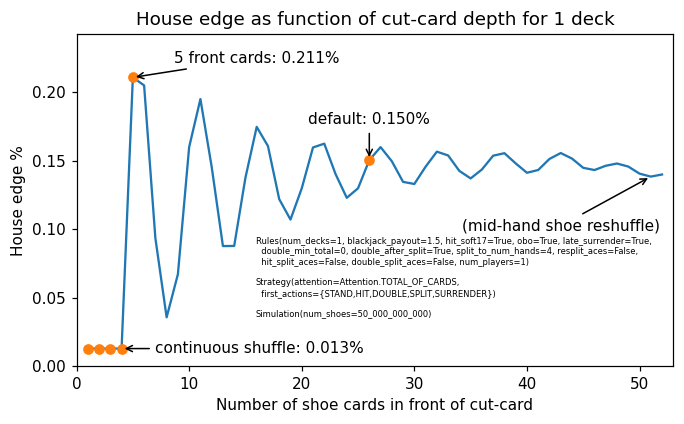

Loading precomputed result.


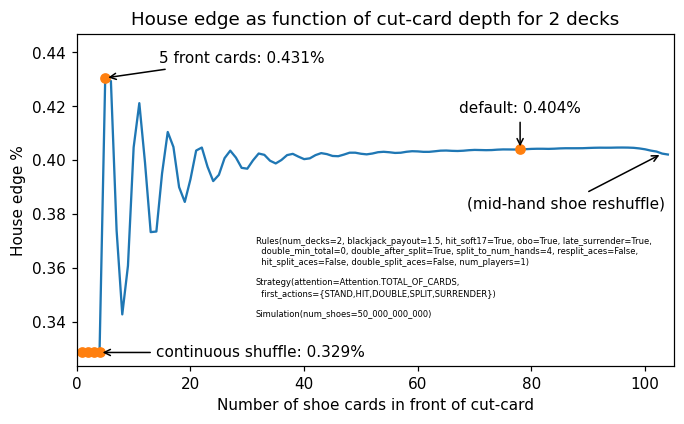

Loading precomputed result.


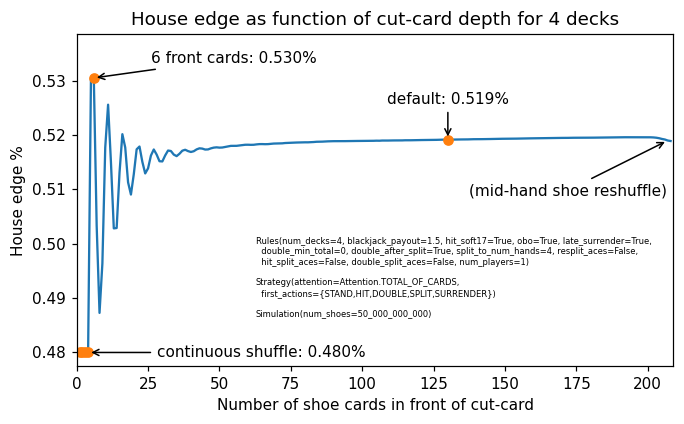

Loading precomputed result.


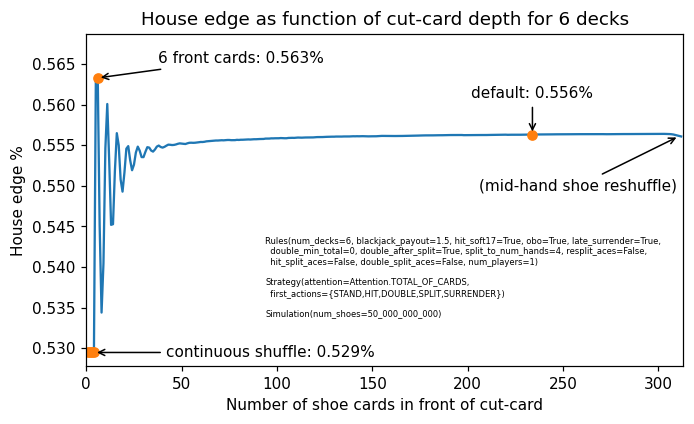

Loading precomputed result.


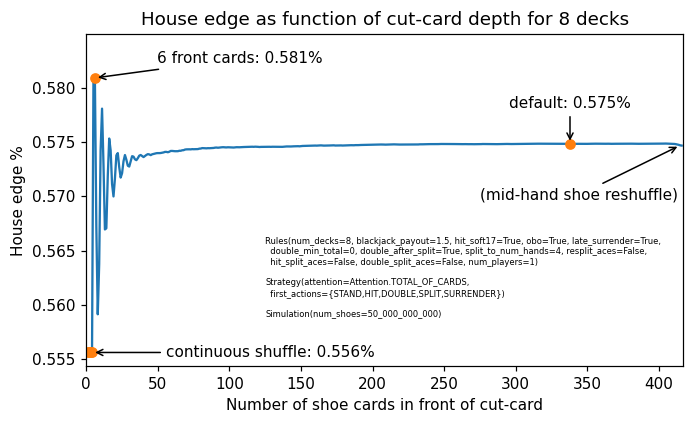

In [257]:
compute_and_plot_cut_card_analysis_results()
# EFFORT=3: 11_000 s (500 s for num_decks=1)
# EFFORT=4: ~15 h (2_500 s for num_decks=1)

In [258]:
def compute_house_edge_when_playing_a_fixed_number_of_hands() -> None:
  """Obtain this number to compare with "continuous reshuffle" in the plots."""
  print(f'# {EFFORT=}:')
  for num_decks in [1, 2, 4, 6, 8]:
    report_edge(Rules.make(num_decks=num_decks, cut_card=0), prefix=f'# ndecks={num_decks:<3} ')


if EFFORT >= 2:
  compute_house_edge_when_playing_a_fixed_number_of_hands()
# EFFORT=3:
# ndecks=1   prob: 0.013% (42s)  sim: 0.012% ±0.002%(97s)   wiz: 0.008%* bja: 0.021%+
# ndecks=2   prob: 0.328% (19s)  sim: 0.329% ±0.002%(75s)   wiz: 0.328%  bja: 0.316%+
# ndecks=4   prob: 0.480% (20s)  sim: 0.478% ±0.002%(77s)   wiz: 0.481%  bja: 0.476%+
# ndecks=6   prob: 0.530% (19s)  sim: 0.530% ±0.002%(75s)   wiz: 0.531%  bja: 0.529%
# ndecks=8   prob: 0.555% (45s)  sim: 0.558% ±0.002%(74s)   wiz: 0.555%  bja: 0.554%+

# EFFORT=2:
# ndecks=1   prob: 0.011% (0s)   sim: 0.010% ±0.007%(0s)    wiz: 0.008%* bja: 0.021%+
# ndecks=2   prob: 0.328% (0s)   sim: 0.324% ±0.007%(0s)    wiz: 0.328%  bja: 0.316%+
# ndecks=4   prob: 0.480% (0s)   sim: 0.477% ±0.007%(0s)    wiz: 0.481%  bja: 0.476%+
# ndecks=6   prob: 0.530% (0s)   sim: 0.531% ±0.007%(0s)    wiz: 0.531%  bja: 0.529%
# ndecks=8   prob: 0.555% (1s)   sim: 0.551% ±0.007%(0s)    wiz: 0.555%  bja: 0.554%


These simulation results confirm that playing *any fixed* number of hands
gives the same house edge value as when playing a *single hand* per shoe
(which is indicated by the *continuous reshuffle* datapoint in the plots above).

In [259]:
# In https://wizardofodds.com/games/blackjack/cut-card-effect/, use of a cut-off card is reported
# to increase the house edge by 0.113% for a single deck; however the position of the cut-card
# is not specified.  We see ~0.11-0.14% depending on the position of the cut-card.

# For 6 decks, the increase in house edge is reported as 0.020%.  We see 0.027% (0.040% for 4 decks
# and 0.020% for 8 decks).

# Analysis summary

- For a single-deck shoe, introducing a cut-card has an effect on house edge that
  varies significantly with the precise cut-card position.

- Our results reproduce the WizardOfOdds hand calculator with 6 digits of accuracy,
  except for SPLIT actions.
  For SPLIT actions, we reproduce the Bjstrat hand calculator results
  (up to small differences due to search pruning).

- Our house edge results closely match the WizardOfOdds results,
  particularly for a composition-dependent strategy.
  The largest differences are in the rule variation `hit_split_aces=True`.
  Computing a house edge using the Bjstrat hand calculator does match our results.

- Our 6 levels of `Attention` in player strategy
  [progressively increase the individual hand rewards](#analyze-hand-action-wrt-attention) and
  [progressively decrease the house edge](#analyze-edge-wrt-attention).

# References

**General**:
- https://en.wikipedia.org/wiki/Blackjack
- https://wizardofodds.com/games/blackjack/basics/#rules
- https://www.casinoguardian.co.uk/blackjack/
- https://wizardofvegas.com/guides/blackjack-survey/
- https://www.blackjackinfo.com/
- https://www.onlinegambling.com/blackjack/odds/
- https://www.onlineunitedstatescasinos.com/las-vegas/blackjack/
- https://en.wikipedia.org/wiki/Gambling_mathematics
- https://www.gamingtheodds.com/blackjack/house-edge/
  &mdash; looks like truncated results of WizardOfOdds assuming no late surrender.
- https://github.com/johntelforduk/blackjack
  &mdash; Python simulator to evaluate house edge for various strategies.
- [First reddit post](
 https://www.reddit.com/r/blackjack/comments/t9ygkm/python_notebook_to_analyze_blackjack_optimal/)

(See also references in
 [Tables for basic strategy](#Tables-for-basic-strategy),
 [Hand calculators](#Hand-calculators), and
 [House edge calculators](#House-edge-calculators).)

# Epilog

In [260]:
if 0:  # Run a single Rules rather than the full notebook.
  hh.clear_functools_caches(globals())
  report_edge(Rules.make())

# Note that these numbers only reflect usage since the last call to temporary_effort(); that is
# the reason that basic_strategy_tables() shows zero hits.
hh.analyze_functools_caches(globals())

# EFFORT=3 single report_edge(Rules.make())
# Rules() Strategy() EFFORT=3:
#  house edge: prob~ 0.530% (51s)  sim: 0.556% ±0.002%(67s)   wiz: 0.551%*
# get_canonical_h..ards_and_total         707/inf        0.938 hit=       10_761 miss=          707
# get_canonical_h..ards_and_total      11_468/inf        0.836 hit=       58_573 miss=       11_468
# card_probabilities_helper           259_716/5_000_000  0.956 hit=    5_693_238 miss=      259_716
# reward_after_de.._upcard_helper     444_190/10_000_000 0.718 hit=    1_130_653 miss=      444_190
# reward_after_dealer_hits          5_028_159/22_000_000 0.751 hit=   15_162_636 miss=    5_028_159
# best_reward_est..on_first_total         738/inf        1.000 hit=    1_701_033 miss=          738
# best_reward_est..total_of_cards      26_190/inf        0.033 hit=          900 miss=       26_190
# best_reward_and_action            1_804_822/10_000_000 0.372 hit=    1_070_536 miss=    1_804_822
# reward_for_basic_strategy_total       1_000/inf        0.991 hit=      110_766 miss=        1_000
# basic_strategy_tables                     0/inf        0.000 hit=            0 miss=            0
# create_tables                             1/inf        0.000 hit=            0 miss=            1

# EFFORT=3 whole notebook:
# get_canonical_h..ards_and_total         879/inf        0.999 hit=      586_257 miss=          879
# get_canonical_h..ards_and_total      14_496/inf        1.000 hit=   48_360_339 miss=       14_496
# card_probabilities_helper         2_551_957/5_000_000  0.992 hit=  301_571_518 miss=    2_551_957
# reward_after_de.._upcard_helper   8_879_960/10_000_000 0.979 hit=  418_689_504 miss=    8_879_960
# reward_after_dealer_hits         22_000_000/22_000_000 0.754 hit=  256_240_189 miss=   83_520_236
# best_reward_est..on_first_total      49_778/inf        1.000 hit=  184_425_375 miss=       49_778
# best_reward_est..total_of_cards   1_623_151/inf        0.472 hit=    1_450_263 miss=    1_623_151
# best_reward_and_action           10_000_000/10_000_000 0.629 hit=  560_633_057 miss=  330_054_234
# reward_for_basic_strategy_total      60_784/inf        0.991 hit=    6_832_516 miss=       60_784
# basic_strategy_tables                     0/inf        0.000 hit=            0 miss=            0
# create_tables                           112/inf        0.385 hit=           70 miss=          112
# create_tables_cuda                      100/inf        0.438 hit=           78 miss=          100
# 18.6 GiB Mem; 1.2 GiB CUDA Mem; 16_000 s

# EFFORT=2 whole notebook:
# get_canonical_h..ards_and_total         879/inf        0.999 hit=      655_058 miss=          879
# get_canonical_h..ards_and_total      14_337/inf        1.000 hit=   30_288_804 miss=       14_337
# card_probabilities_helper           760_829/5_000_000  0.981 hit=   38_544_676 miss=      760_829
# reward_after_de.._upcard_helper   1_247_097/10_000_000 0.967 hit=   36_249_872 miss=    1_247_097
# reward_after_dealer_hits         15_771_331/22_000_000 0.727 hit=   42_088_958 miss=   15_771_331
# best_reward_est..on_first_total      53_278/inf        0.994 hit=    8_500_464 miss=       53_278
# best_reward_est..total_of_cards     235_006/inf        0.334 hit=      117_957 miss=      235_006
# best_reward_and_action           10_000_000/10_000_000 0.765 hit=   77_730_692 miss=   23_847_264
# reward_for_basic_strategy_total      60_784/inf        0.980 hit=    2_950_703 miss=       60_784
# basic_strategy_tables                    13/inf        0.278 hit=            5 miss=           13
# create_tables                           122/inf        0.492 hit=          118 miss=          122
# 10.2 GiB Mem; 2_450 s

# get_canonical_h..ards_and_total         879/inf        0.999 hit=      655_058 miss=          879
# get_canonical_h..ards_and_total      14_337/inf        1.000 hit=   30_272_532 miss=       14_337
# card_probabilities_helper           760_829/5_000_000  0.981 hit=   38_526_324 miss=      760_829
# reward_after_de.._upcard_helper   1_247_097/10_000_000 0.967 hit=   36_217_961 miss=    1_247_097
# reward_after_dealer_hits         15_771_331/22_000_000 0.727 hit=   42_088_958 miss=   15_771_331
# best_reward_est..on_first_total      53_278/inf        0.994 hit=    8_500_464 miss=       53_278
# best_reward_est..total_of_cards     235_006/inf        0.334 hit=      117_957 miss=      235_006
# best_reward_and_action           10_000_000/10_000_000 0.765 hit=   77_695_039 miss=   23_831_978
# reward_for_basic_strategy_total      60_784/inf        0.980 hit=    2_950_703 miss=       60_784
# basic_strategy_tables                    13/inf        0.278 hit=            5 miss=           13


In [261]:
def show_added_global_variables_sorted_by_type() -> None:
  """Report any new global variables introduced by this notebook."""
  ok_typenames = ('ABCMeta EnumMeta EnumType type function partial'
                  ' _lru_cache_wrapper CPUDispatcher CUDADispatcher').split()
  for typename, name in sorted((type(value).__name__, name) for name, value in globals().items()):
    is_ok = (
        name in _ORIGINAL_GLOBALS
        or name.startswith(('_',))
        or 'GenericAlias' in typename
        or typename in ok_typenames
        or (len(name) >= 6 and name.upper() == name)
        or name in 'wizard_edge_calc cut_card_analysis_results'.split()
    )
    if not is_ok:
      print(f'{typename:24} {name}')


show_added_global_variables_sorted_by_type()

In [262]:
hh.show_notebook_cell_top_times()
# EFFORT=0: ~50 s (0.8 GiB)
# EFFORT=1: ~100 s (bottleneck is prob. computations)
#        old: ~165 s (bottleneck is prob. computations)
#      Colab: ~250 s with 100% num_hands; max 12 GB mem; table of contents.
#  SageMaker: ~870 s with 100% num_hands; max 16 GB mem; 4x multiprocessing; jupyter lab; must login.
#     Kaggle: ~740 s with 100% num_hands; max 16 GB mem; 8x multiprocessing; must login.
#   MyBinder: ~480 s with 20% num_hands; max 2 GB mem; copies GitHub; slow start.
#   DeepNote: ~550 s with 20% num_hands; max 5 GB mem; table of contents; copies GitHub; must login.
# EFFORT=2: ~970 s (+ ~160 s cut_card_analysis_results) (10.5 GiB; 1.2 GiB GPU)
#      Colab: timed out.
#     Kaggle: ~24_000 s
# EFFORT=3: ~15_000 s (~4.5 hrs) with CUDA (18.5 GiB, 1.2 GiB GPU)
#           ~25_000 s (~8 hrs) (+ ~11_000 s cut_card_analysis_results)
# EFFORT=4: ~40 hrs or more.

# Total time: 972.73 s
# In[245] if EFFORT >= 2:\n  explore_rule_variations(Rules.make(num_  80.023 s
# In[247] if EFFORT >= 2:\n  explore_rule_variations(Rules.make(num_  71.773 s
# In[192] if EFFORT >= 2:\n  analyze_hand(((7, 8), 10), Rules.make(   63.501 s
# In[244] analyze_number_of_decks(Rules.make(cut_card=0),             56.414 s
# In[252] if EFFORT >= 2:\n  analyze_composition_dependent_strategy_  55.803 s
# In[208] if EFFORT >= 1:\n  test_some_split_hands1()\n# The rewards  48.255 s
# In[211] if EFFORT >= 1:\n  test_some_split_hands2()\n# The paired   42.212 s
# In[237] if EFFORT >= 1:\n  analyze_rule_variations(Rules.make())\n# 41.868 s
# In[231] if EFFORT >= 2:\n  analyze_number_of_decks(Rules.make(hit_  30.768 s
# In[191] def analyze_differences_using_composition_dependent_        28.773 s
# In[130] if 1:\n  if cuda.is_available():\n    print('Timing:')\n    28.680 s
# In[193] if EFFORT >= 2:\n  analyze_hand(((2, 10), 4), Rules.make(   23.593 s
# In[184] analyze_hand(((9, 9

In [263]:
show_kernel_memory_resident_set_size()

10.5 GiB


In [264]:
show_cuda_memory_usage()

CUDA memory usage 1.2 GiB  (10.8 GiB free)


In [265]:
def run_lint(filename: str) -> None:
  """Run checks on *.py notebook code (saved using jupytext or from menu)."""
  if not pathlib.Path(filename).is_file():
    return
  # On SageMaker Studio Lab, if autopep8 sees ~/.config/pycodestyle, ./pyproject.toml is ignored.
  hh.run('echo autopep8; autopep8 --global-config skip -j8 -d .')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo pylint; pylint -j8 . || true')


if 0:
  run_lint('blackjack.py')

From Windows Emacs, `compile` command:
```shell
c:/windows/sysnative/wsl -e bash -lc 'echo autopep8; autopep8 -j8 -d .; echo mypy; mypy .; echo pylint; pylint -j8 .; echo All ran.'
```

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->